In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import datetime
import random
import time
import csv
import os

In [22]:
# sprawdzenie dostępnych urządzeń
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
class Colors:
    GREEN = "green"
    RED = "red"
    BLACK = "black"

def get_color_from_number(number: int) -> str:
    if number == 0:
        return Colors.GREEN
    if 0 < number <= 7:
        return Colors.RED
    if 8 <= number <= 14:
        return Colors.BLACK
    else:
        raise Exception("Number not in accepted range")

def get_color_number_from_color(color: str) -> int:
    if color == Colors.GREEN:
        return 0
    if color == Colors.RED:
        return 1
    if color == Colors.BLACK:
        return 2
    else:
        raise Exception(f"Color '{color}' not handled")

def split_list(lst, chunk_size) -> tuple[list[int], list[int]]:
    data = []
    labels = []
    for i in range(len(lst) - chunk_size):
        data.append(lst[i:i+chunk_size])
        labels.append(lst[i+chunk_size])
    return data, labels

def read_file(file_path: str) -> list[list[str]]:
    with open(file_path, newline='') as file:
        colors = []
        for line in file.readlines():
            numbers = line.strip().split(",")
            try:
                parsed_numbers = list(map(lambda x: int(x), numbers))
                colors.append(list(map(get_color_from_number, parsed_numbers)))
            except Exception as e:
                # parsing numbers failed - that means numbers list contains color strings
                colors.append(numbers)
        return colors

def count_color_sequences(data):
    distinct_colors = list({item for lst in data for item in lst})
    color_sequence_counts = {color: Counter() for color in distinct_colors}

    for sequence in data:
        current_counts = {color: 0 for color in distinct_colors}
        
        for i, color in enumerate(sequence):
            if i == 0 or color == sequence[i - 1]:
                current_counts[color] += 1
            else:
                if current_counts[sequence[i - 1]] > 0:
                    color_sequence_counts[sequence[i - 1]][current_counts[sequence[i - 1]]] += 1
                    current_counts[sequence[i - 1]] = 0
                current_counts[color] = 1
        
        for color in distinct_colors:
            if current_counts[color] > 0:
                color_sequence_counts[color][current_counts[color]] += 1

    return color_sequence_counts

def prepare_data_and_labels(colors: list[list[str]], chunk_size) -> tuple[list[list[int]], list[int]]:
    combined_data = []
    combined_labels = []
    for lst in colors:
        colors_parsed_to_numbers = list(map(get_color_number_from_color,lst))
        data, labels = split_list(colors_parsed_to_numbers, chunk_size)
        combined_data.extend(data)
        combined_labels.extend(labels)
    return combined_data, combined_labels

def show(*args):
    print(f"\n{args}\n")

In [24]:
def plot_color_sequence_histograms_uniform_width(color_sequence_counts):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('Frequency of Consecutive Color Occurrences')
    bar_width = 0.5
    for ax, (color, counts) in zip(axes, color_sequence_counts.items()):
        labels = list(counts.keys())
        values = list(counts.values())
        ax.bar(labels, values, color=color, width=bar_width)
        ax.set_title(f'Color: {color}')
        ax.set_xlabel('Number of Consecutive Occurrences')
        ax.set_ylabel('Frequency')
        ax.set_xticks(labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def plot_data_distribution(y_train, y_test):
    all_labels = [*y_train, *y_test]
    distinct_labels = list(set(all_labels))
    distinct_labels_counts = [all_labels.count(label) for label in distinct_labels]
    
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, distinct_labels_counts, align='center', alpha=1)
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Full distribution')
    plt.show()
        
        
    y_train_distinct_labels_counts = [list(y_train).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_train_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in training set')
    plt.show()
    
    y_test_distinct_labels_counts = [list(y_test).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_test_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in test set')
    plt.show()

    plt.figure(figsize=(16,8))
    train_labels_data = y_train_distinct_labels_counts
    test_labels_data = y_test_distinct_labels_counts
    width = 0.3
    y_pos = np.arange(len(distinct_labels))
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution')
    plt.bar(np.arange(len(train_labels_data)), train_labels_data, width=width, label="Training data")
    plt.bar(np.arange(len(test_labels_data))+ width, test_labels_data, width=width, label="Test data")
    plt.legend()
    plt.show()

def model_fit(model, X_train, y_train, X_test, y_test, epochs):
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train,y_train, epochs=epochs, validation_data=(X_test, y_test))
        return history

def display_accuracy_and_loss_graphs(history):
    plt.figure(figsize=(14,7))
    plt.plot(history.history['accuracy'], label= 'train')
    plt.plot(history.history['val_accuracy'], label= 'test')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label= 'train')
    plt.plot(history.history['val_loss'], label= 'test')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_threshold(threshold, predictions, real_labels):
    correct = 0
    wrong = 0
    
    for probability_arr, label in zip(predictions,real_labels):
        max_probability = max(probability_arr)
        if max_probability < threshold:
            continue
        predicted_label = list(probability_arr).index(max_probability)
        if predicted_label == label:
            correct += 1
        else:
            wrong += 1
    if correct == 0 and wrong == 0:
        print(f"No data reaching {threshold:.2f} threshold")
        return 
    print(f"For threshold set to {threshold:.2f}, correctness is: {correct*100/max(1, correct+wrong):.2f}%")

In [25]:
def build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epochs) -> float:
    # from sklearn.metrics import precision_score, recall_score, f1_score
    # from sklearn.metrics import accuracy_score
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(chunk_size,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    history = model_fit(model, X_train, y_train, X_test, y_test, epochs)
    display_accuracy_and_loss_graphs(history)
    
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    y_probabilities = probability_model.predict(X_test)
    y_predictions = np.argmax(y_probabilities, axis=1)
    
    # precision = precision_score(y_test, y_predictions, average='macro', zero_division=0)  # 'micro', 'macro', 'weighted'
    # recall = recall_score(y_test, y_predictions, average='macro', zero_division=0)
    # f1 = f1_score(y_test, y_predictions, average='macro', zero_division=0)
    
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    
    accuracy = accuracy_score(y_test, y_predictions)
    print(f"Modal accuracy on test set: {accuracy * 100:.2f}%")
    print("\n")

    THRESHOLDS_TO_TEST = np.arange(0.4, 0.9, 0.05)
    for threshold  in THRESHOLDS_TO_TEST:
        test_threshold(threshold, y_probabilities, y_test)
    print("\n")
    
    return accuracy

In [28]:
def analize_dataset(colors_sequences, chunk_sizes, epochs):
    print(f"\nExample sequence: {colors_sequences[0][:12]}\n")
    color_counts = count_color_sequences(colors_sequences)
    for color, count in color_counts.items():
        print(f"{color}: {count}")
    print("\n")
    plot_color_sequence_histograms_uniform_width(color_counts)

    results = []
    for chunk_size in chunk_sizes:
        show(chunk_size)
        data, labels = prepare_data_and_labels(colors, chunk_size)
    
        data_zip = list(zip(data, labels))
        random.shuffle(data_zip)
        data = [list(el[0]) for el in data_zip]
        labels = [int(el[1]) for el in data_zip]
        X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), np.asarray(labels), test_size=0.33)
        plot_data_distribution(y_train, y_test)
    
        print(f"\nExample sequence from training set: {X_train[0]} and its label: {y_train[0]}")
        print(f"\nExample sequence from training set: {X_test[0]} and its label: {y_test[0]}")
        print("\n")
        
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        
        gnb_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {gnb_accuracy * 100:.2f}%")

        rfc = RandomForestClassifier()
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        
        rfc_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {rfc_accuracy * 100:.2f}%")
        print("\n")

        for epoch in epochs:
            accuracy = build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epoch)
            results.append((chunk_size, epoch, accuracy))
    results.sort(key=lambda x: x[2], reverse=True)
    print("Top 3 results:")
    for i in range(min(3, len(results))):
        chunk_size, epoch, accuracy = results[i]
        print(f"Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")
    return results[0]


Data from file: csgo500com.csv


Example sequence: ['red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'red', 'green', 'red', 'red']

black: Counter({1: 630, 2: 277, 3: 140, 4: 65, 5: 24, 7: 11, 6: 11, 8: 2, 11: 1})
red: Counter({1: 601, 2: 300, 3: 129, 4: 61, 5: 29, 6: 21, 8: 4, 7: 3, 10: 2})
green: Counter({1: 266, 2: 16, 3: 1})




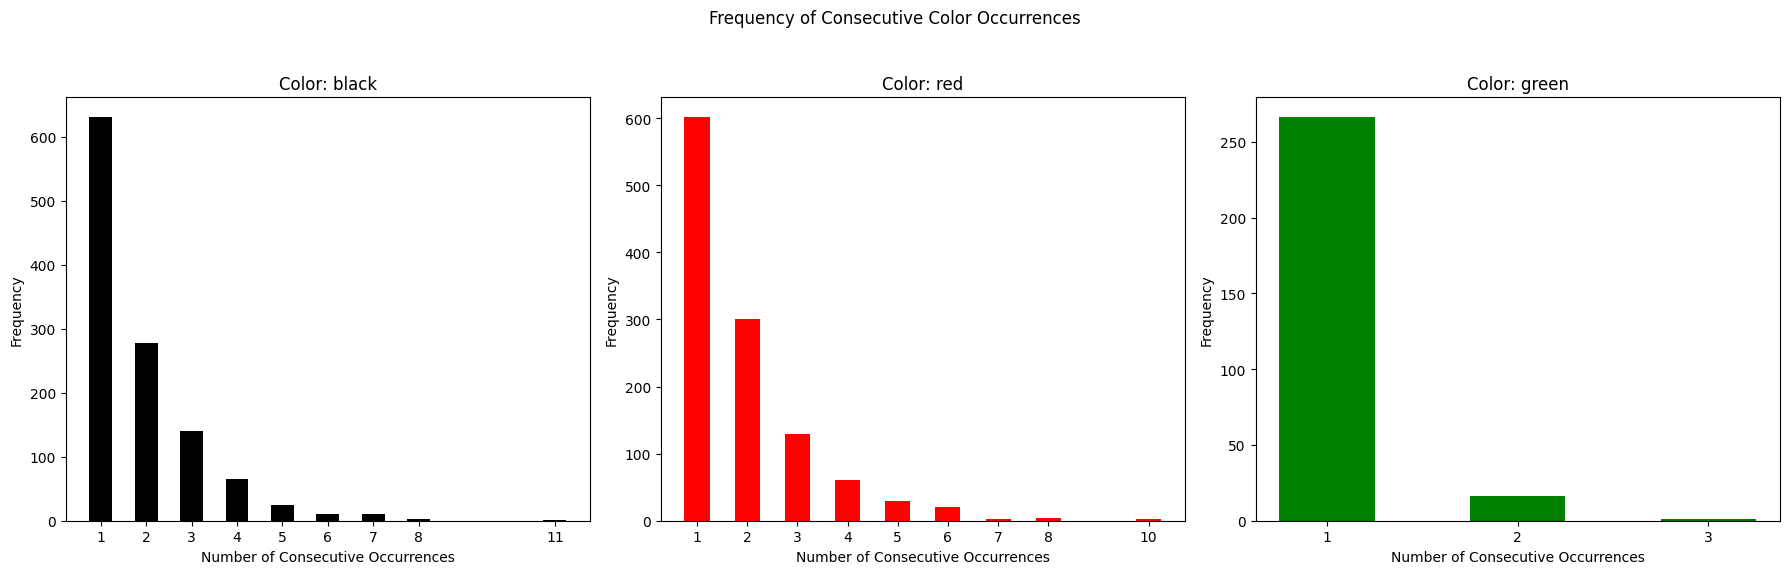


(2,)



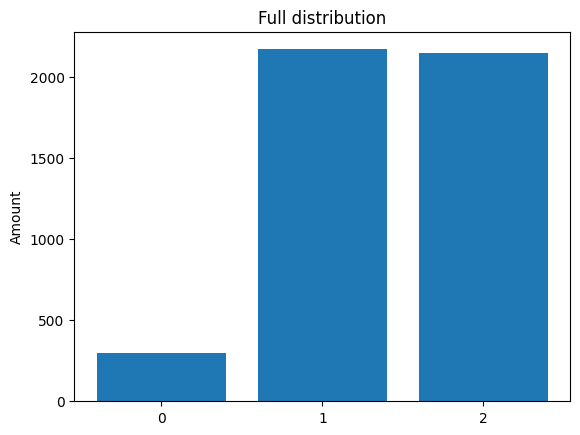

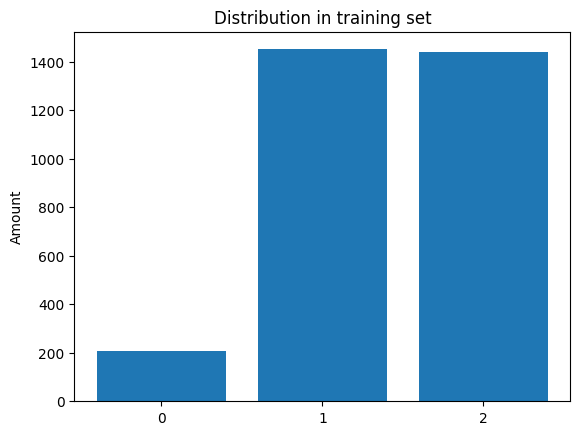

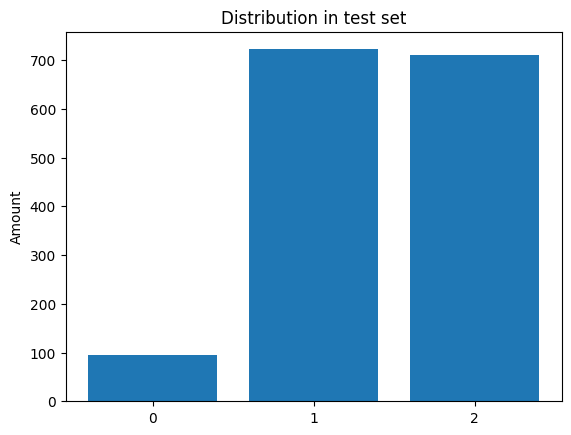

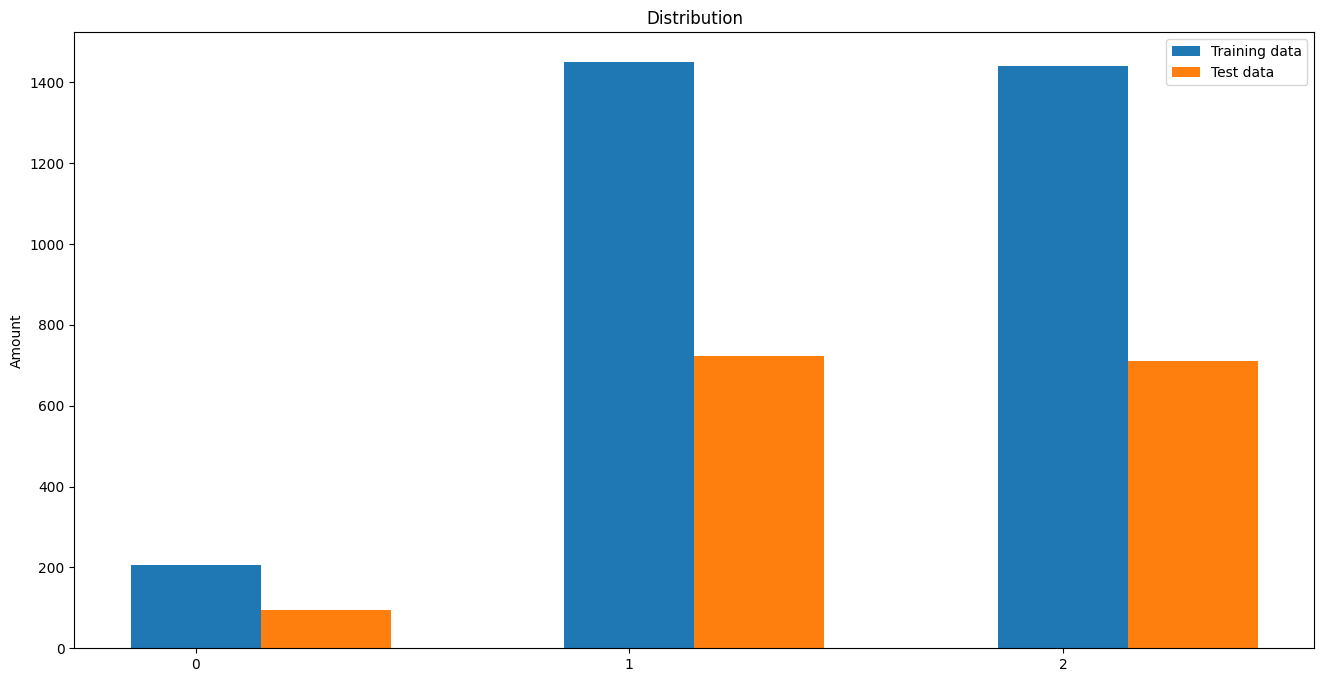


Example sequence from training set: [2 1] and its label: 1

Example sequence from training set: [1 1] and its label: 2


Random forest classifier accuracy: 46.66%
Random forest classifier accuracy: 46.79%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4392 - loss: 1.0498 - val_accuracy: 0.4646 - val_loss: 0.9331
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4807 - loss: 0.9231 - val_accuracy: 0.4646 - val_loss: 0.9021
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4594 - loss: 0.9084 - val_accuracy: 0.4646 - val_loss: 0.8935
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4444 - loss: 0.8980 - val_accuracy: 0.4646 - val_loss: 0.8890
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 0.8886 - val_accuracy: 0.4731 - val_loss: 0.8863
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4620 - loss: 0.8926 - val_accuracy: 0.4731 - val_loss: 0.8846
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━

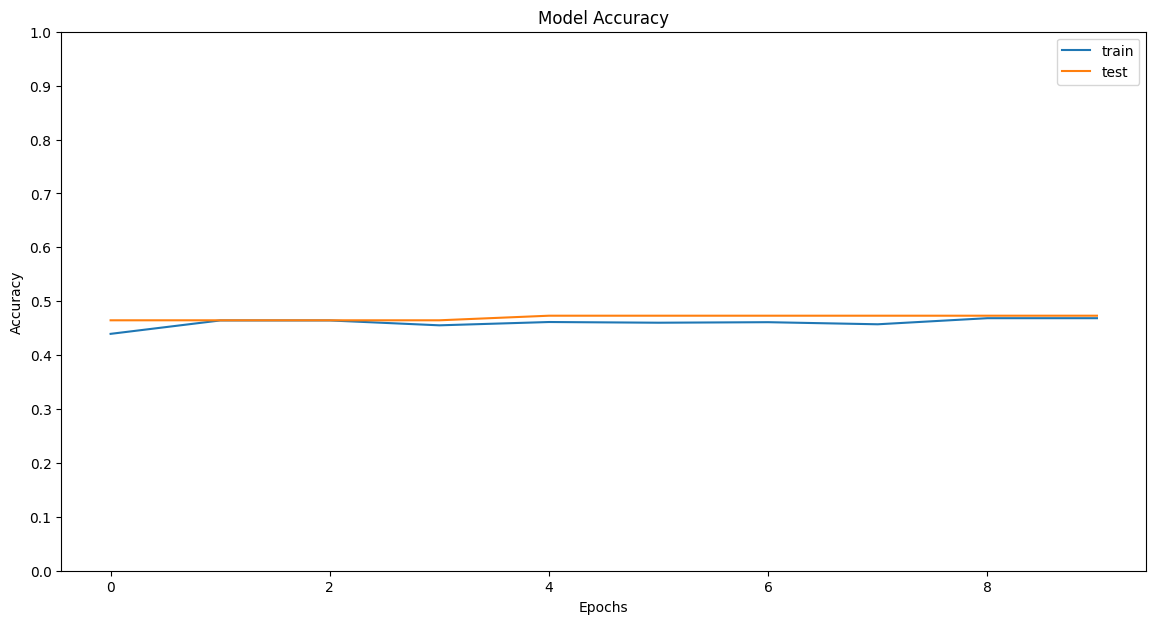

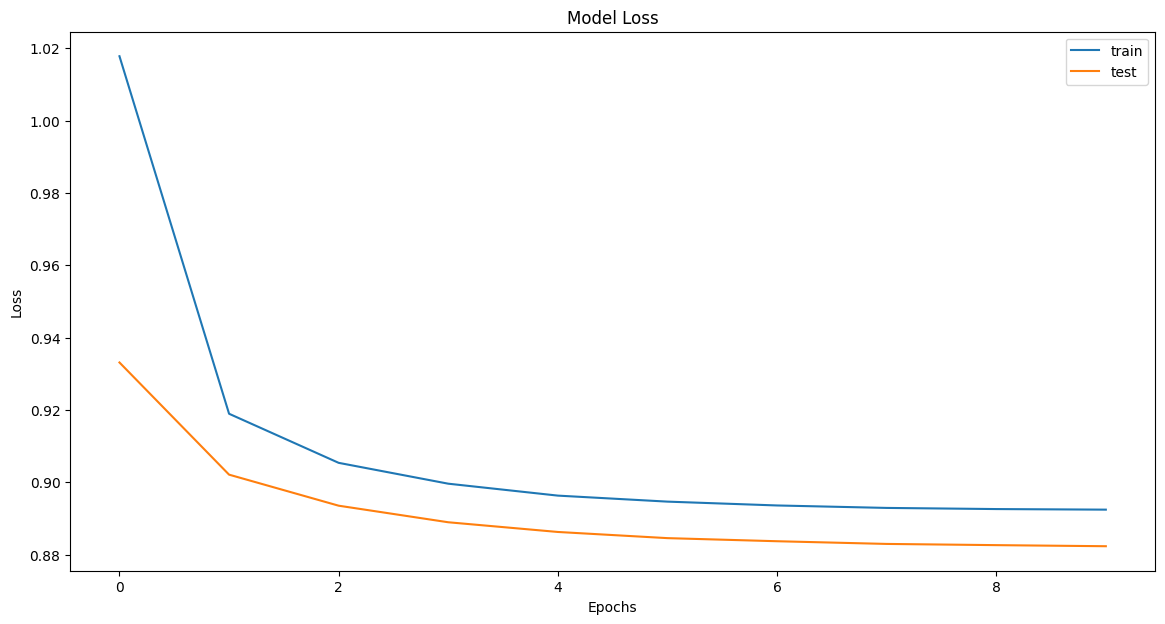

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 47.31%


For threshold set to 0.40, correctness is: 47.31%
For threshold set to 0.45, correctness is: 47.31%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4787 - loss: 1.0524 - val_accuracy: 0.4653 - val_loss: 0.9762
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4574 - loss: 0.9620 - val_accuracy: 0.4646 - val_loss: 0.9044
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4527 - loss: 0.9074 - val_accuracy: 0.4640 - val_loss: 0.8886
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4599 - loss: 0.8994 - val_accuracy: 0.4738 - val_loss: 0.8850
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

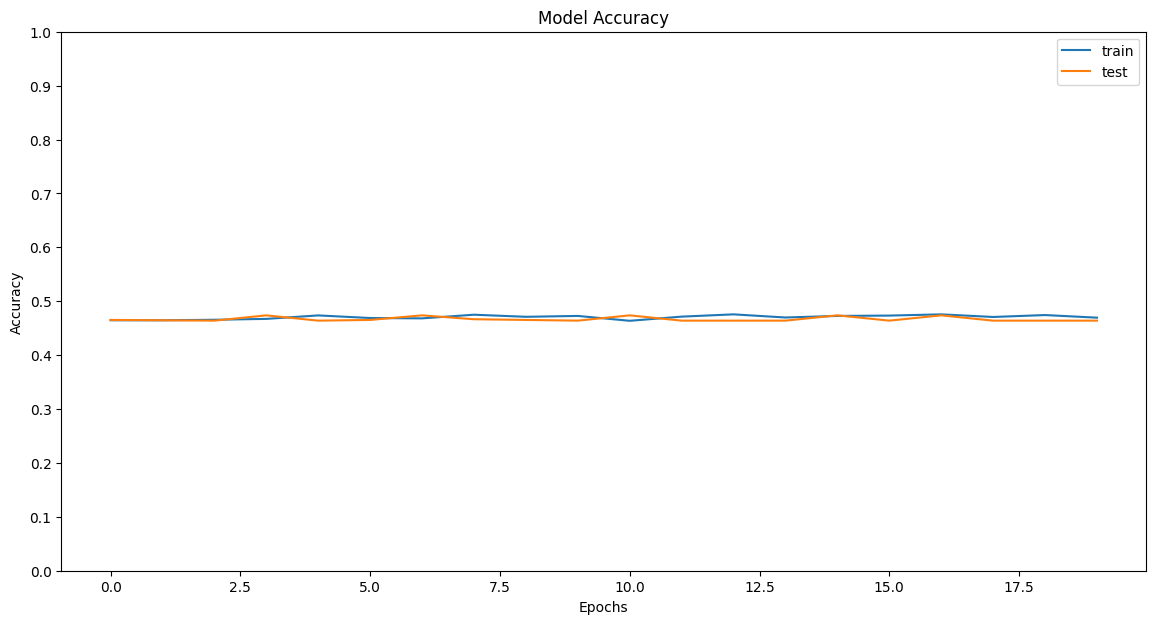

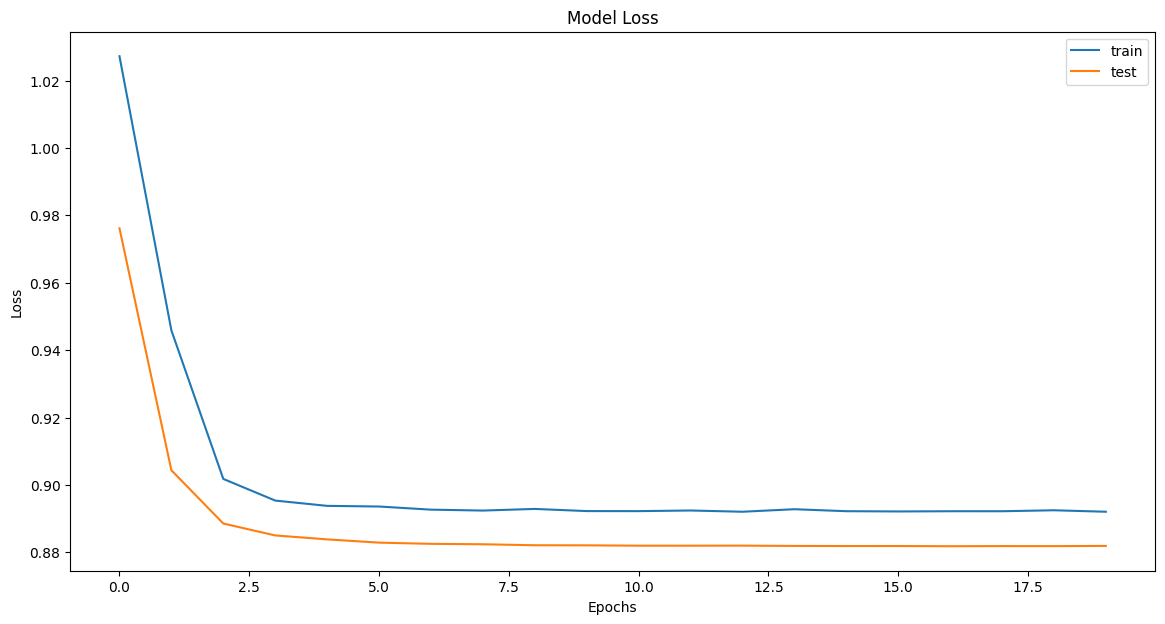

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.40%


For threshold set to 0.40, correctness is: 46.40%
For threshold set to 0.45, correctness is: 46.40%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2691 - loss: 1.0932 - val_accuracy: 0.4731 - val_loss: 0.9470
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4720 - loss: 0.9391 - val_accuracy: 0.4705 - val_loss: 0.9132
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9178 - val_accuracy: 0.4738 - val_loss: 0.9035
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4805 - loss: 0.8986 - val_accuracy: 0.4640 - val_loss: 0.8932
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

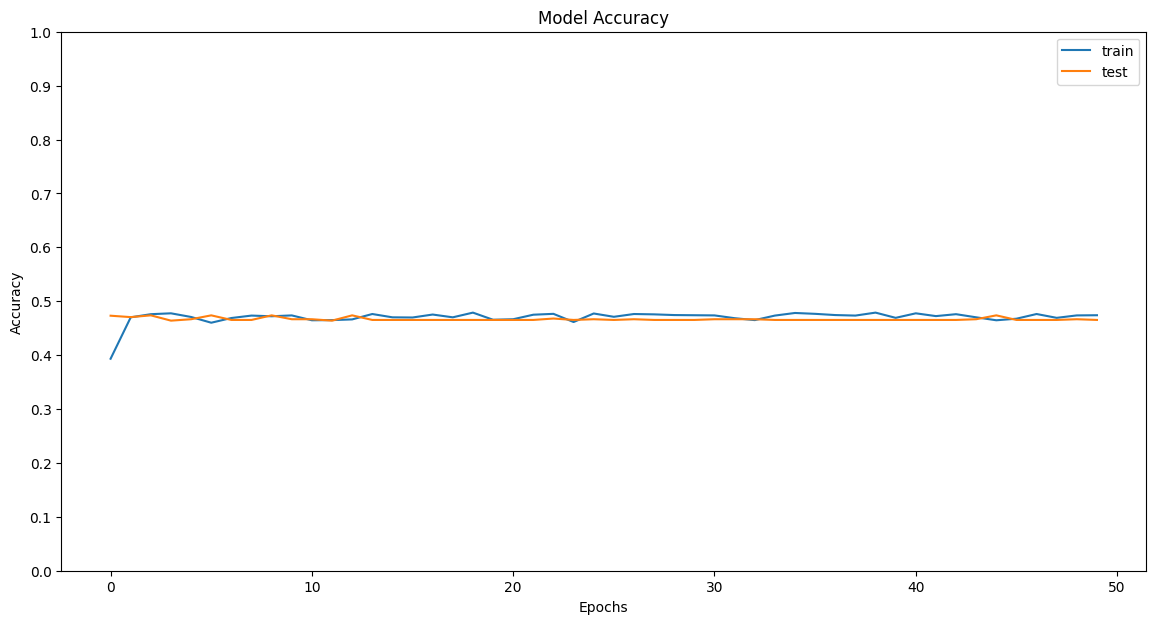

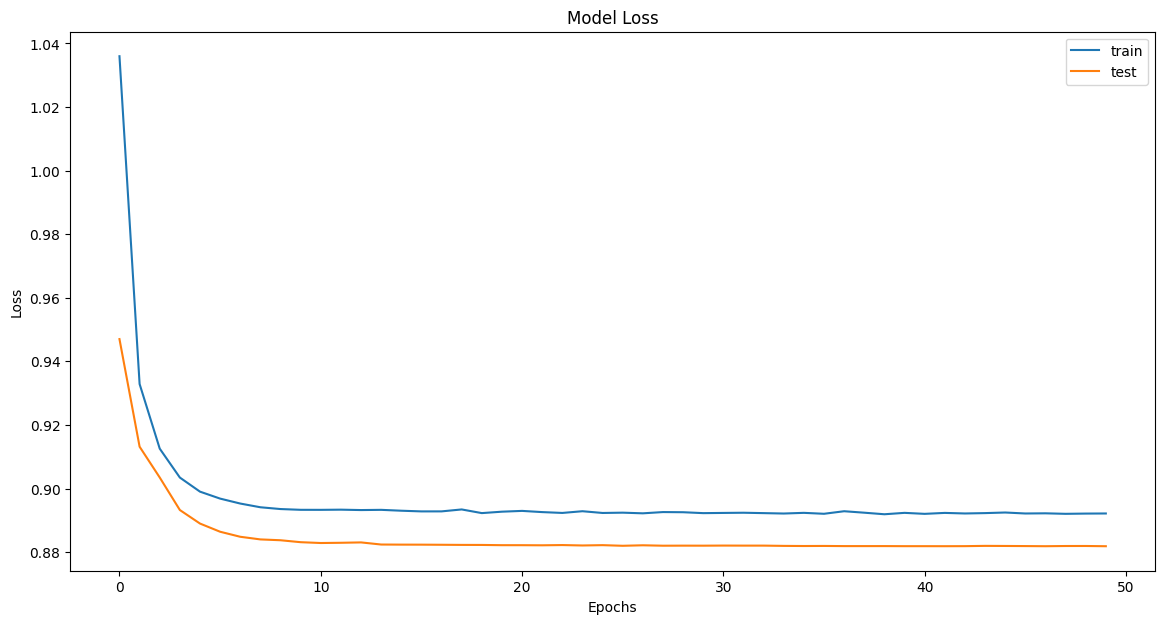

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.53%


For threshold set to 0.40, correctness is: 46.53%
For threshold set to 0.45, correctness is: 46.53%
For threshold set to 0.50, correctness is: 66.67%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



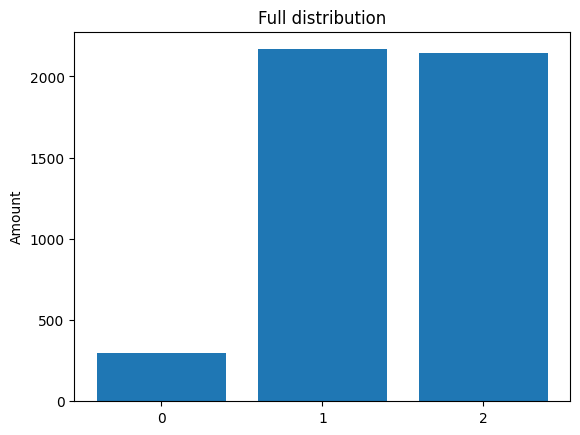

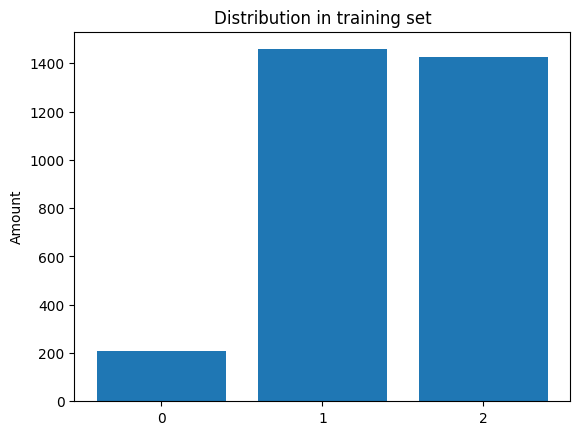

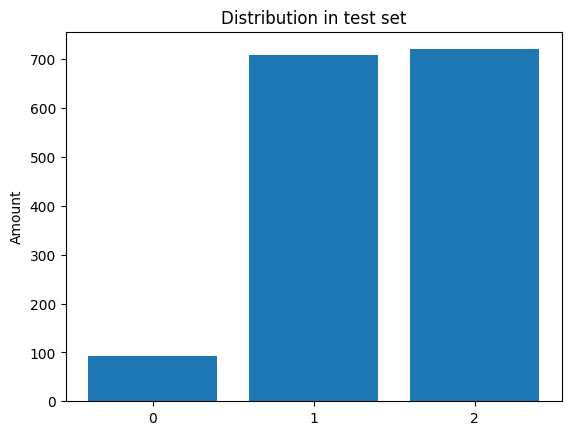

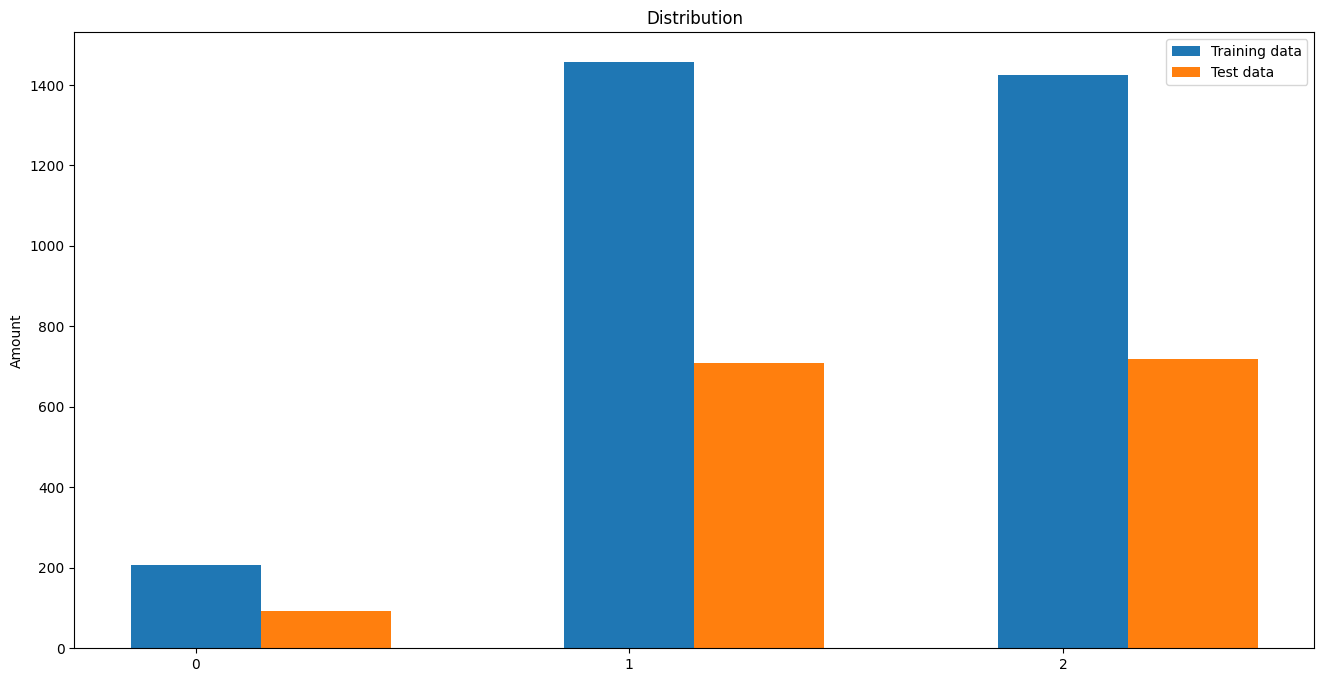


Example sequence from training set: [2 2 2 0 1] and its label: 1

Example sequence from training set: [1 1 1 2 1] and its label: 0


Random forest classifier accuracy: 46.52%
Random forest classifier accuracy: 45.34%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4858 - loss: 1.0300 - val_accuracy: 0.4658 - val_loss: 0.9439
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4848 - loss: 0.9354 - val_accuracy: 0.4658 - val_loss: 0.9146
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4829 - loss: 0.9135 - val_accuracy: 0.4658 - val_loss: 0.8997
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4630 - loss: 0.9022 - val_accuracy: 0.4658 - val_loss: 0.8918
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4681 - loss: 0.8974 - val_accuracy: 0.4658 - val_loss: 0.8873
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4750 - loss: 0.8926 - val_accuracy: 0.4658 - val_loss: 0.8849
Epoch 7/10
97/97 ━━━━━━

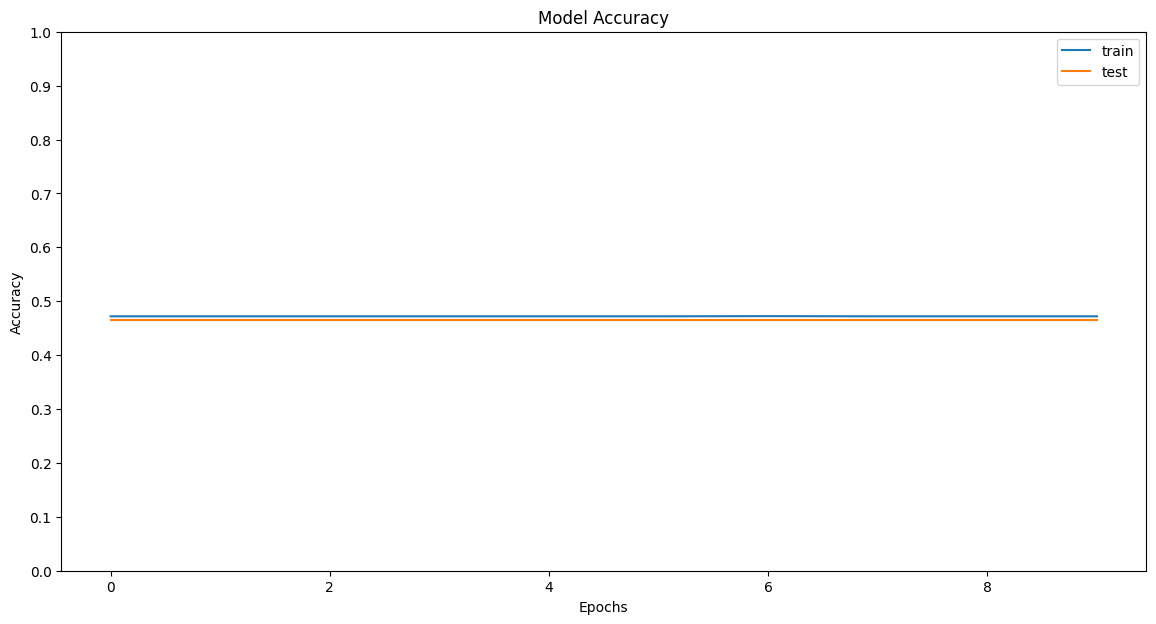

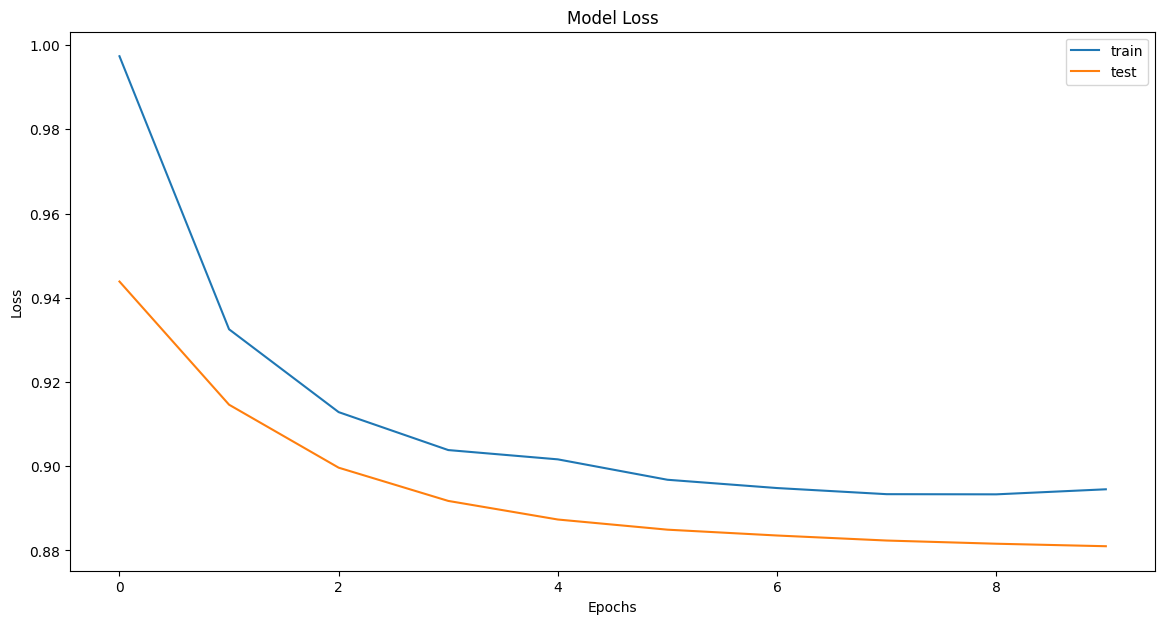

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 46.58%


For threshold set to 0.40, correctness is: 46.58%
For threshold set to 0.45, correctness is: 46.58%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4371 - loss: 1.0712 - val_accuracy: 0.4731 - val_loss: 0.9731
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4583 - loss: 0.9622 - val_accuracy: 0.4547 - val_loss: 0.9337
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4673 - loss: 0.9312 - val_accuracy: 0.4665 - val_loss: 0.9151
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4754 - loss: 0.9114 - val_accuracy: 0.4606 - val_loss: 0.9025
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

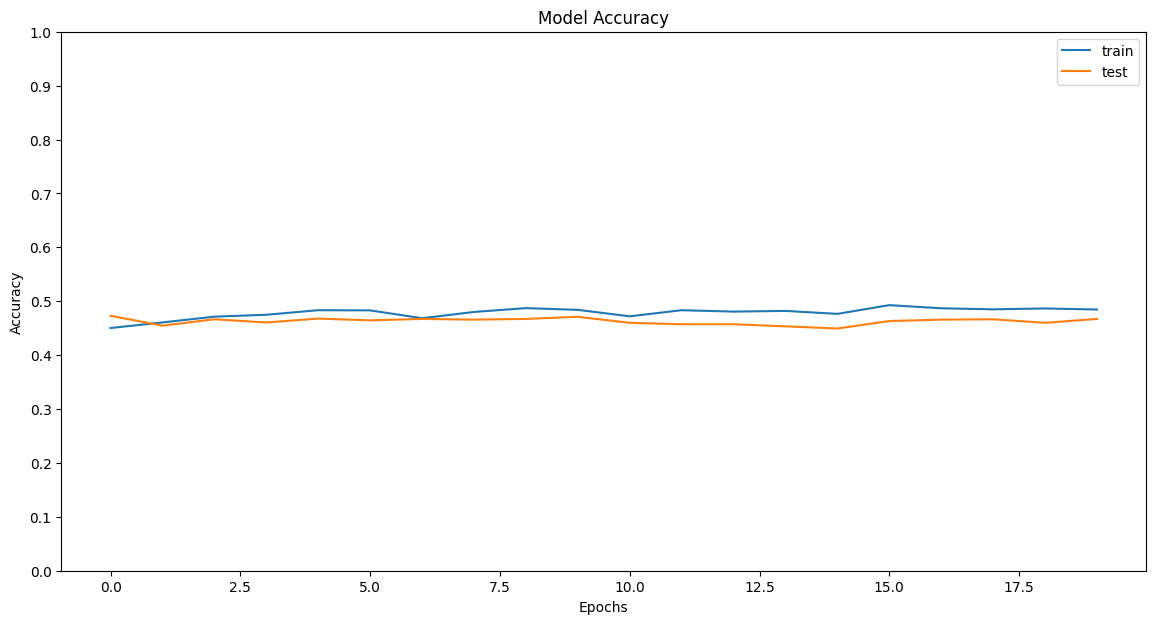

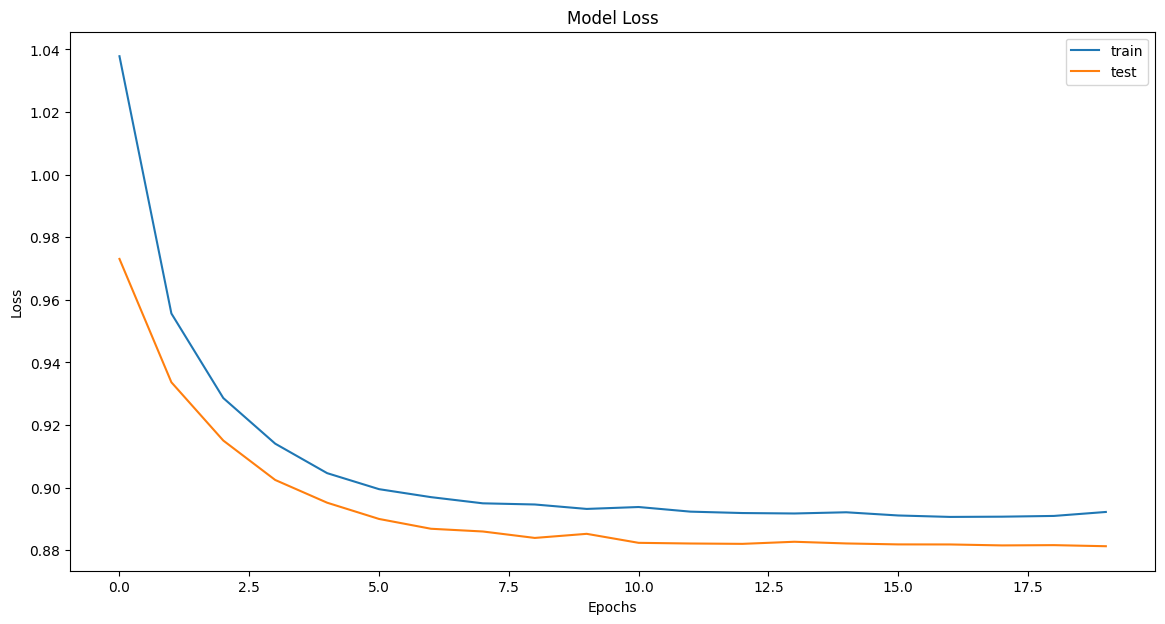

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.71%


For threshold set to 0.40, correctness is: 46.71%
For threshold set to 0.45, correctness is: 46.71%
For threshold set to 0.50, correctness is: 48.65%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3680 - loss: 1.0635 - val_accuracy: 0.4639 - val_loss: 0.9505
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4667 - loss: 0.9424 - val_accuracy: 0.4658 - val_loss: 0.9228
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4689 - loss: 0.9163 - val_accuracy: 0.4586 - val_loss: 0.9059
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4689 - loss: 0.9184 - val_accuracy: 0.4606 - val_loss: 0.8972
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

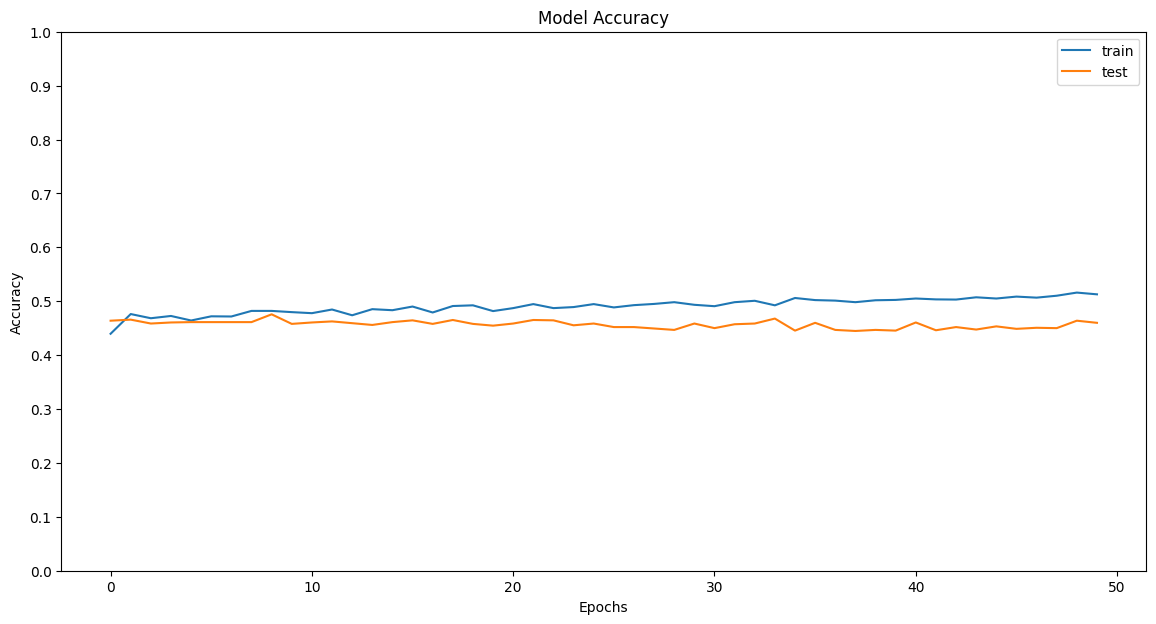

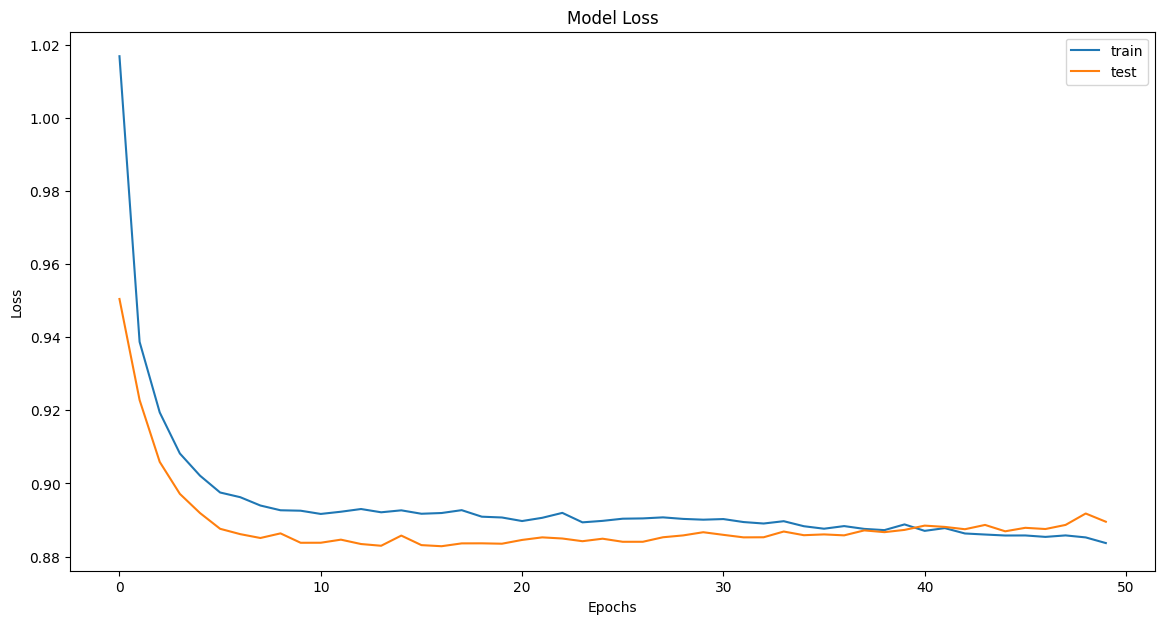

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 45.99%


For threshold set to 0.40, correctness is: 45.99%
For threshold set to 0.45, correctness is: 45.99%
For threshold set to 0.50, correctness is: 44.94%
For threshold set to 0.55, correctness is: 46.71%
For threshold set to 0.60, correctness is: 33.33%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



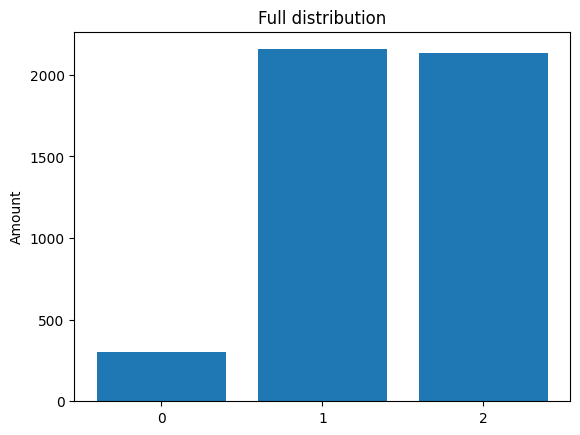

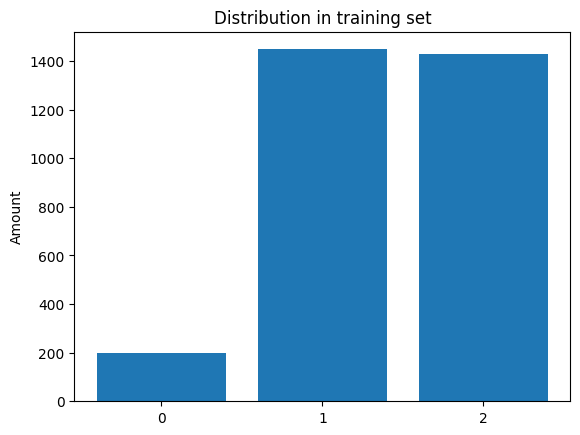

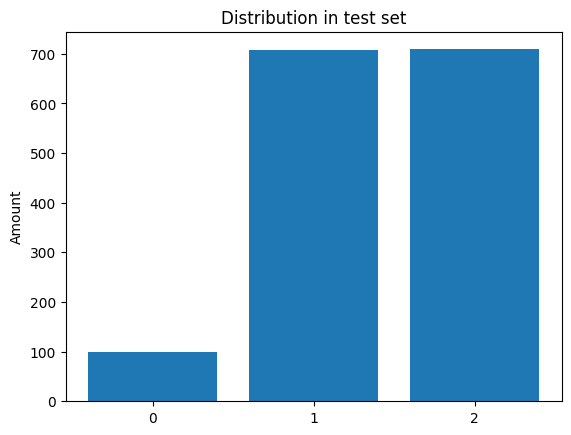

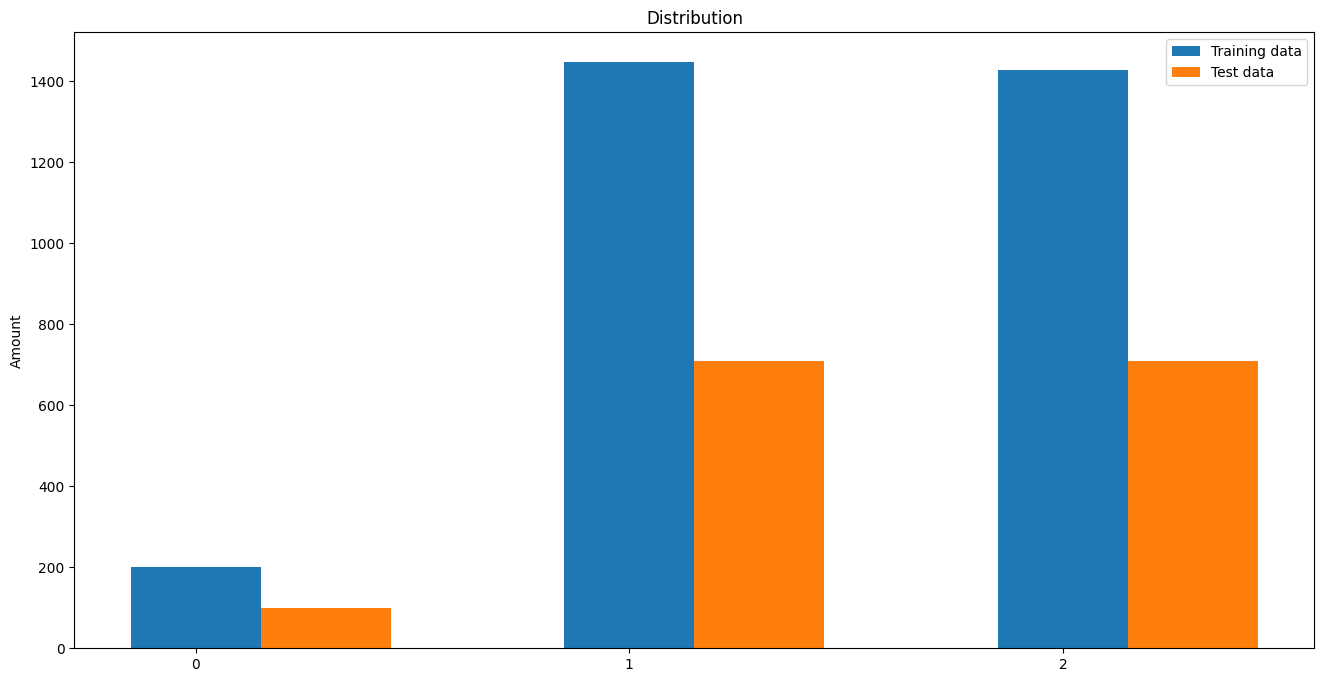


Example sequence from training set: [1 1 1 1 2 2 2 1 1 1] and its label: 1

Example sequence from training set: [1 2 1 1 2 1 1 1 1 1] and its label: 2


Random forest classifier accuracy: 46.77%
Random forest classifier accuracy: 46.17%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4707 - loss: 1.0221 - val_accuracy: 0.4664 - val_loss: 0.9131
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4545 - loss: 0.8981 - val_accuracy: 0.4631 - val_loss: 0.9001
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4703 - loss: 0.8945 - val_accuracy: 0.4538 - val_loss: 0.8943
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4737 - loss: 0.8866 - val_accuracy: 0.4644 - val_loss: 0.8909
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 0.8720 - val_accuracy: 0.4650 - val_loss: 0.8897
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4872 - loss: 0.8906 - val_accuracy: 0.4650 - val_loss: 0.8887
Epo

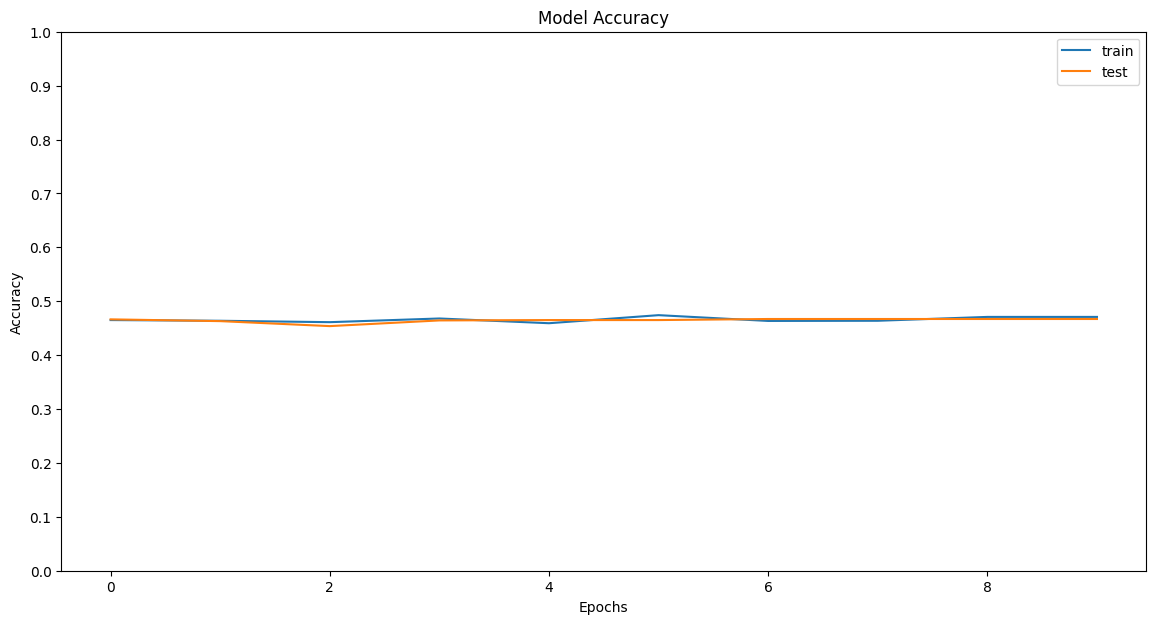

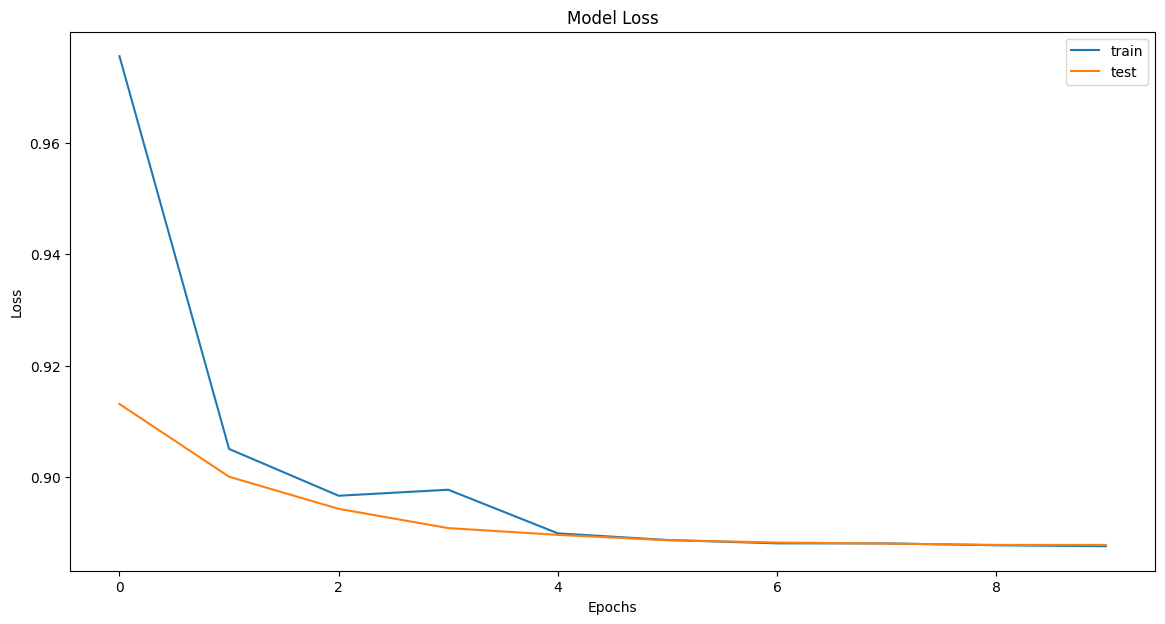

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.70%


For threshold set to 0.40, correctness is: 46.70%
For threshold set to 0.45, correctness is: 46.70%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4649 - loss: 1.0291 - val_accuracy: 0.4505 - val_loss: 0.9369
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4558 - loss: 0.9239 - val_accuracy: 0.4683 - val_loss: 0.9072
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4547 - loss: 0.9099 - val_accuracy: 0.4677 - val_loss: 0.8980
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4514 - loss: 0.9088 - val_accuracy: 0.4637 - val_loss: 0.8932
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

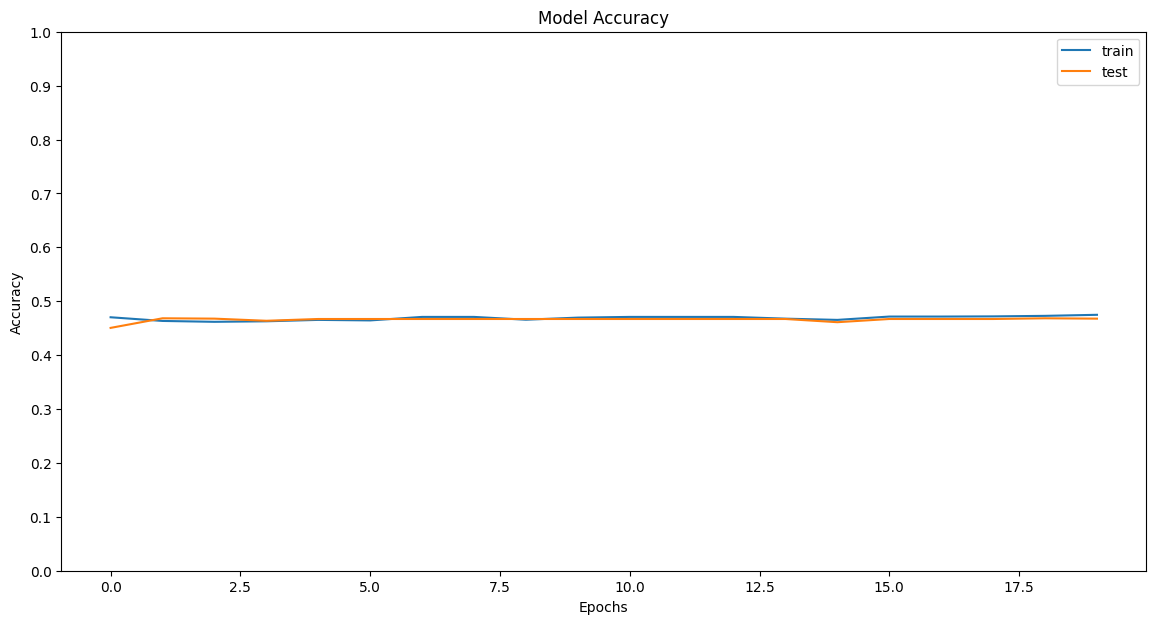

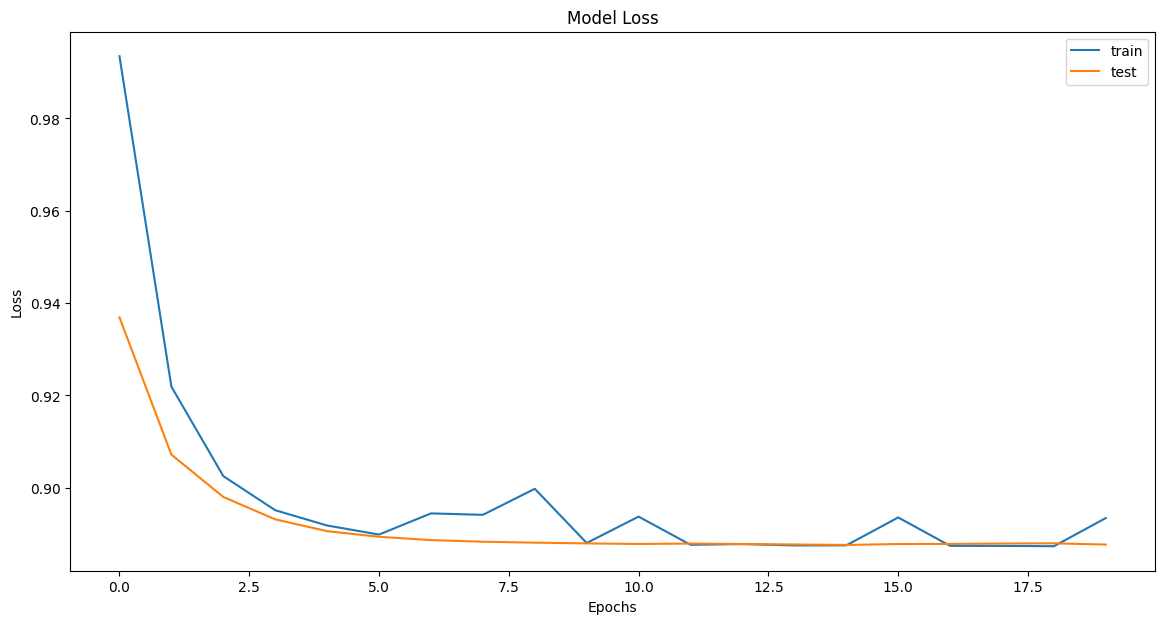

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 46.77%


For threshold set to 0.40, correctness is: 46.77%
For threshold set to 0.45, correctness is: 46.77%
For threshold set to 0.50, correctness is: 0.00%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4661 - loss: 1.0675 - val_accuracy: 0.4677 - val_loss: 0.9602
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4576 - loss: 0.9484 - val_accuracy: 0.4710 - val_loss: 0.9321
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4864 - loss: 0.9176 - val_accuracy: 0.4677 - val_loss: 0.9165
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.9092 - val_accuracy: 0.4664 - val_loss: 0.9084
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

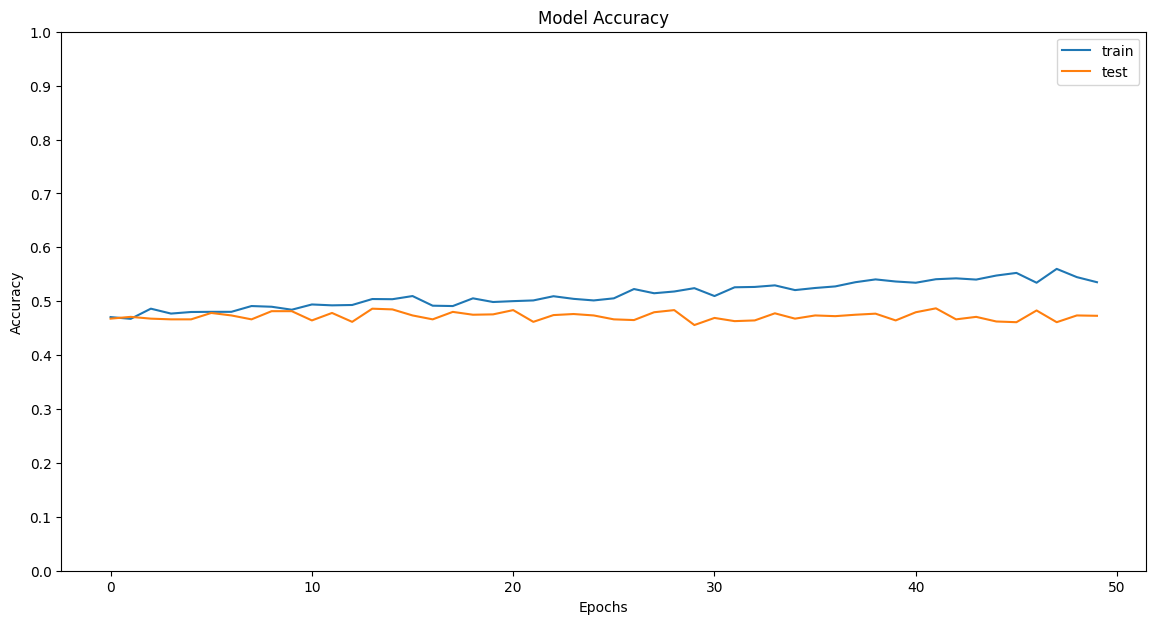

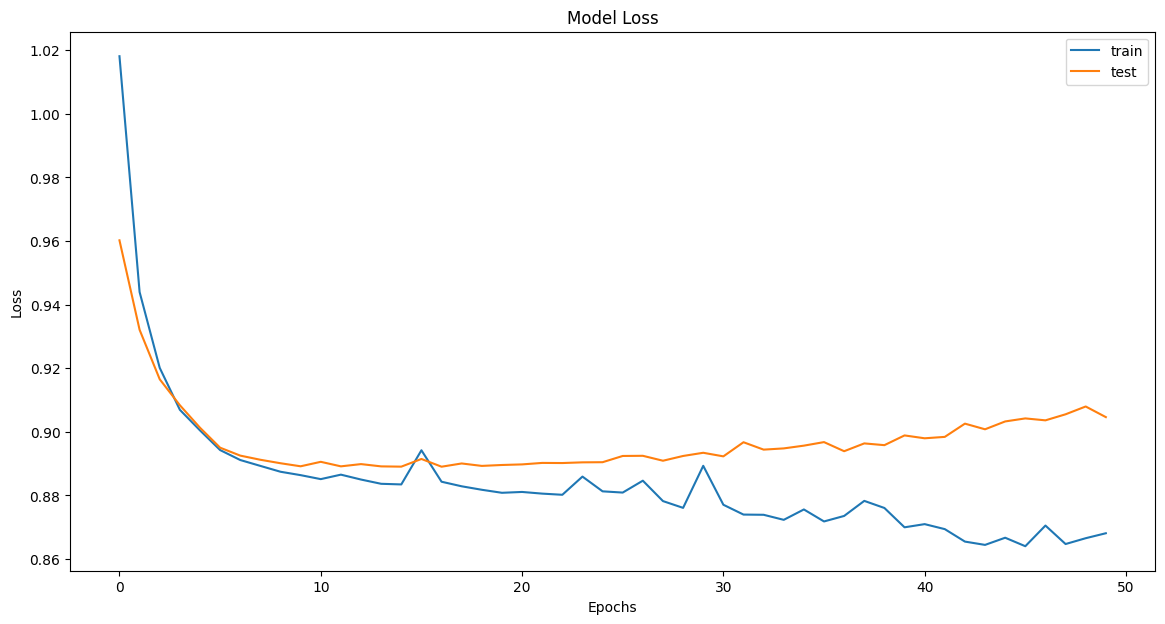

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 47.30%


For threshold set to 0.40, correctness is: 47.30%
For threshold set to 0.45, correctness is: 47.30%
For threshold set to 0.50, correctness is: 47.58%
For threshold set to 0.55, correctness is: 46.33%
For threshold set to 0.60, correctness is: 45.18%
For threshold set to 0.65, correctness is: 50.00%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



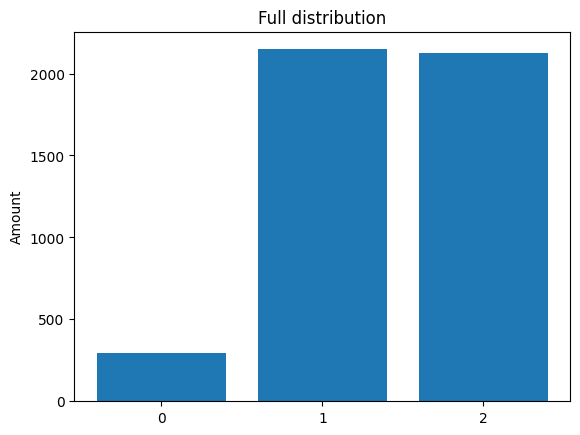

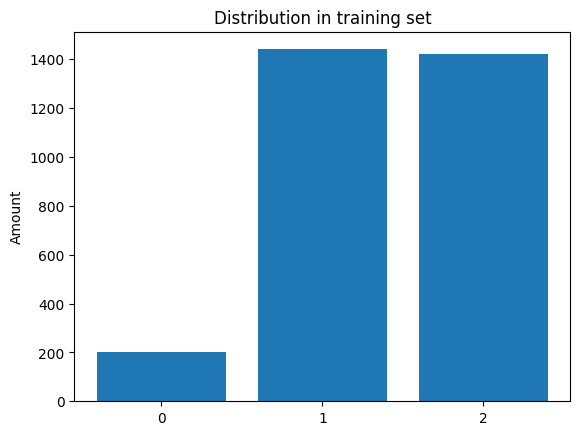

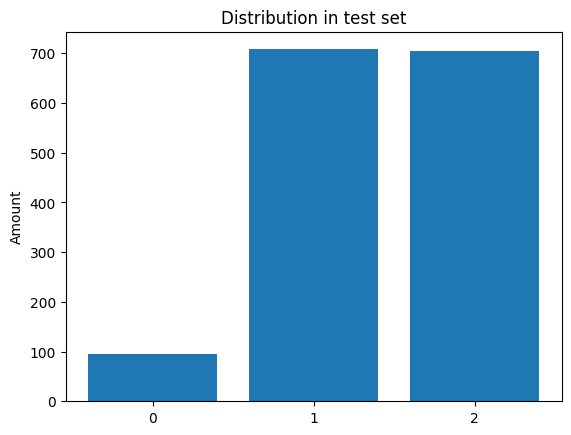

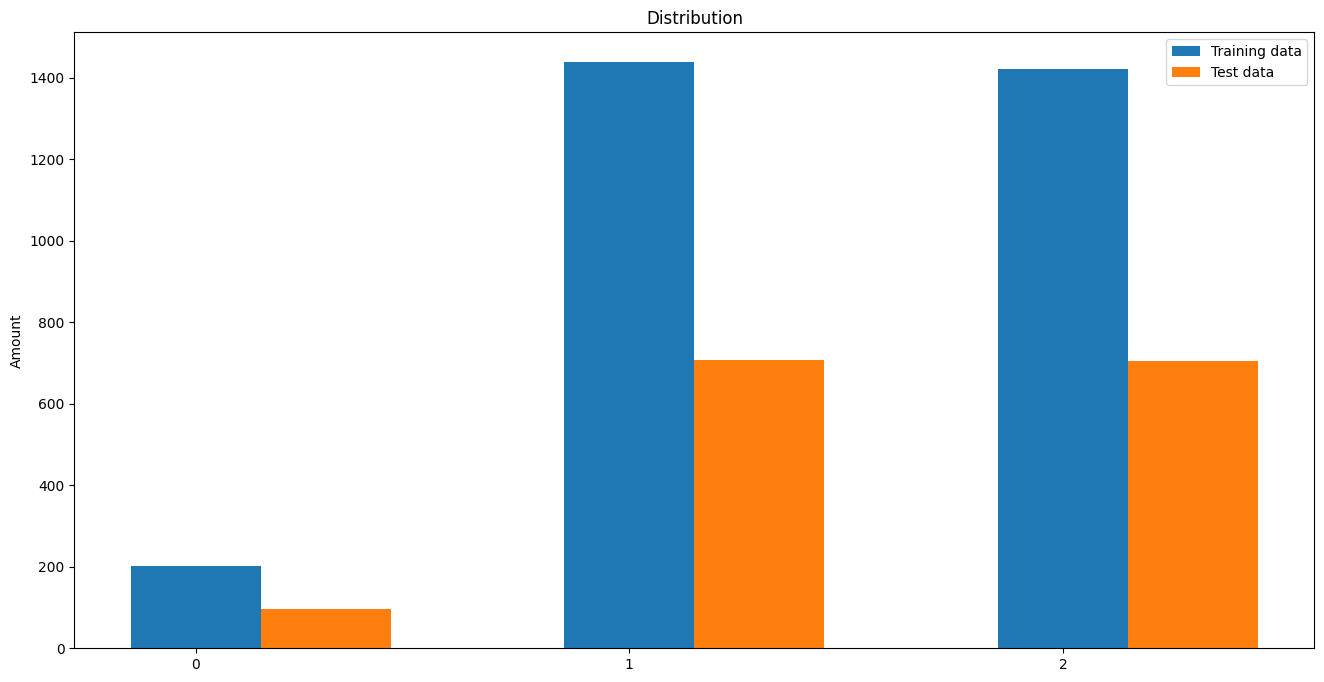


Example sequence from training set: [2 2 1 2 2 1 0 2 1 2 2 2 1 1 1] and its label: 2

Example sequence from training set: [2 1 2 0 1 2 1 2 2 0 2 1 2 1 0] and its label: 1


Random forest classifier accuracy: 47.38%
Random forest classifier accuracy: 47.71%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4220 - loss: 1.0116 - val_accuracy: 0.4672 - val_loss: 0.9011
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4686 - loss: 0.9082 - val_accuracy: 0.4685 - val_loss: 0.8936
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4642 - loss: 0.8883 - val_accuracy: 0.4685 - val_loss: 0.8893
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4609 - loss: 0.8995 - val_accuracy: 0.4692 - val_loss: 0.8872
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.8979 - val_accuracy: 0.4692 - val_loss: 0.8858
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4589 - loss: 0.8879 - val_accuracy: 0.4692 - 

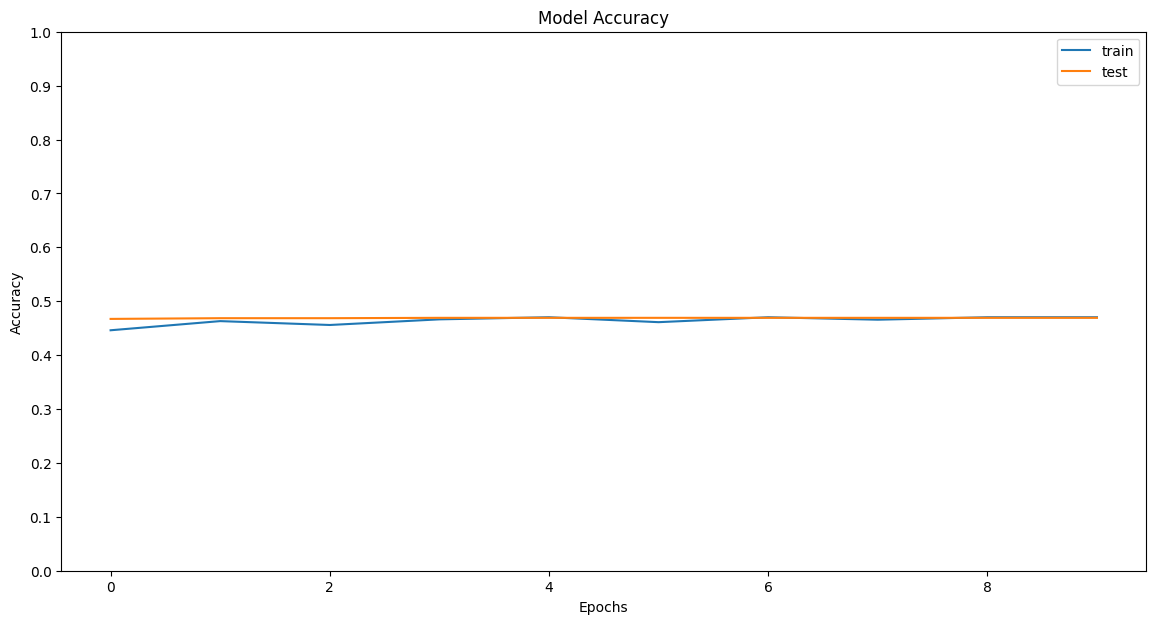

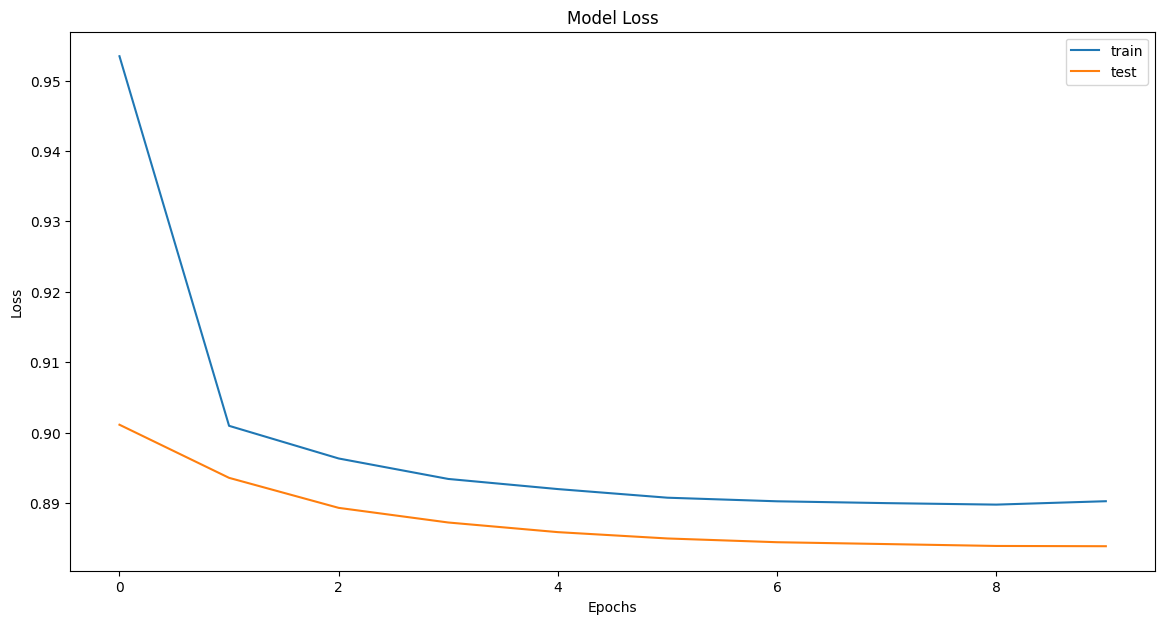

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.92%


For threshold set to 0.40, correctness is: 46.92%
For threshold set to 0.45, correctness is: 46.92%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4098 - loss: 1.0585 - val_accuracy: 0.4672 - val_loss: 0.9057
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4827 - loss: 0.8984 - val_accuracy: 0.4672 - val_loss: 0.8934
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4581 - loss: 0.8908 - val_accuracy: 0.4672 - val_loss: 0.8891
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4496 - loss: 0.8941 - val_accuracy: 0.4692 - val_loss: 0.8869
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

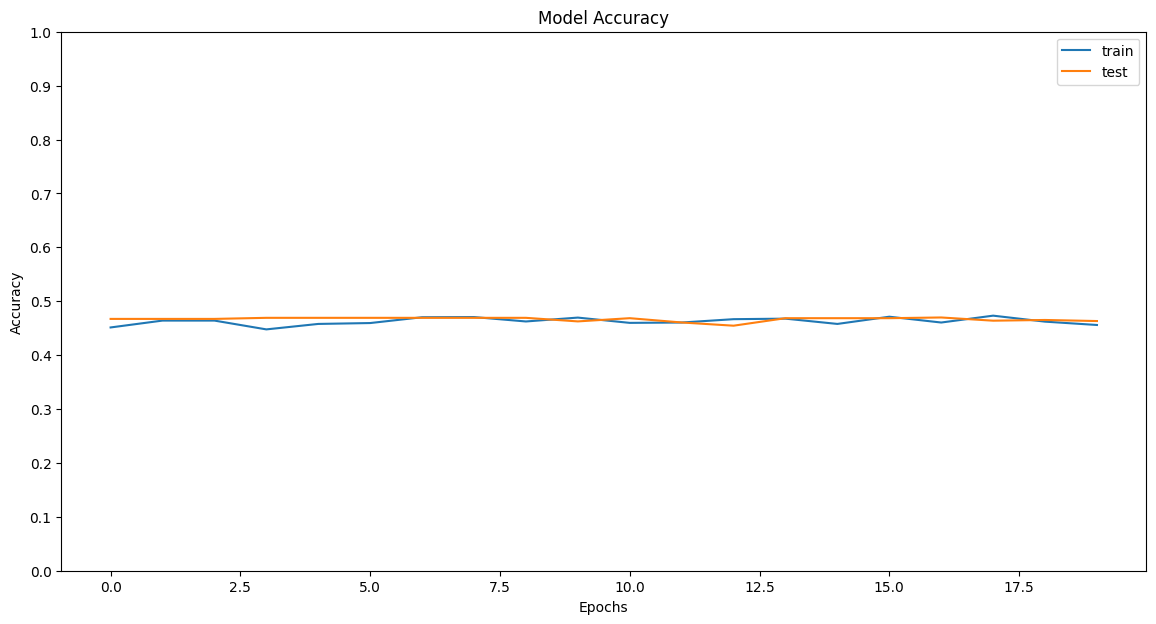

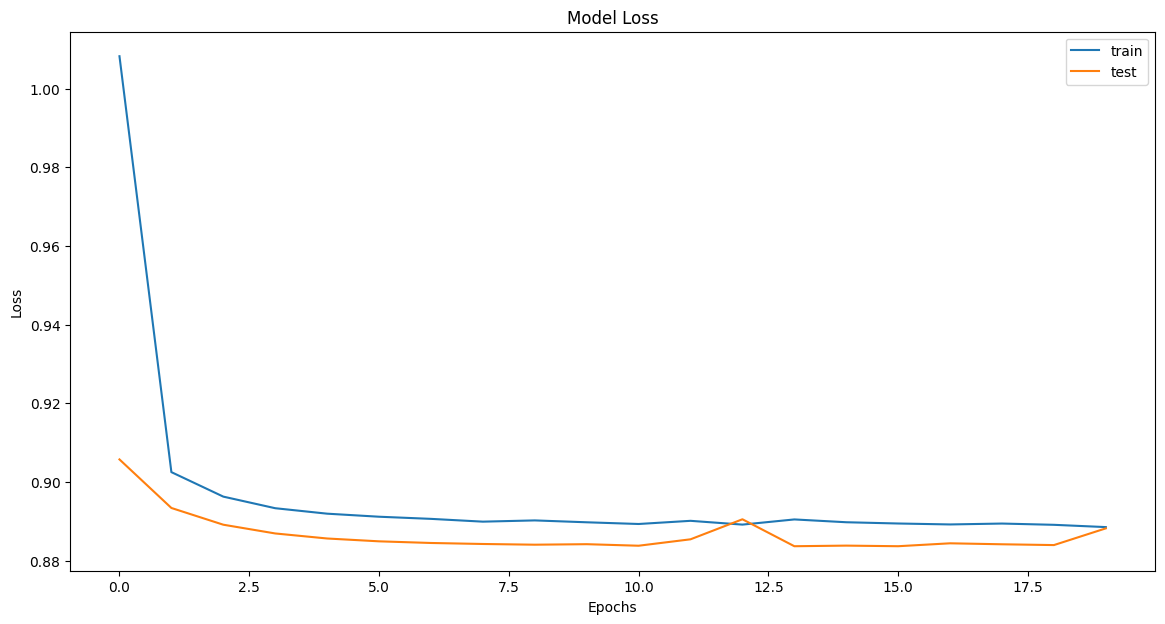

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.32%


For threshold set to 0.40, correctness is: 46.32%
For threshold set to 0.45, correctness is: 46.58%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3374 - loss: 1.0694 - val_accuracy: 0.4692 - val_loss: 0.9375
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4638 - loss: 0.9275 - val_accuracy: 0.4692 - val_loss: 0.9132
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4637 - loss: 0.9201 - val_accuracy: 0.4692 - val_loss: 0.9015
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4672 - loss: 0.9066 - val_accuracy: 0.4692 - val_loss: 0.8947
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

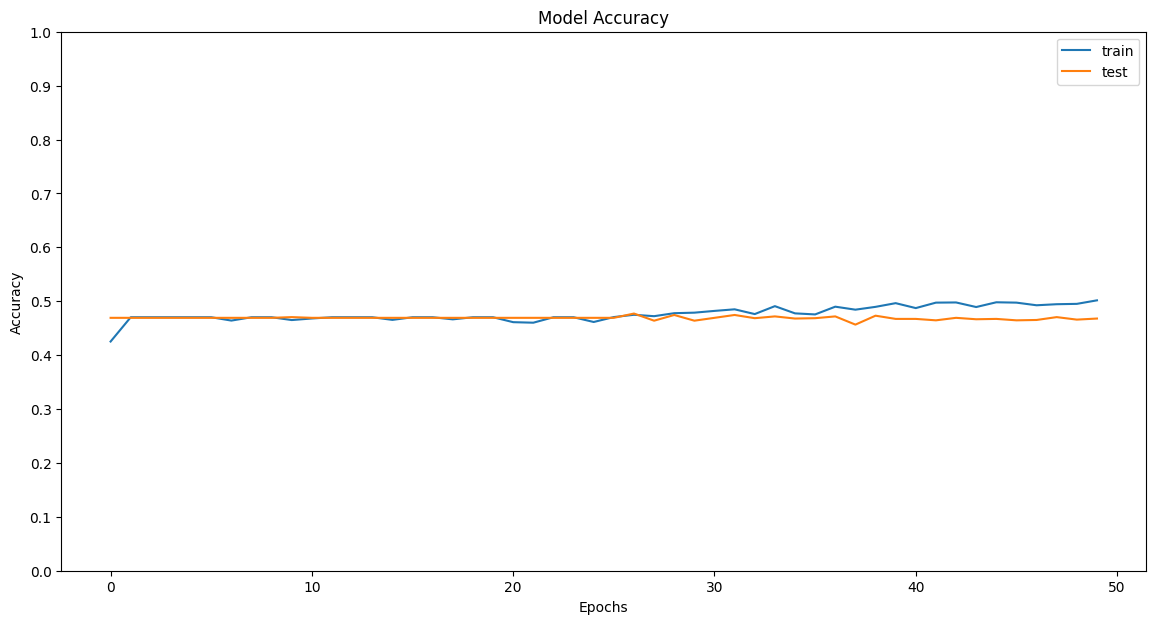

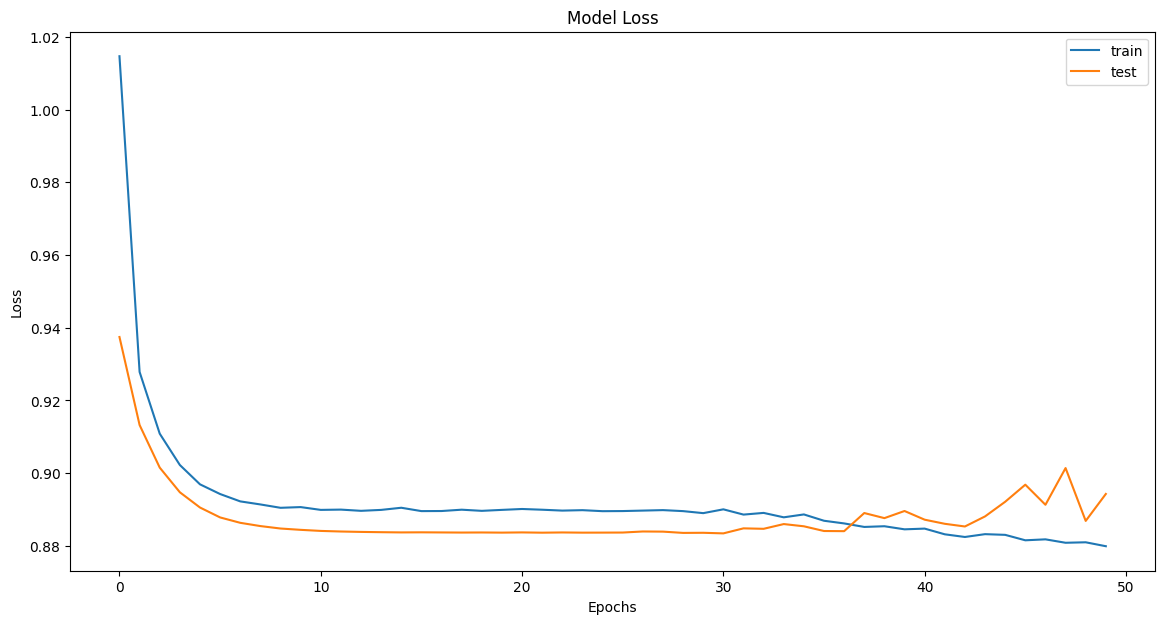

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.79%


For threshold set to 0.40, correctness is: 46.79%
For threshold set to 0.45, correctness is: 46.71%
For threshold set to 0.50, correctness is: 43.31%
For threshold set to 0.55, correctness is: 39.71%
For threshold set to 0.60, correctness is: 44.83%
For threshold set to 0.65, correctness is: 0.00%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



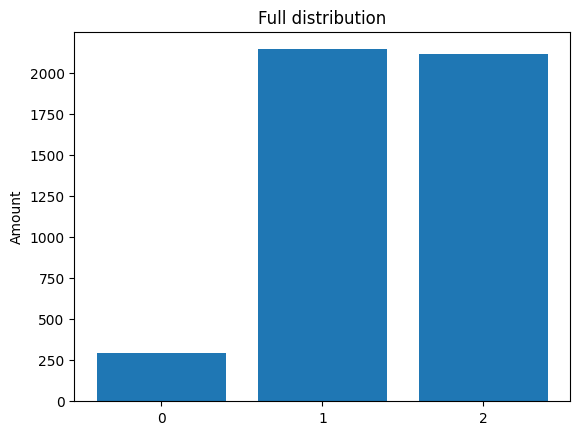

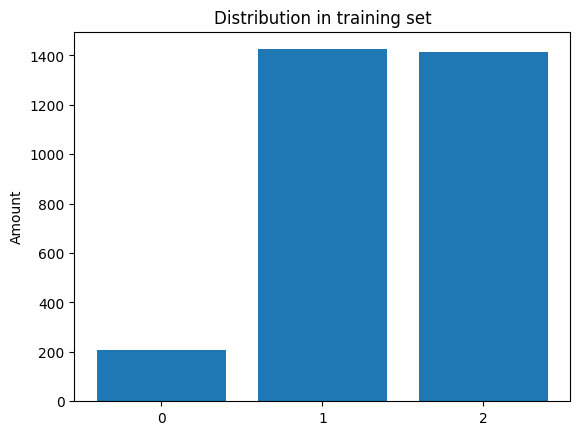

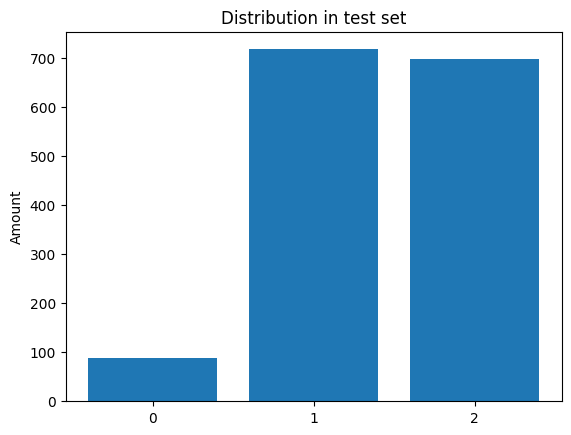

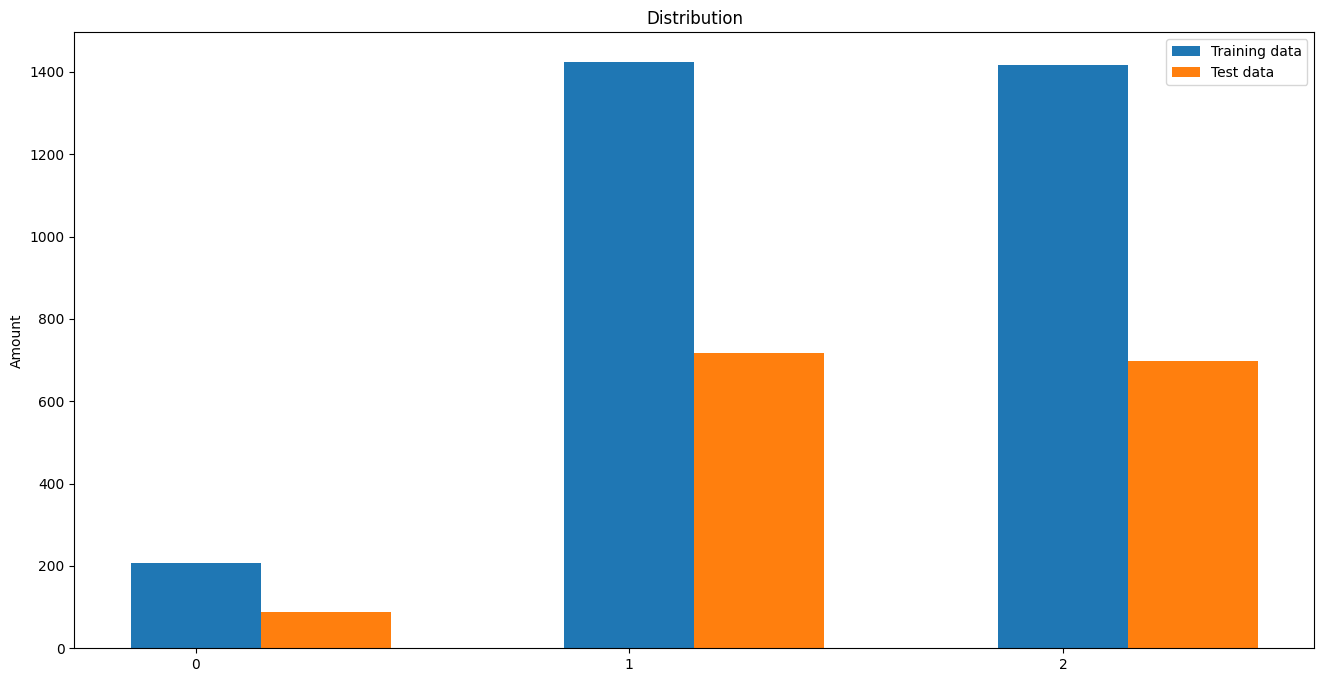


Example sequence from training set: [1 2 2 1 2 0 1 1 1 2 2 1 1 2 2 1 2 2 2 1] and its label: 2

Example sequence from training set: [1 1 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2] and its label: 2


Random forest classifier accuracy: 46.80%
Random forest classifier accuracy: 47.94%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4688 - loss: 0.9957 - val_accuracy: 0.4640 - val_loss: 0.9147
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4669 - loss: 0.9190 - val_accuracy: 0.4640 - val_loss: 0.8985
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4811 - loss: 0.9026 - val_accuracy: 0.4774 - val_loss: 0.8898
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4650 - loss: 0.8941 - val_accuracy: 0.4774 - val_loss: 0.8848
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4745 - loss: 0.8988 - val_accuracy: 0.4640 - val_loss: 0.8819
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4447 - loss: 0.9111 - val

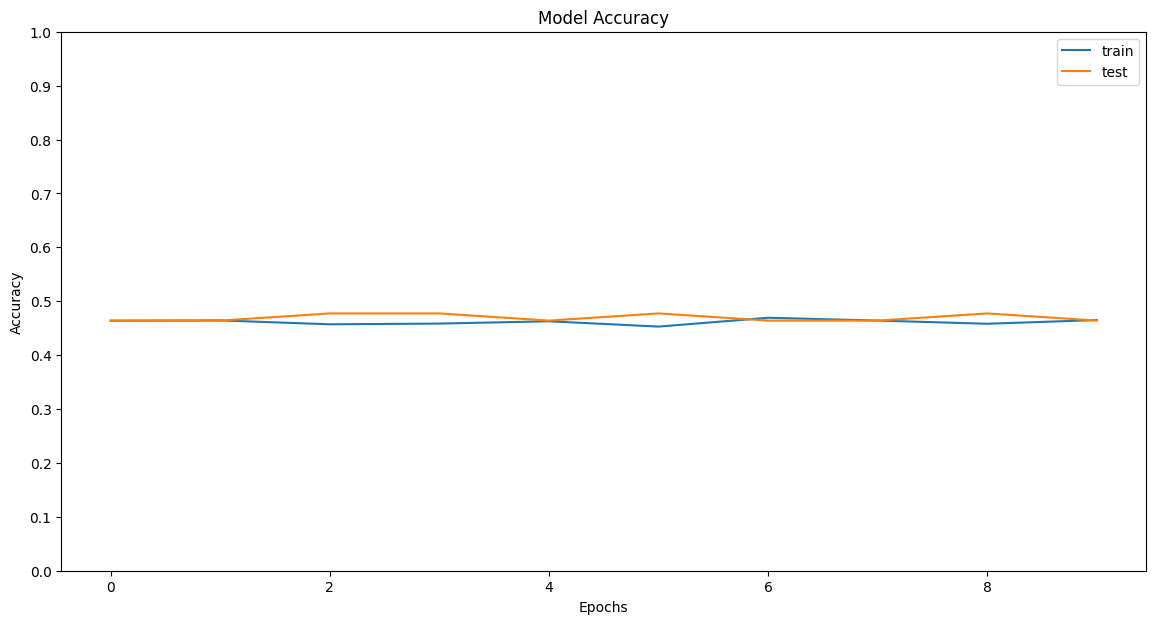

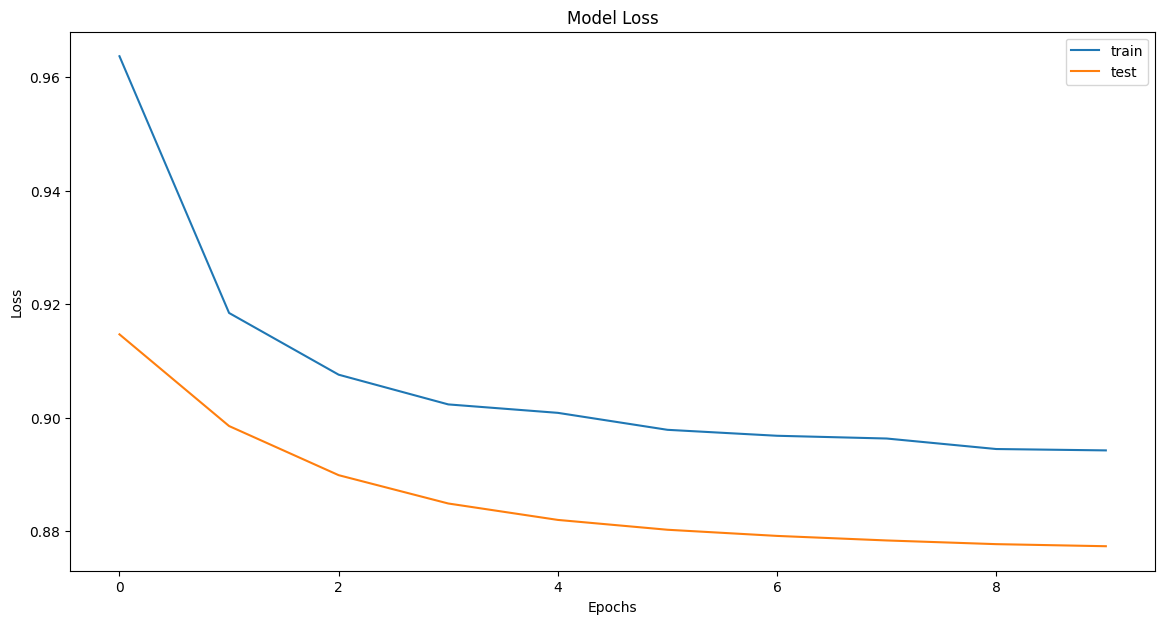

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 46.40%


For threshold set to 0.40, correctness is: 46.40%
For threshold set to 0.45, correctness is: 46.40%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3940 - loss: 1.0553 - val_accuracy: 0.4640 - val_loss: 0.9275
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4661 - loss: 0.9258 - val_accuracy: 0.4640 - val_loss: 0.9047
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4684 - loss: 0.9137 - val_accuracy: 0.4640 - val_loss: 0.8938
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 0.9110 - val_accuracy: 0.4640 - val_loss: 0.8873
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

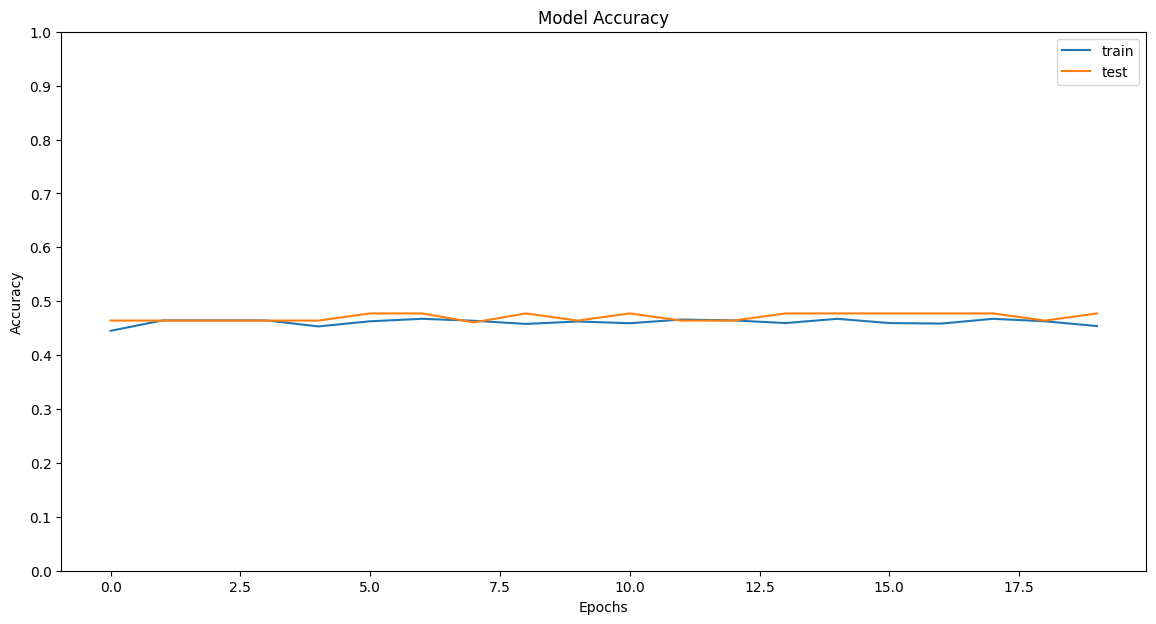

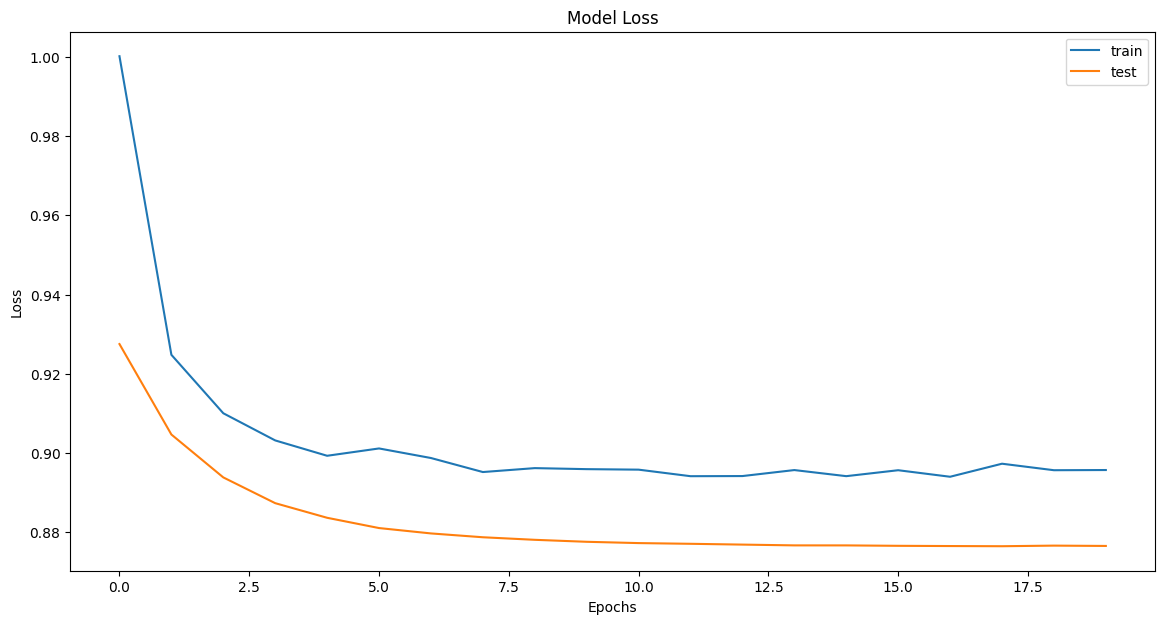

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 47.74%


For threshold set to 0.40, correctness is: 47.74%
For threshold set to 0.45, correctness is: 47.74%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2635 - loss: 1.1013 - val_accuracy: 0.4774 - val_loss: 0.9481
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9447 - val_accuracy: 0.4774 - val_loss: 0.9185
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4593 - loss: 0.9305 - val_accuracy: 0.4774 - val_loss: 0.9008
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4733 - loss: 0.9111 - val_accuracy: 0.4774 - val_loss: 0.8908
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

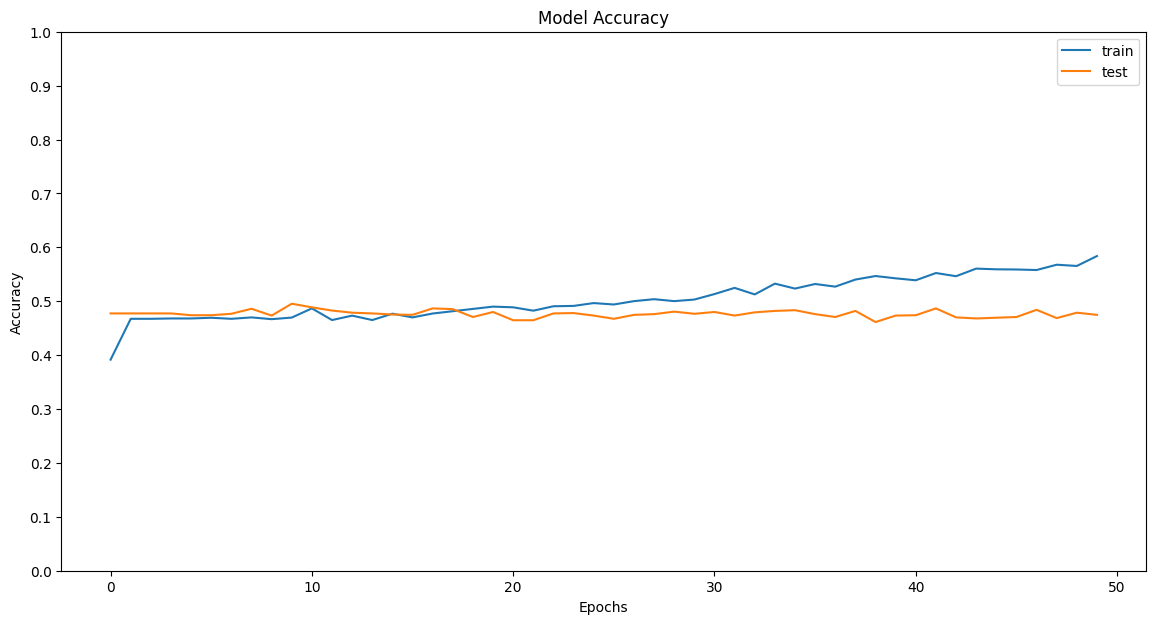

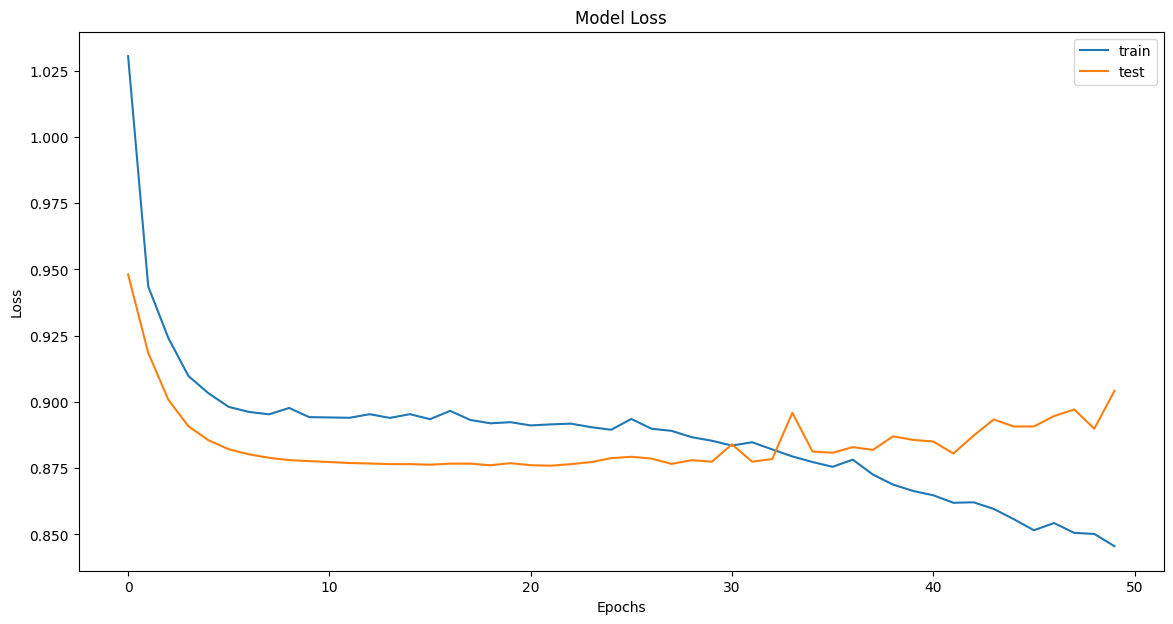

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 47.47%


For threshold set to 0.40, correctness is: 47.40%
For threshold set to 0.45, correctness is: 47.39%
For threshold set to 0.50, correctness is: 48.06%
For threshold set to 0.55, correctness is: 47.24%
For threshold set to 0.60, correctness is: 48.51%
For threshold set to 0.65, correctness is: 47.41%
For threshold set to 0.70, correctness is: 70.00%
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



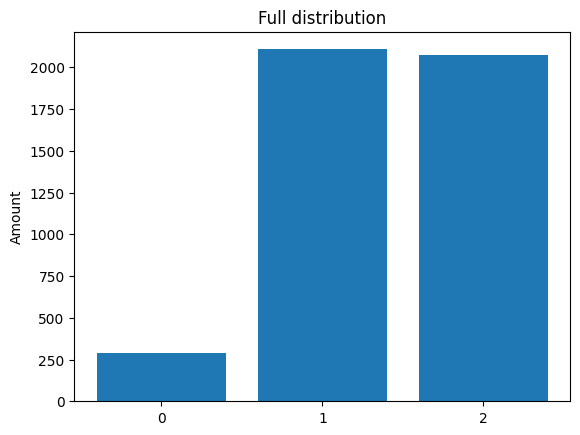

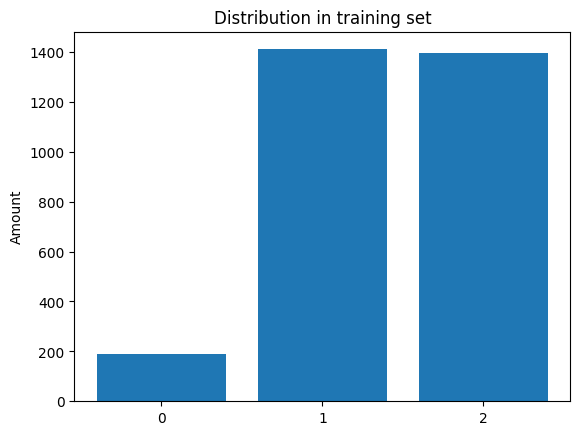

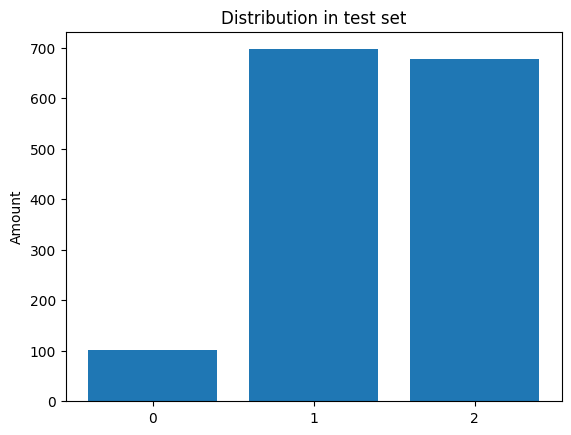

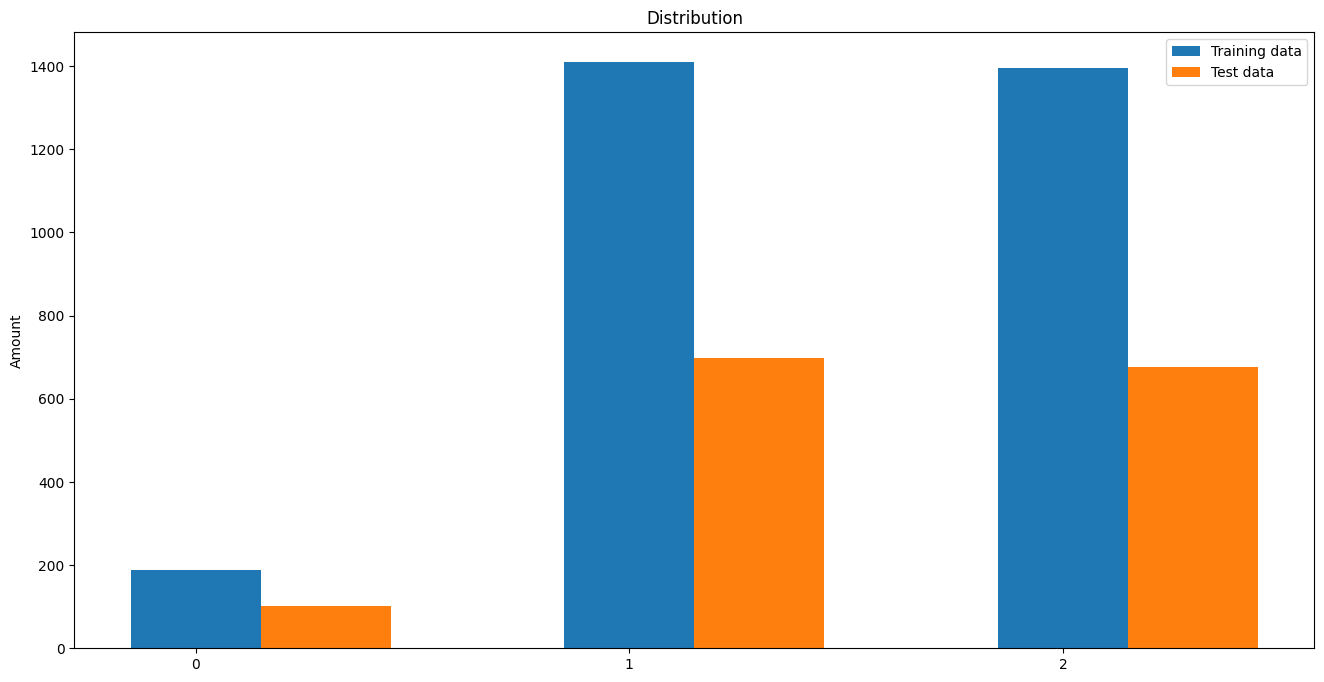


Example sequence from training set: [1 2 1 1 0 1 1 1 1 2 1 2 1 1 2 2 2 1 1 2 2 2 1 2 2 1 2 1 1 1 2 1 1 1 1 1 1
 2 2 2] and its label: 2

Example sequence from training set: [2 1 0 2 2 2 2 0 2 1 1 2 1 1 1 0 1 2 1 2 2 2 1 1 2 2 1 0 1 2 1 1 2 2 2 1 2
 1 2 1] and its label: 1


Random forest classifier accuracy: 46.75%
Random forest classifier accuracy: 47.09%


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4173 - loss: 1.0610 - val_accuracy: 0.4587 - val_loss: 0.9836
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 0.9658 - val_accuracy: 0.4587 - val_loss: 0.9487
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4859 - loss: 0.9368 - val_accuracy: 0.4587 - val_loss: 0.9270
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 0.9209 - val_accuracy: 0.4587 - val_loss: 0.9141
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4698 - loss: 0.9047 - val_accuracy: 0.4587 - val_loss: 0.9063
Epoch 6

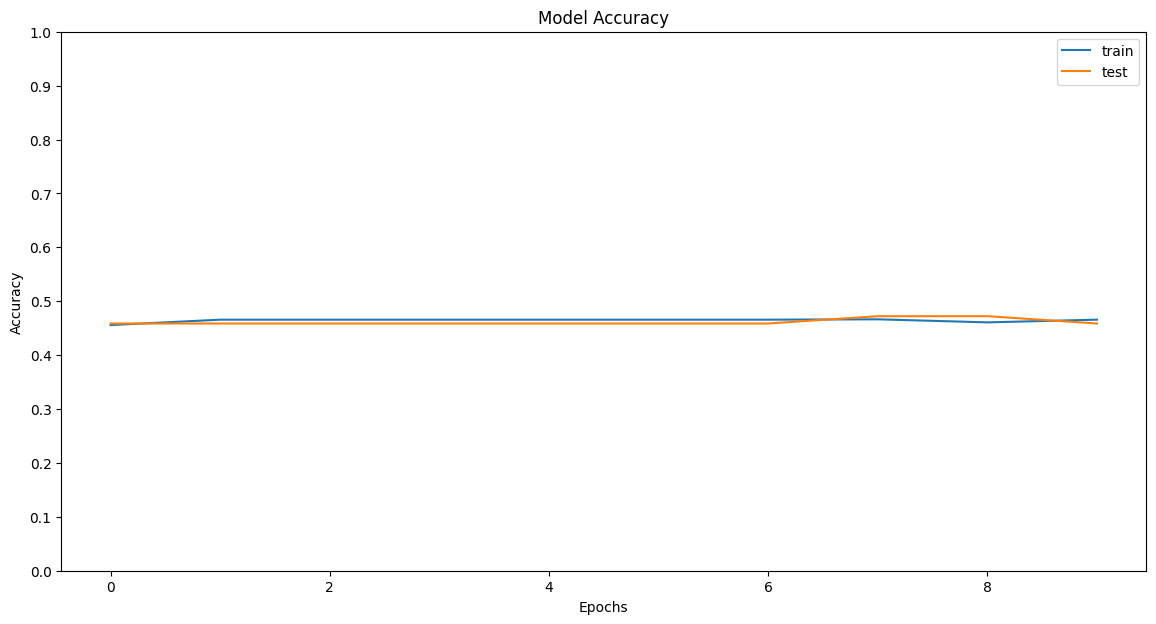

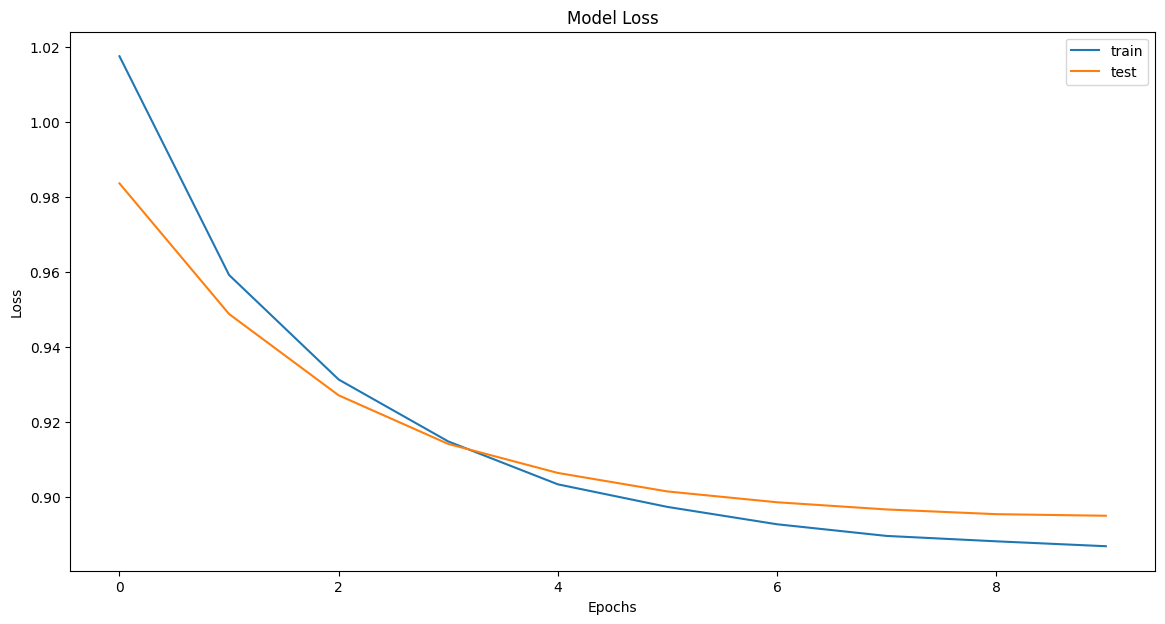

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 45.87%


For threshold set to 0.40, correctness is: 45.87%
For threshold set to 0.45, correctness is: 45.87%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4620 - loss: 1.0034 - val_accuracy: 0.4722 - val_loss: 0.9313
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4683 - loss: 0.9303 - val_accuracy: 0.4722 - val_loss: 0.9134
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4723 - loss: 0.9035 - val_accuracy: 0.4722 - val_loss: 0.9049
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4814 - loss: 0.8883 - val_accuracy: 0.4688 - val_loss: 0.8997
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

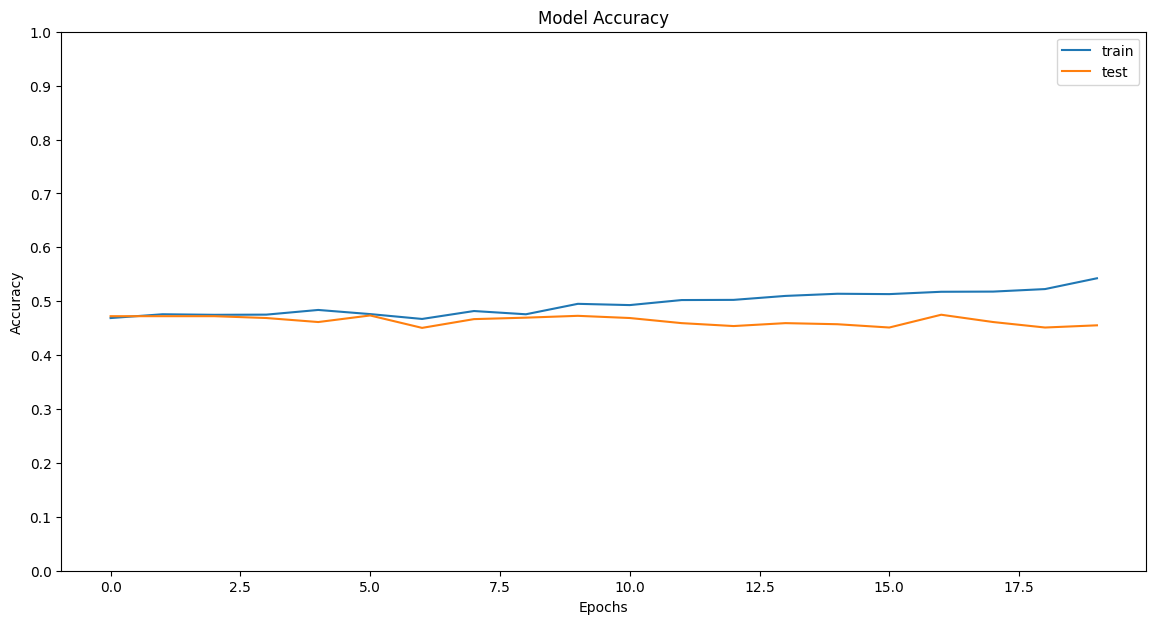

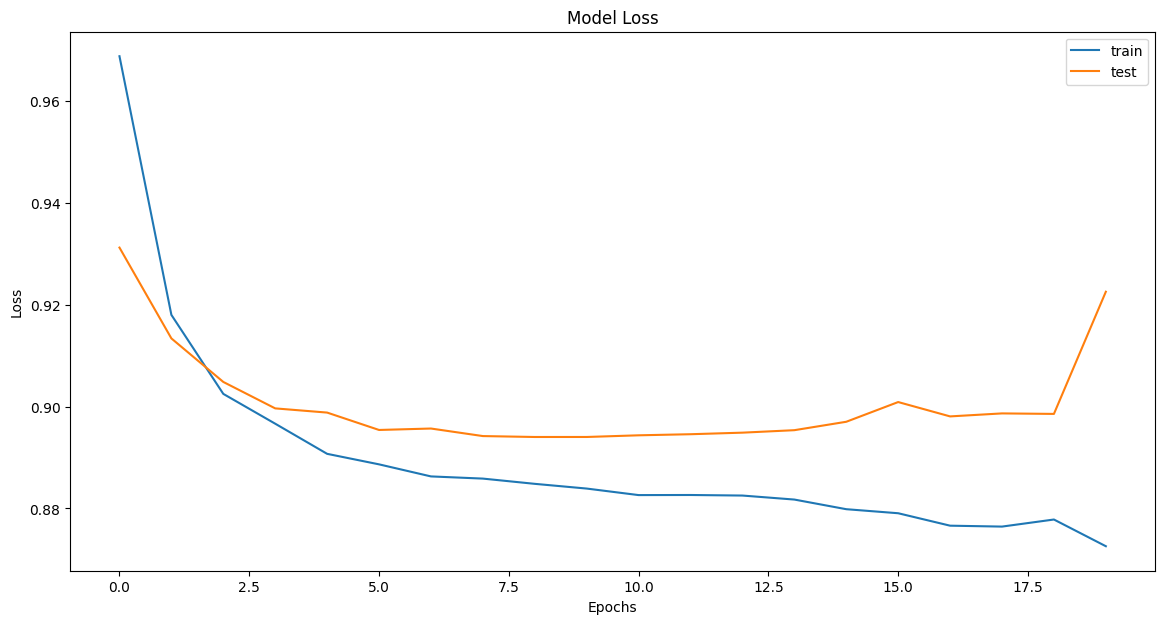

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 45.53%


For threshold set to 0.40, correctness is: 45.53%
For threshold set to 0.45, correctness is: 45.53%
For threshold set to 0.50, correctness is: 44.81%
For threshold set to 0.55, correctness is: 44.09%
For threshold set to 0.60, correctness is: 43.09%
For threshold set to 0.65, correctness is: 32.26%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4676 - loss: 1.0290 - val_accuracy: 0.4722 - val_loss: 0.9145
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4990 - loss: 0.8922 - val_accuracy: 0.4722 - val_loss: 0.9048
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4535 - loss: 0.8923 - val_accuracy: 0.4722 - val_loss: 0.9002
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4765 - loss: 0.8859 - val_accuracy: 0.4722 - val_lo

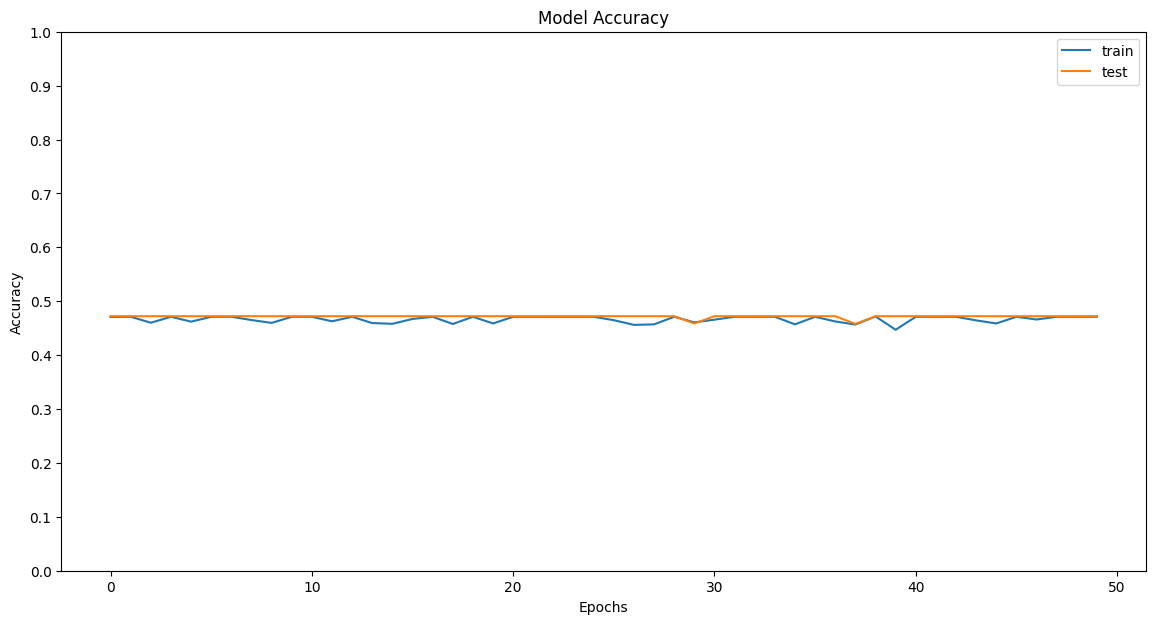

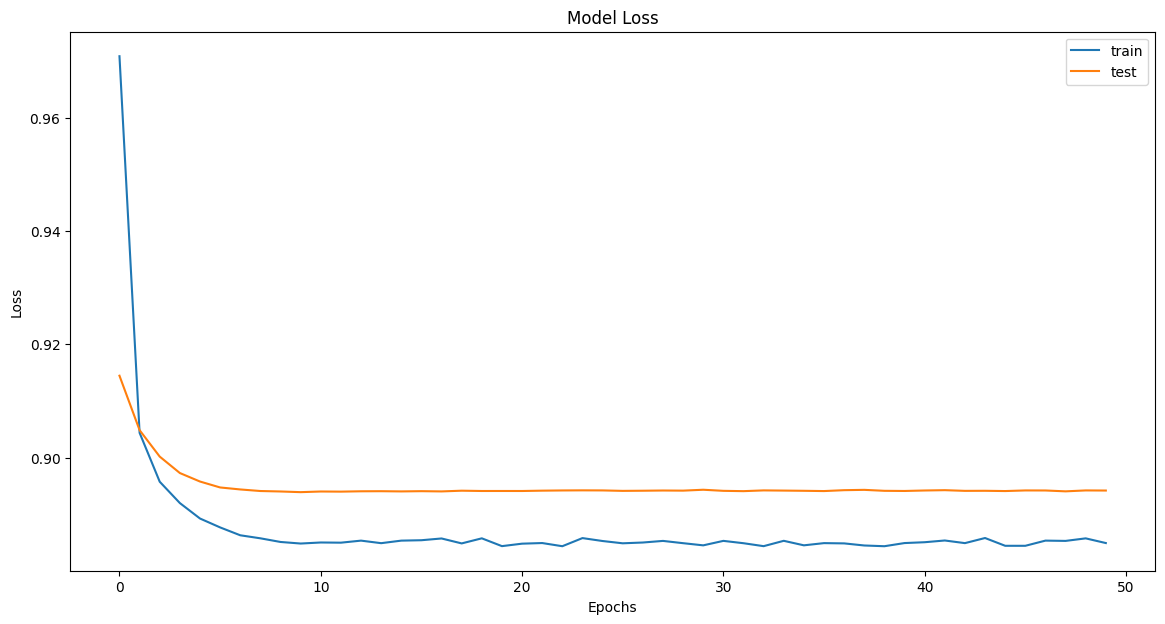

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Modal accuracy on test set: 47.22%


For threshold set to 0.40, correctness is: 47.22%
For threshold set to 0.45, correctness is: 47.22%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 20, Epoch: 20, Accuracy: 47.74%
Chunk size: 20, Epoch: 50, Accuracy: 47.47%
Chunk size: 2, Epoch: 10, Accuracy: 47.31%

Data from file: csgofastcom.csv


Example sequence: ['red', 'red', 'red', 'red', 'red', 'green', 'black', 'red', 'black', 'red', 'red', 'red']

black: Counter({1: 416, 2: 181, 3: 79, 4: 39, 6: 12, 5: 10, 7: 3, 8: 2, 9: 2})
red: Counter({1: 407, 2: 178, 3: 78, 4: 42, 5: 23, 6: 12, 7: 2, 9: 1, 8: 1})
green: Counter({1: 165, 2: 6})




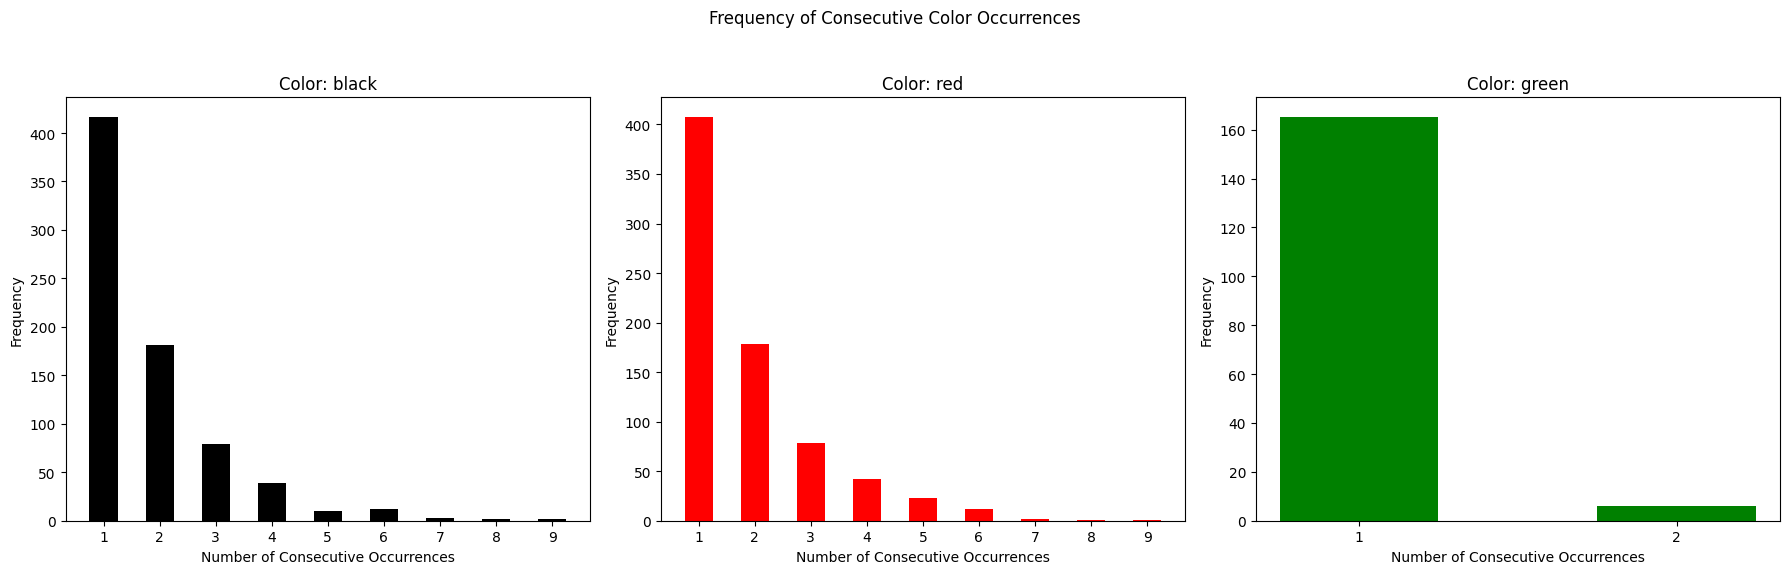


(2,)



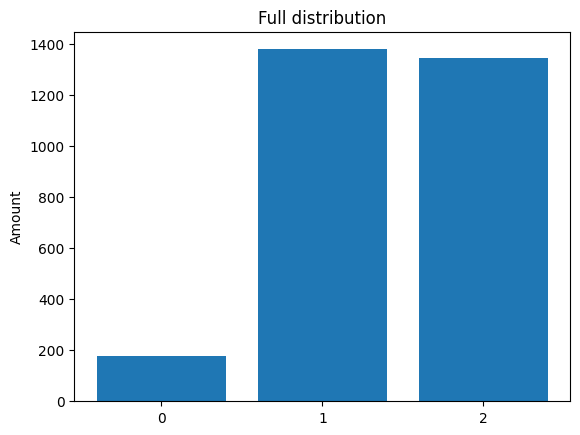

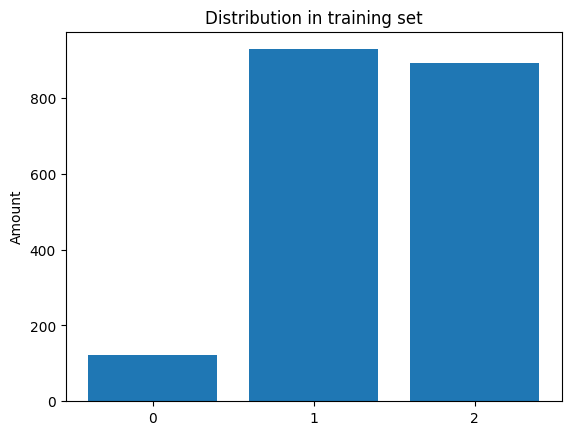

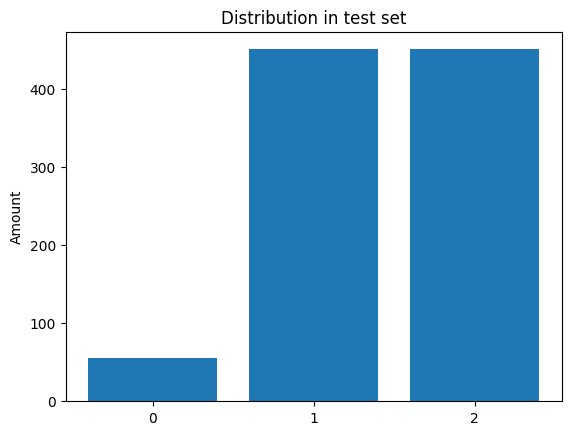

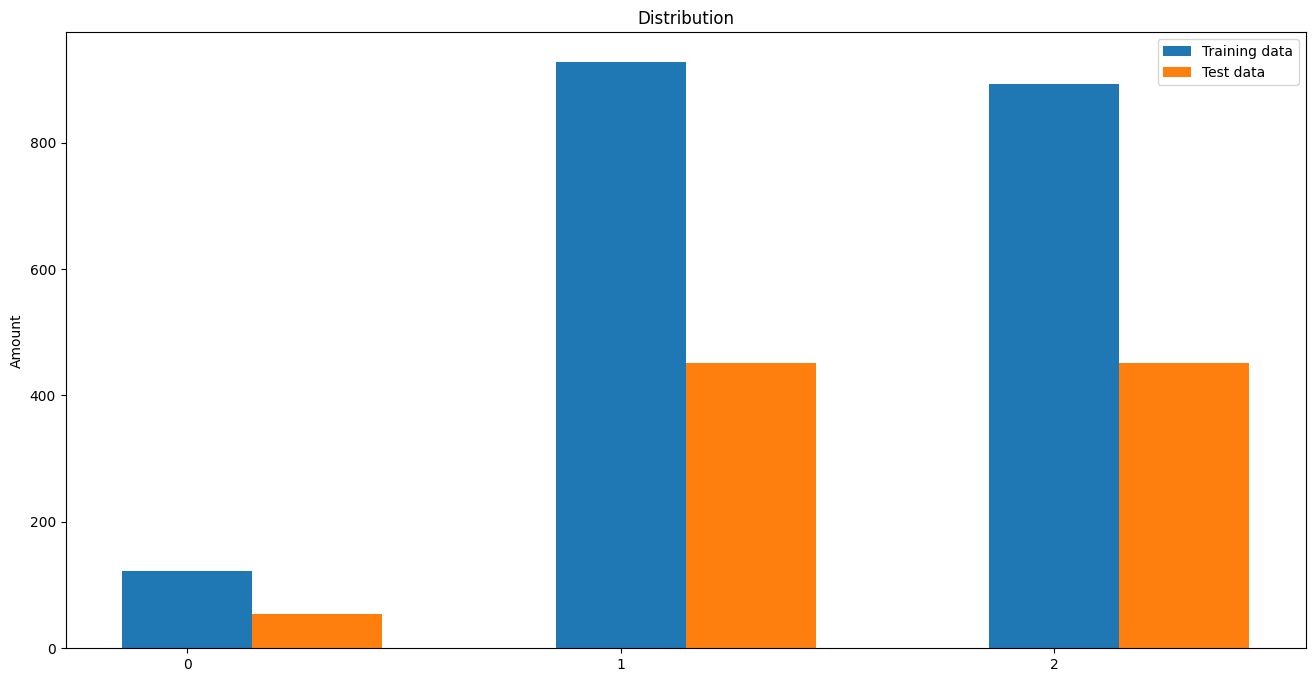


Example sequence from training set: [1 1] and its label: 1

Example sequence from training set: [2 1] and its label: 1


Random forest classifier accuracy: 47.44%
Random forest classifier accuracy: 47.23%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4484 - loss: 0.9987 - val_accuracy: 0.4713 - val_loss: 0.9366
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4456 - loss: 0.9396 - val_accuracy: 0.4796 - val_loss: 0.9116
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9111 - val_accuracy: 0.4525 - val_loss: 0.8996
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4851 - loss: 0.9030 - val_accuracy: 0.4734 - val_loss: 0.8931
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4928 - loss: 0.8898 - val_accuracy: 0.4786 - val_loss: 0.8864
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: 0.8924 - val_accuracy: 0.4754 - val_loss: 0.8843
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━

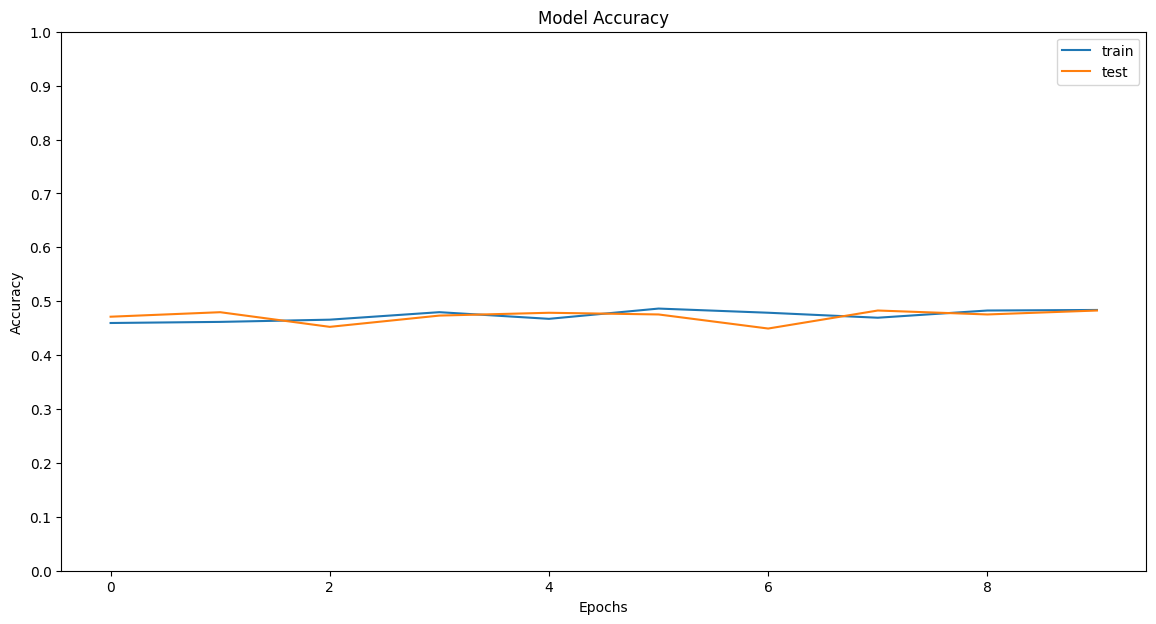

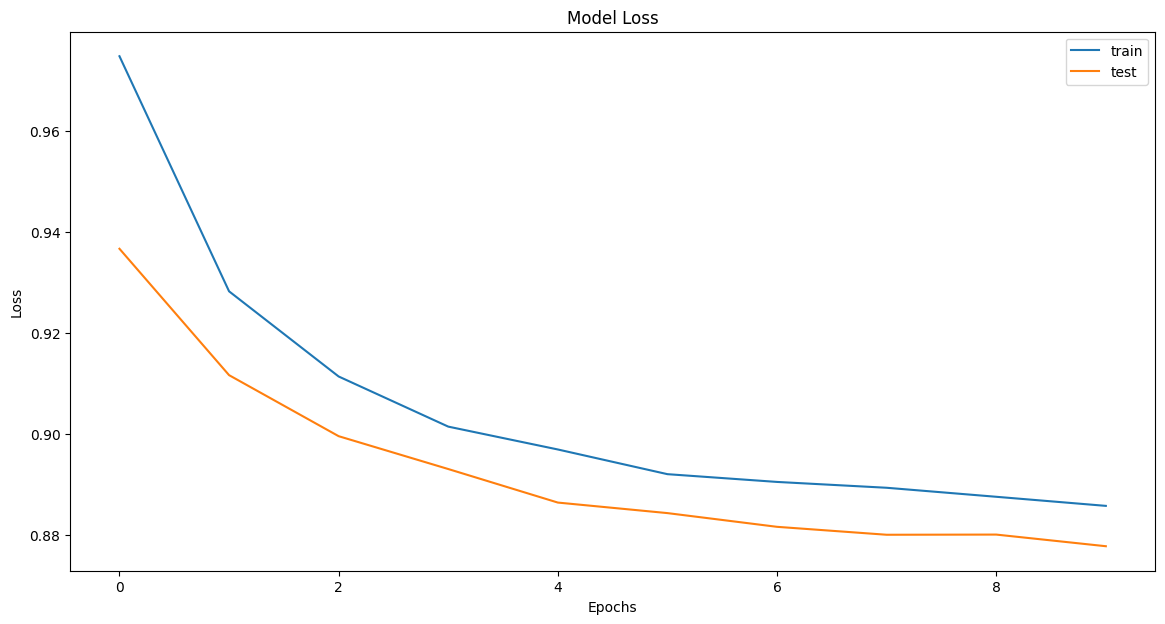

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 48.28%


For threshold set to 0.40, correctness is: 48.28%
For threshold set to 0.45, correctness is: 48.28%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4924 - loss: 1.0109 - val_accuracy: 0.4639 - val_loss: 0.9443
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4645 - loss: 0.9356 - val_accuracy: 0.4619 - val_loss: 0.8906
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4442 - loss: 0.8981 - val_accuracy: 0.4598 - val_loss: 0.8811
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4671 - loss: 0.8742 - val_accuracy: 0.4713 - val_loss: 0.8787
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

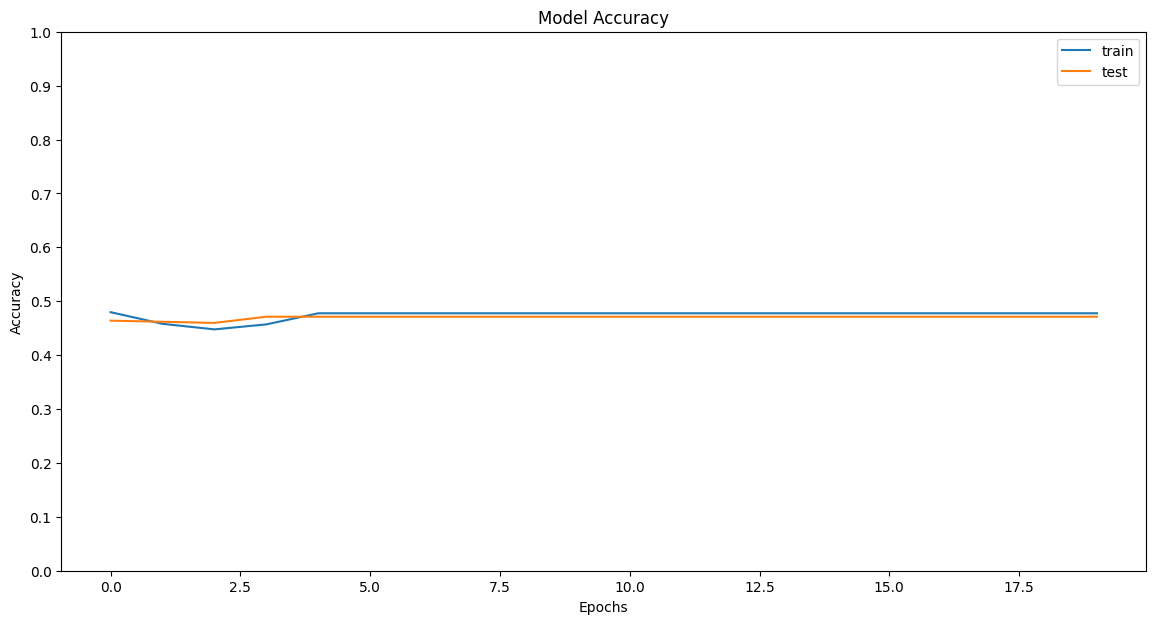

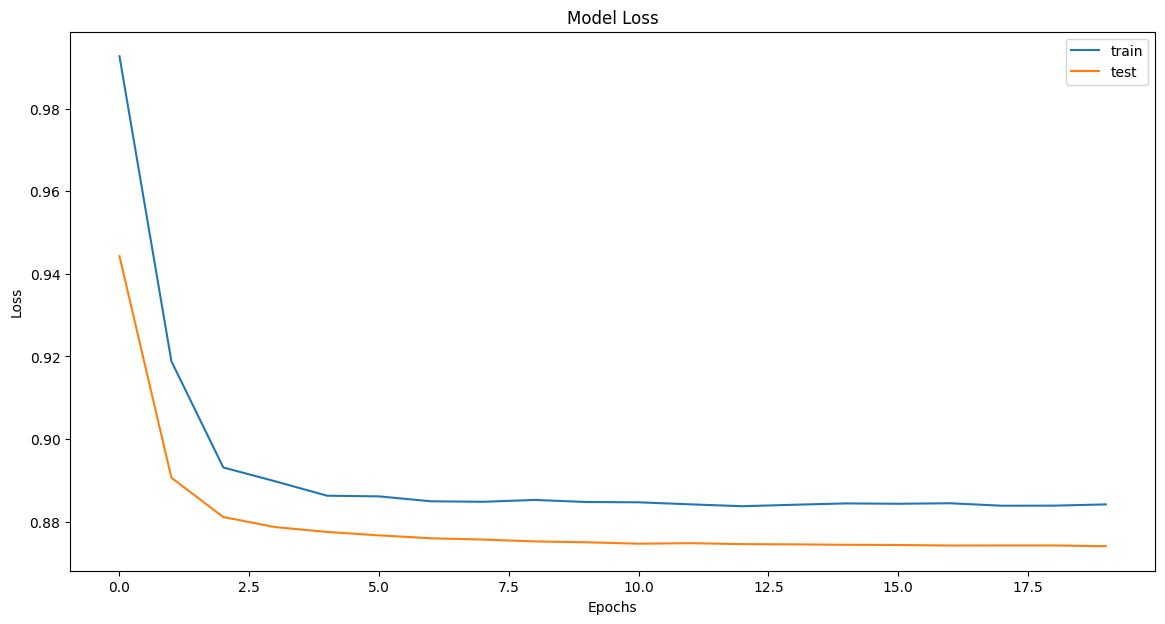

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.13%


For threshold set to 0.40, correctness is: 47.13%
For threshold set to 0.45, correctness is: 47.13%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4933 - loss: 1.0553 - val_accuracy: 0.4713 - val_loss: 0.9954
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4769 - loss: 0.9824 - val_accuracy: 0.4713 - val_loss: 0.9388
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 0.9409 - val_accuracy: 0.4807 - val_loss: 0.9124
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 0.9141 - val_accuracy: 0.4828 - val_loss: 0.9002
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

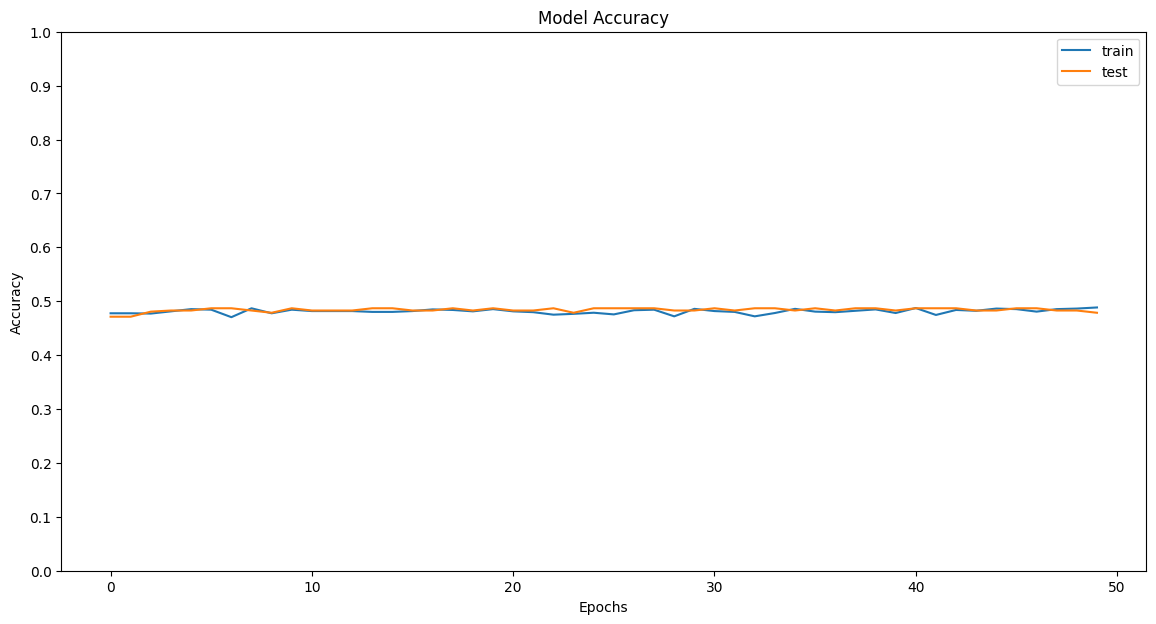

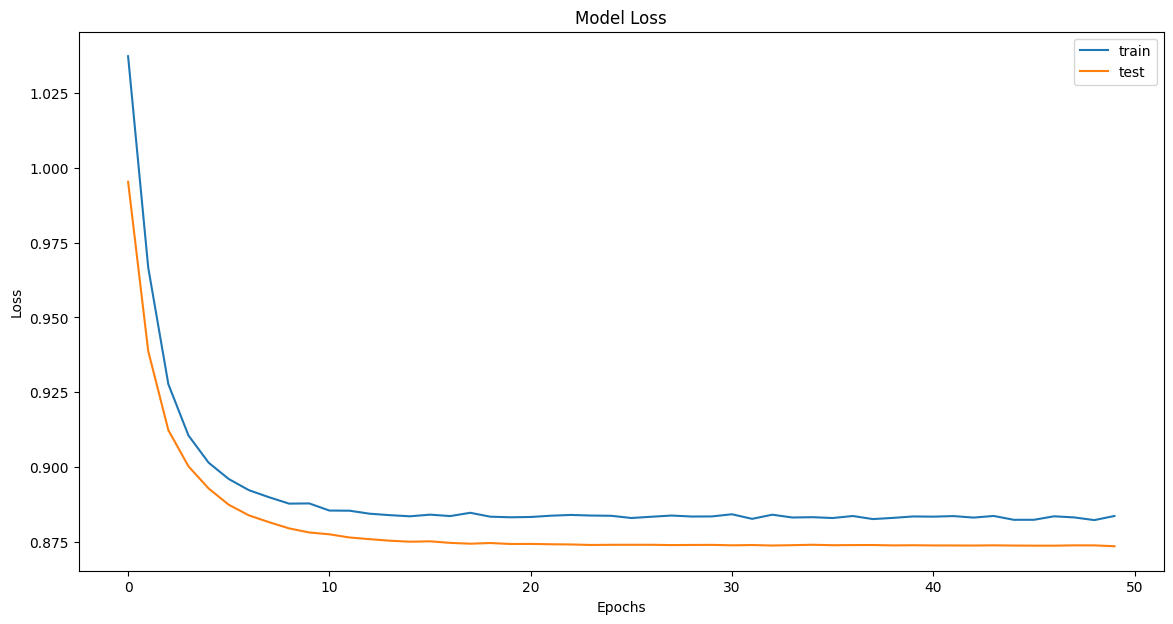

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.86%


For threshold set to 0.40, correctness is: 47.86%
For threshold set to 0.45, correctness is: 47.86%
For threshold set to 0.50, correctness is: 56.36%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



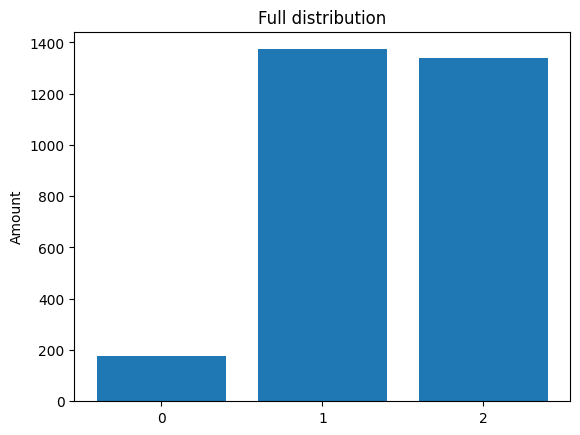

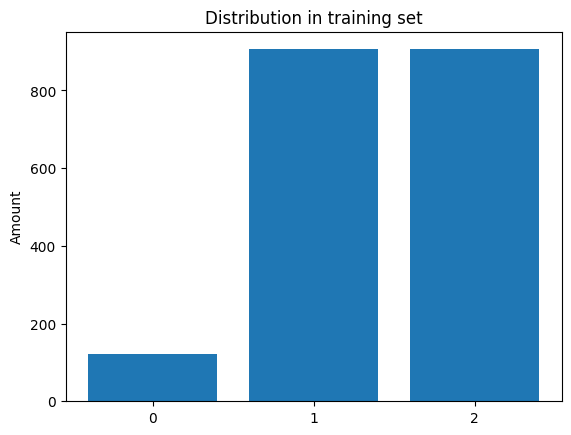

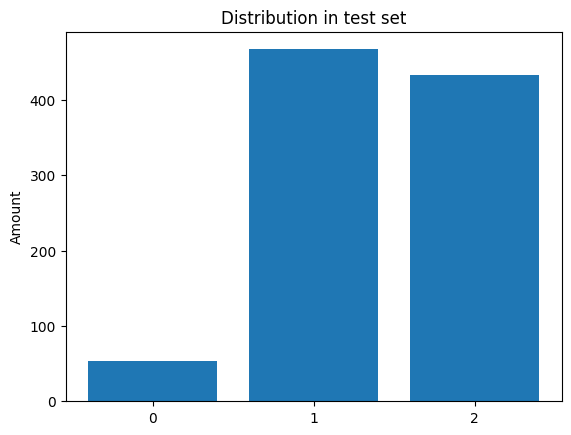

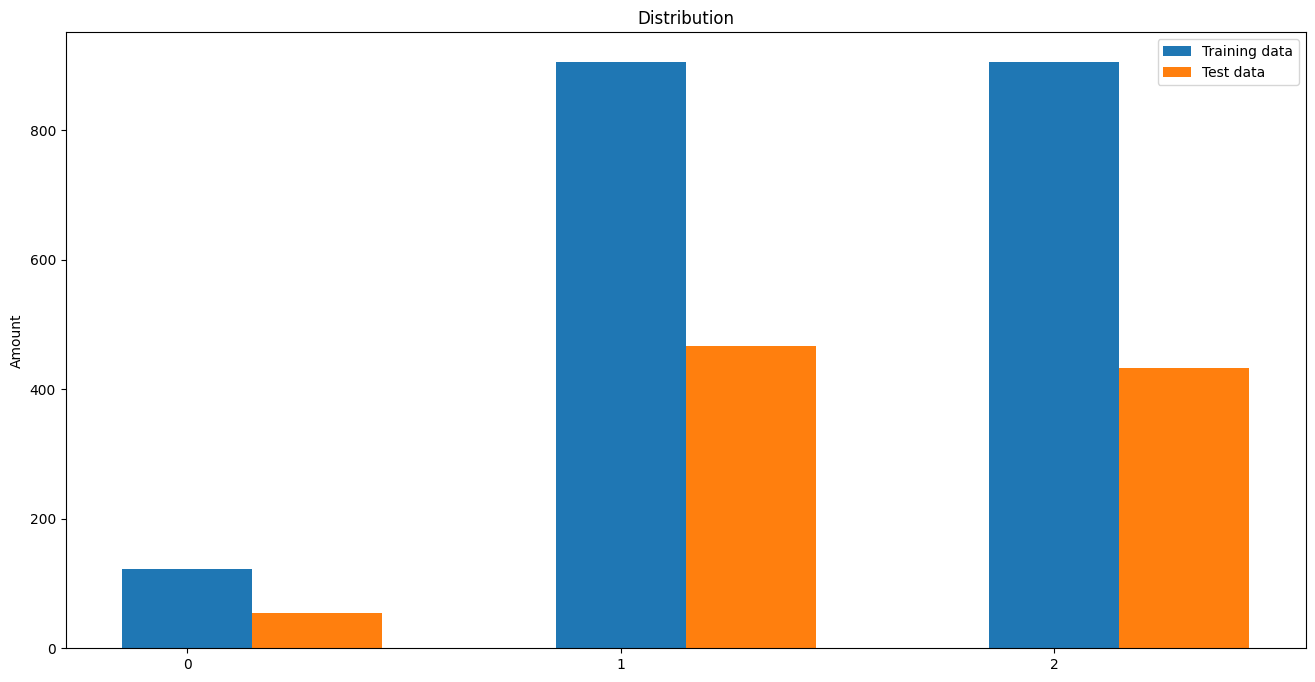


Example sequence from training set: [1 1 0 2 0] and its label: 1

Example sequence from training set: [1 1 2 2 2] and its label: 1


Random forest classifier accuracy: 47.90%
Random forest classifier accuracy: 46.96%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4917 - loss: 1.0201 - val_accuracy: 0.4895 - val_loss: 0.9461
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4663 - loss: 0.9507 - val_accuracy: 0.4528 - val_loss: 0.9084
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4522 - loss: 0.9173 - val_accuracy: 0.4528 - val_loss: 0.8975
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4903 - loss: 0.8925 - val_accuracy: 0.4497 - val_loss: 0.8894
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4546 - loss: 0.8974 - val_accuracy: 0.4497 - val_loss: 0.8845
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4716 - loss: 0.8875 - val_accuracy: 0.4539 - val_loss: 0.8813
Epoch 7/10
61/61 ━━━━━━

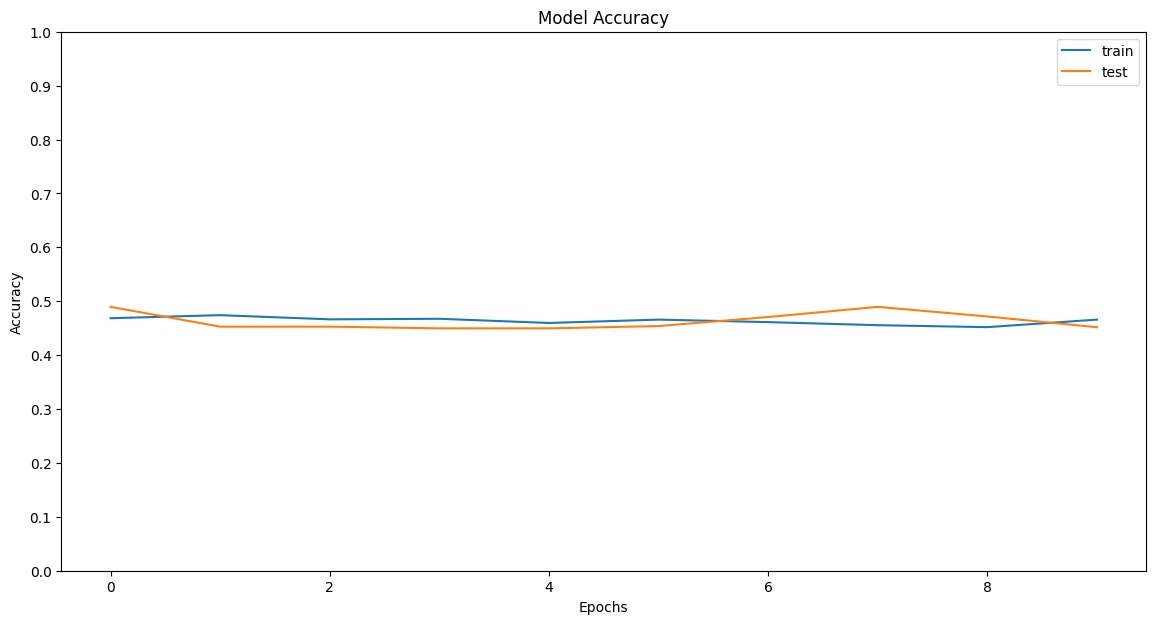

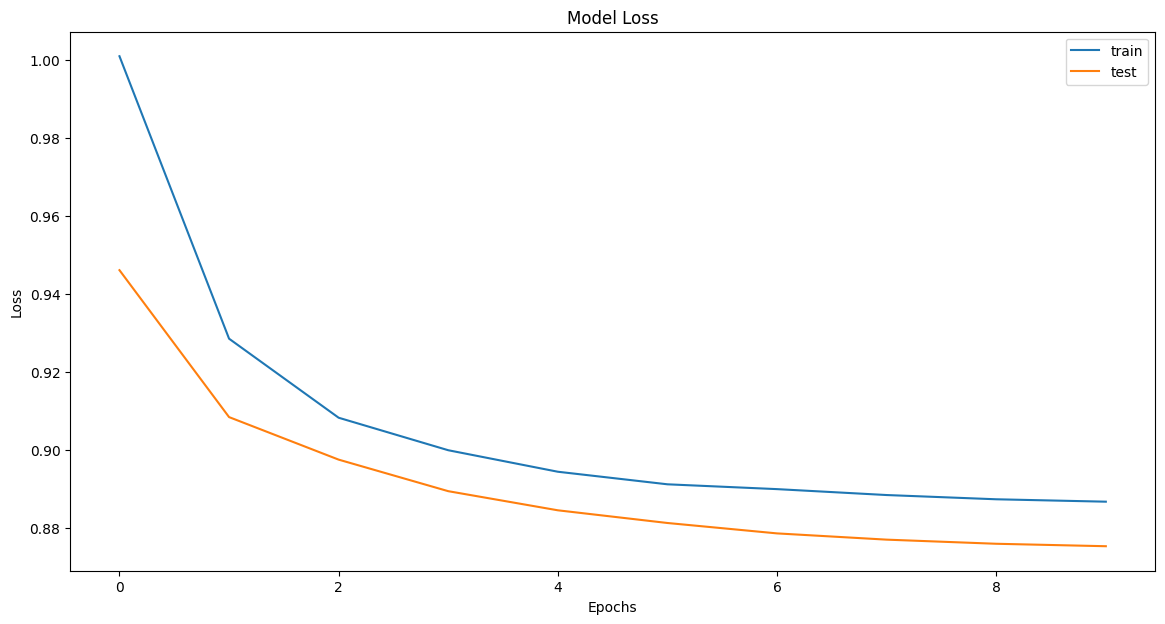

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 45.18%


For threshold set to 0.40, correctness is: 45.18%
For threshold set to 0.45, correctness is: 45.18%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4862 - loss: 1.0431 - val_accuracy: 0.4895 - val_loss: 0.9454
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.9298 - val_accuracy: 0.4486 - val_loss: 0.9068
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4604 - loss: 0.9092 - val_accuracy: 0.4507 - val_loss: 0.8965
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4580 - loss: 0.9101 - val_accuracy: 0.4518 - val_loss: 0.8902
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

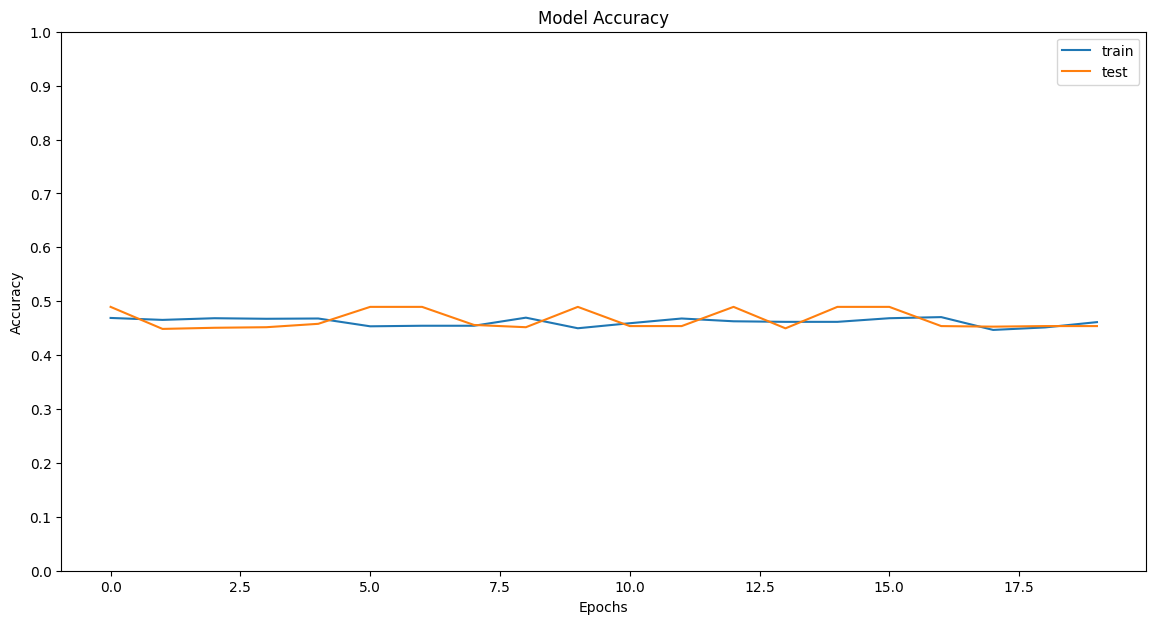

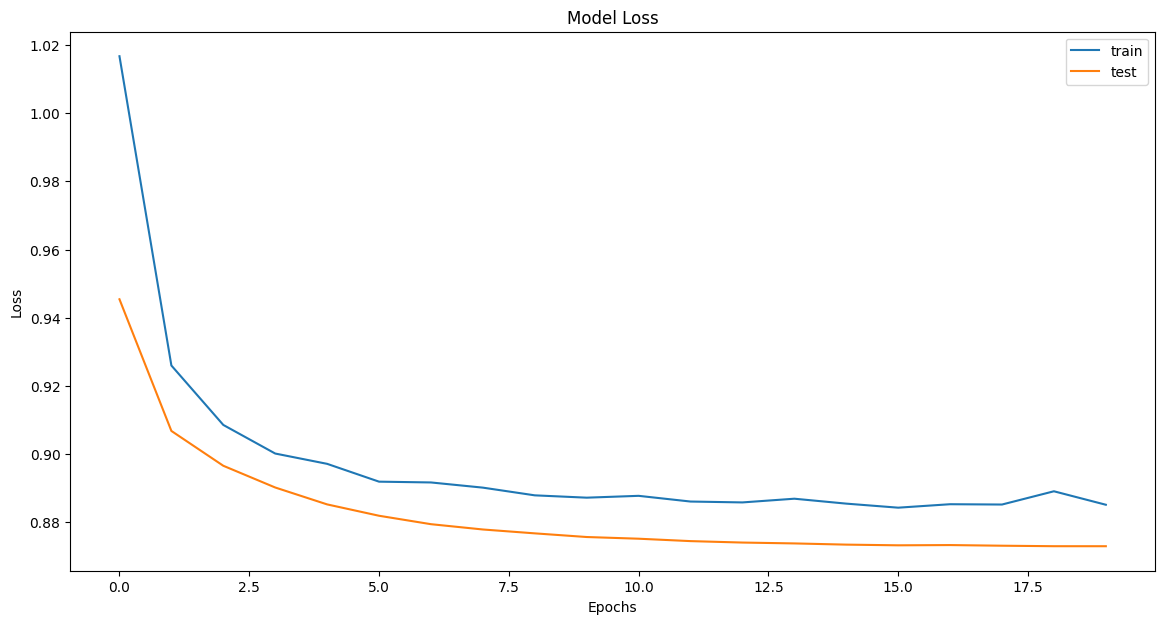

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 45.39%


For threshold set to 0.40, correctness is: 45.39%
For threshold set to 0.45, correctness is: 45.39%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1431 - loss: 1.1361 - val_accuracy: 0.4895 - val_loss: 1.0026
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4888 - loss: 0.9859 - val_accuracy: 0.4895 - val_loss: 0.9410
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4726 - loss: 0.9464 - val_accuracy: 0.4895 - val_loss: 0.9200
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4666 - loss: 0.9273 - val_accuracy: 0.4895 - val_loss: 0.9073
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

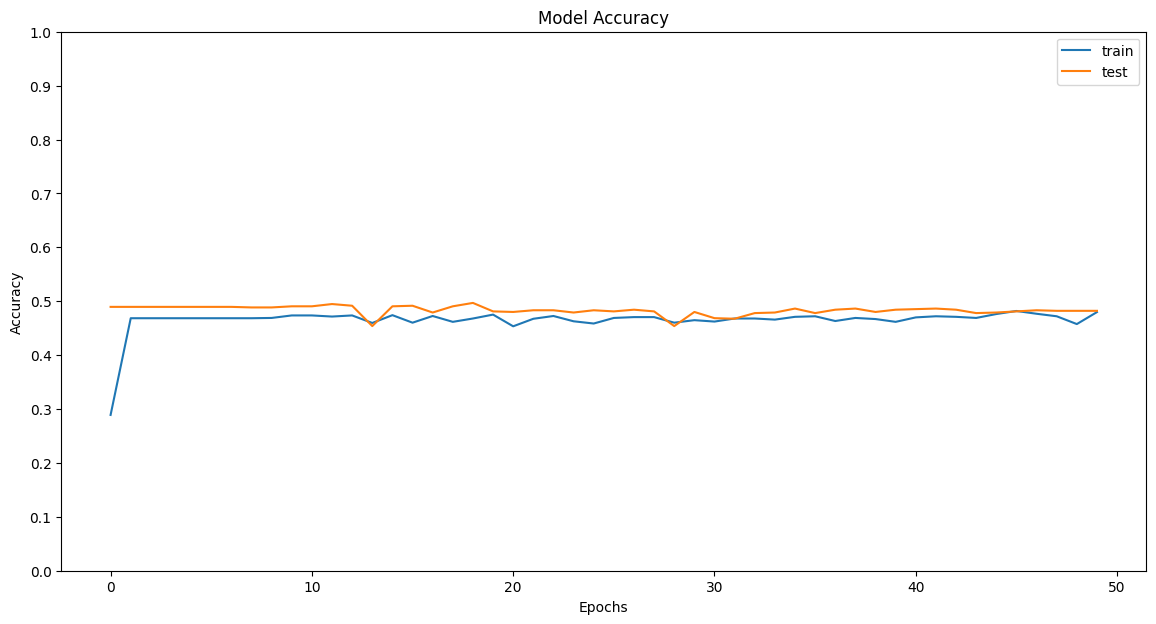

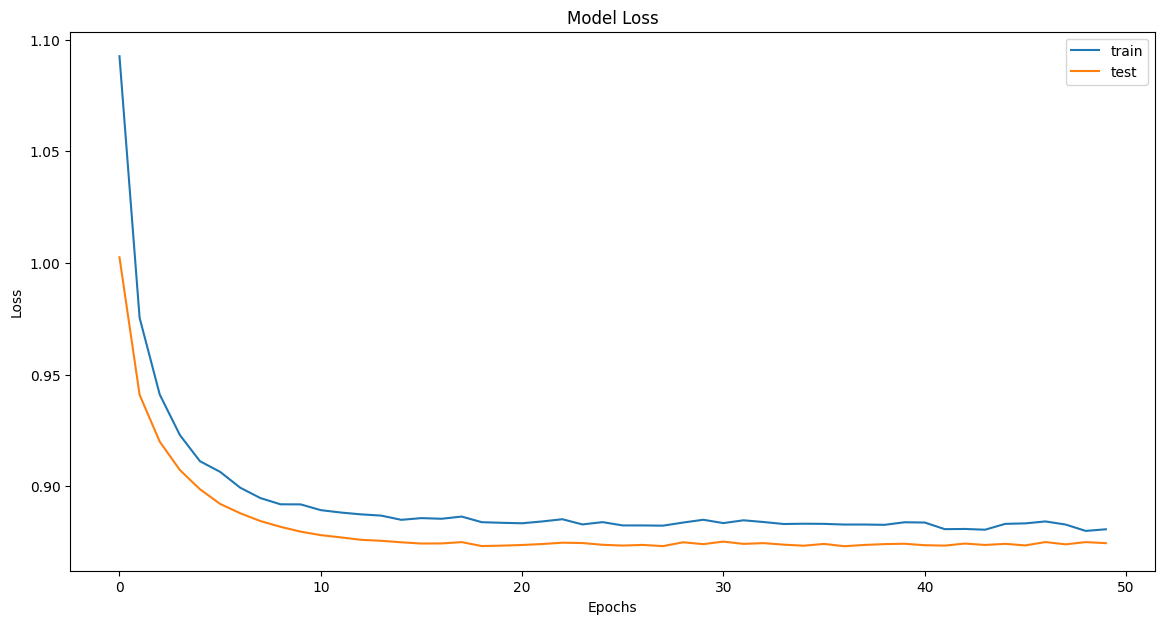

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 48.22%


For threshold set to 0.40, correctness is: 48.22%
For threshold set to 0.45, correctness is: 47.93%
For threshold set to 0.50, correctness is: 57.14%
For threshold set to 0.55, correctness is: 50.00%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



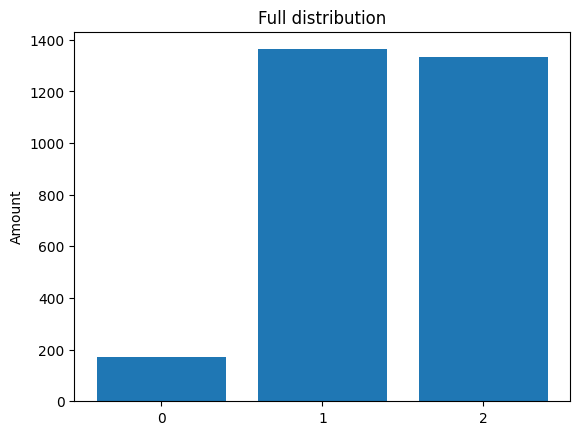

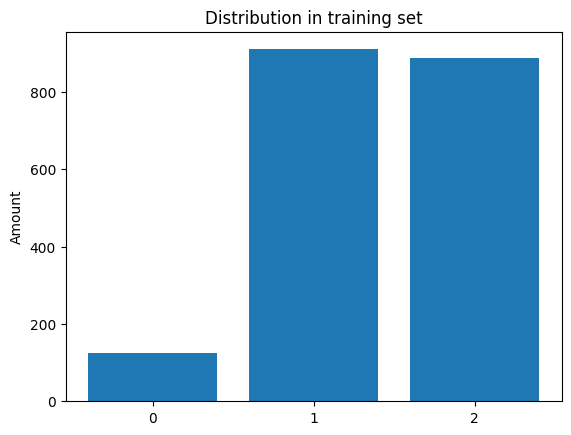

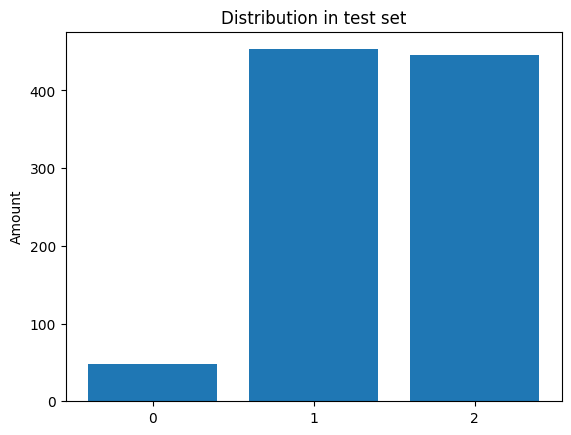

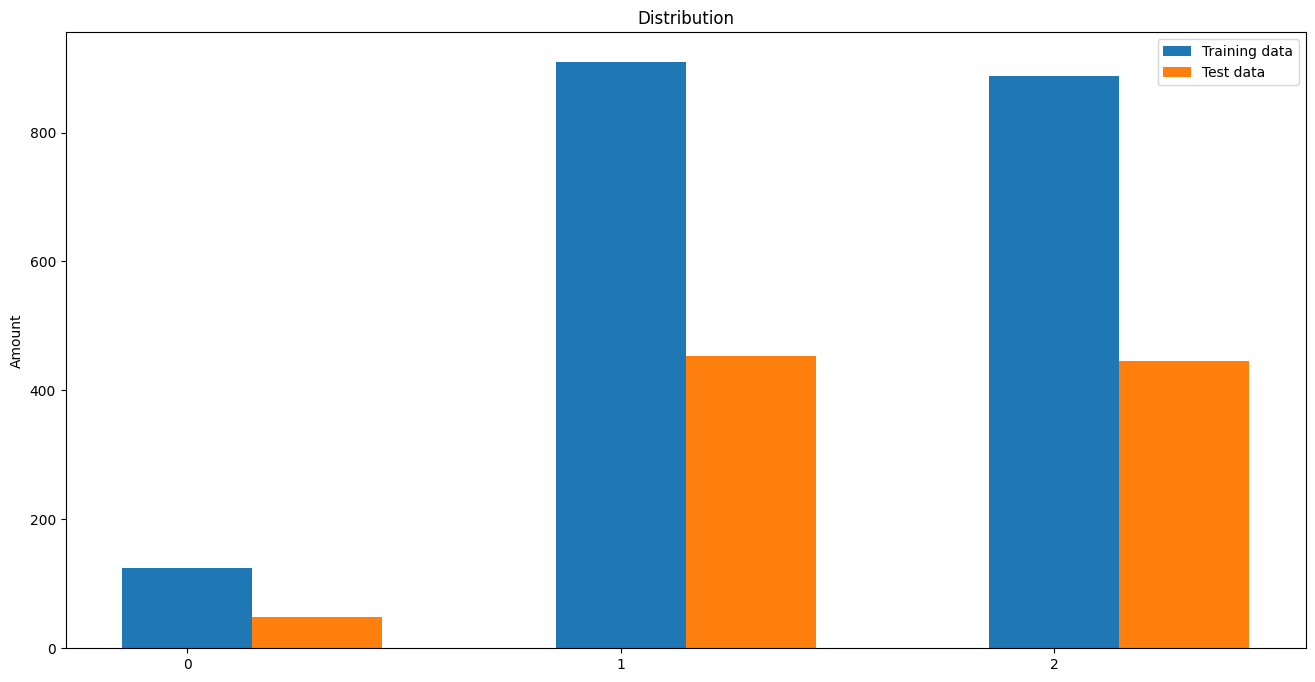


Example sequence from training set: [2 2 2 1 2 1 2 2 1 2] and its label: 1

Example sequence from training set: [1 1 1 2 1 1 2 1 1 1] and its label: 1


Random forest classifier accuracy: 46.99%
Random forest classifier accuracy: 47.10%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4609 - loss: 1.0582 - val_accuracy: 0.4773 - val_loss: 0.9974
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4838 - loss: 0.9865 - val_accuracy: 0.4762 - val_loss: 0.9248
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4605 - loss: 0.9390 - val_accuracy: 0.4889 - val_loss: 0.9029
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4756 - loss: 0.9097 - val_accuracy: 0.4794 - val_loss: 0.8915
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4874 - loss: 0.9072 - val_accuracy: 0.4847 - val_loss: 0.8836
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4380 - loss: 0.9076 - val_accuracy: 0.4731 - val_loss: 0.8782
Epo

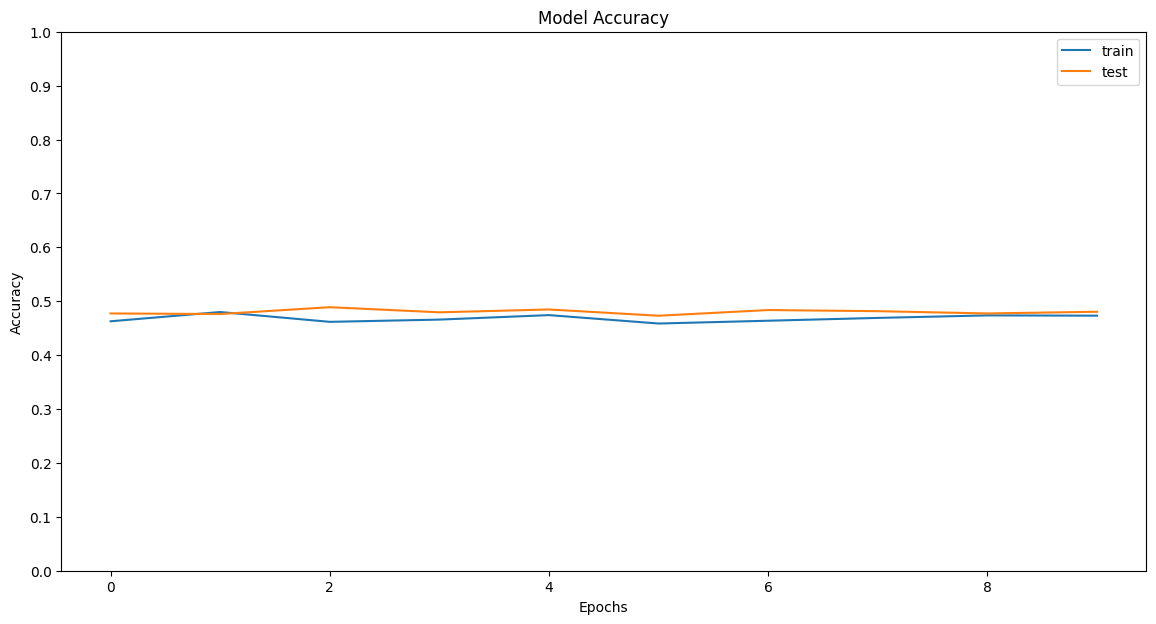

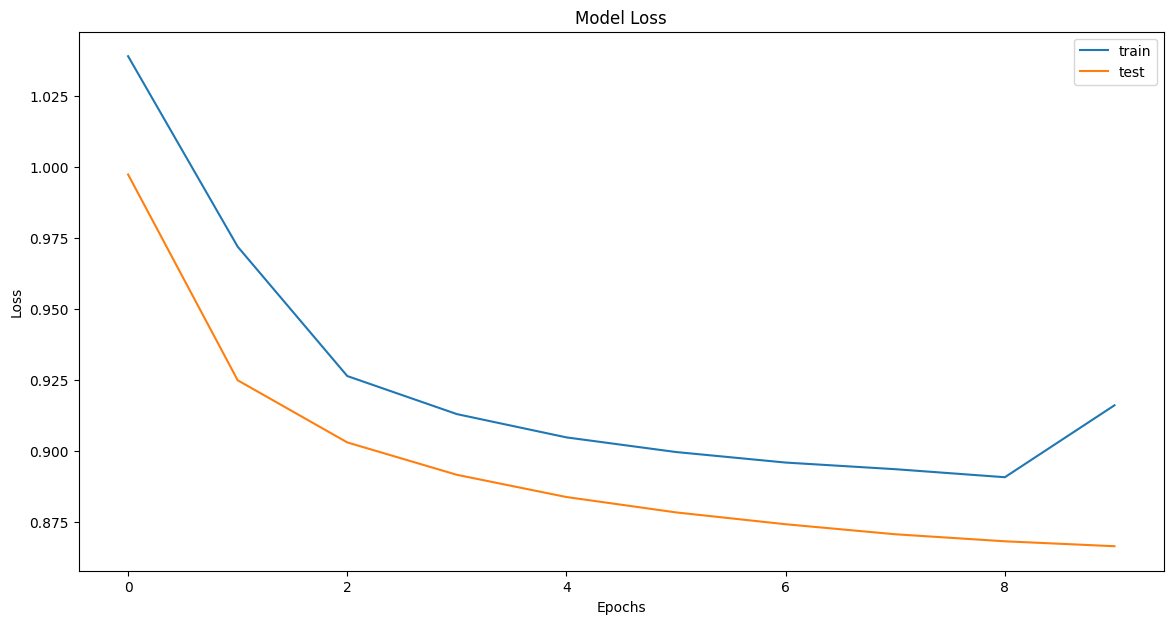

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 48.05%


For threshold set to 0.40, correctness is: 48.05%
For threshold set to 0.45, correctness is: 48.05%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4734 - loss: 1.0265 - val_accuracy: 0.4784 - val_loss: 0.9230
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4767 - loss: 0.9208 - val_accuracy: 0.4784 - val_loss: 0.8973
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4851 - loss: 0.9058 - val_accuracy: 0.4784 - val_loss: 0.8873
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4767 - loss: 0.9096 - val_accuracy: 0.4784 - val_loss: 0.8804
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

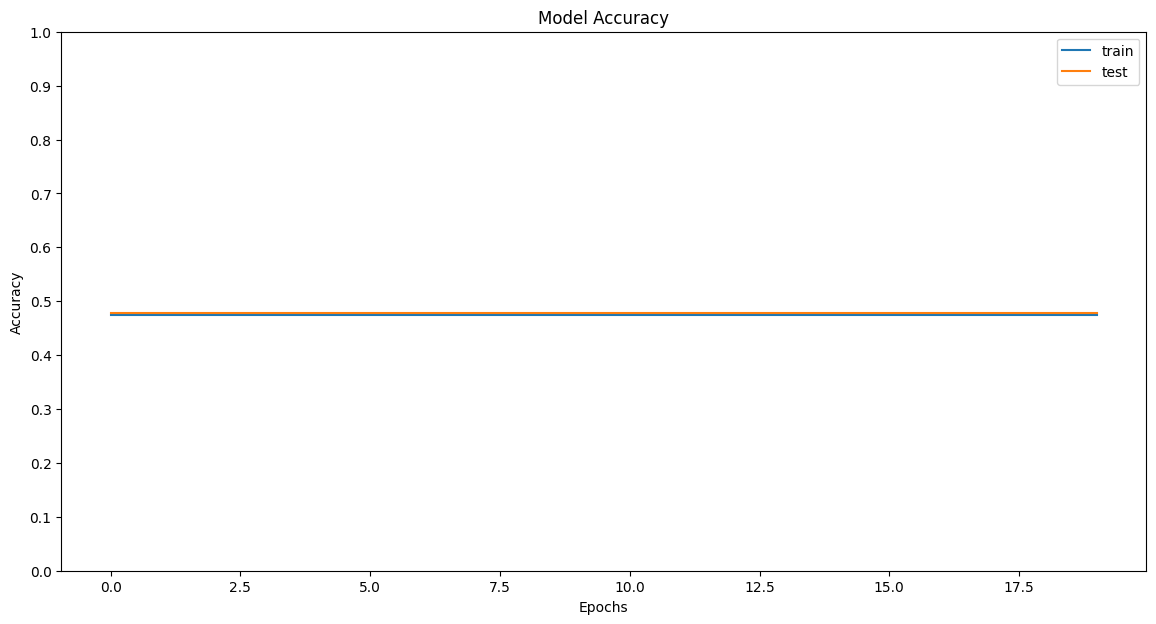

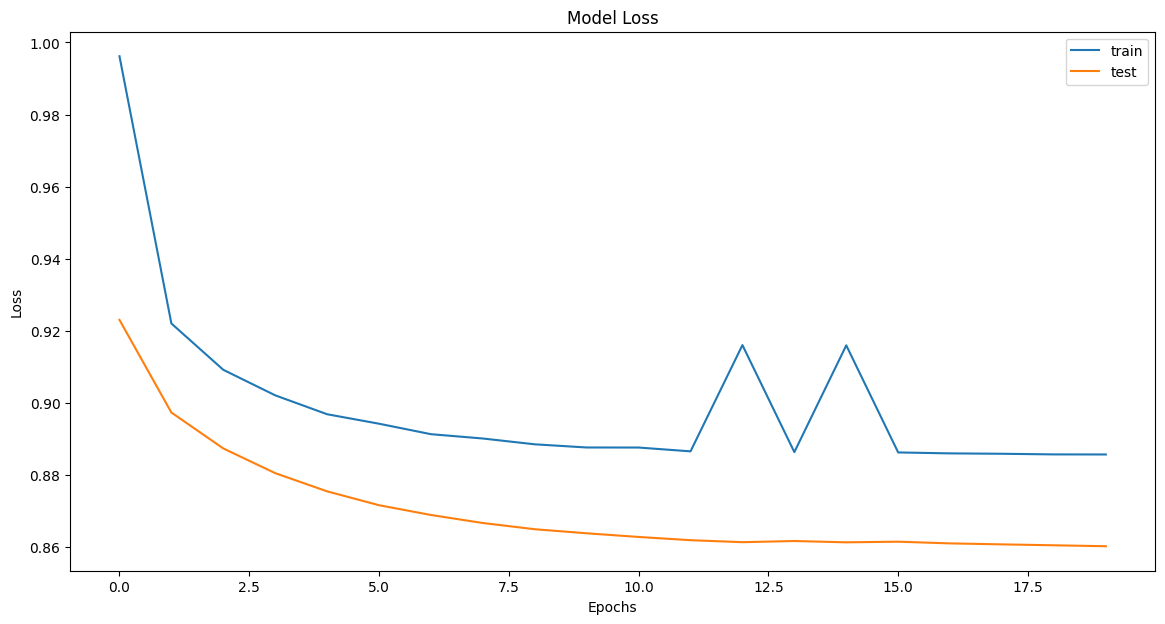

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 47.84%


For threshold set to 0.40, correctness is: 47.84%
For threshold set to 0.45, correctness is: 47.84%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3262 - loss: 1.0980 - val_accuracy: 0.4784 - val_loss: 1.0418
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4911 - loss: 1.0330 - val_accuracy: 0.4720 - val_loss: 0.9891
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4514 - loss: 0.9803 - val_accuracy: 0.4784 - val_loss: 0.9262
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4836 - loss: 0.9280 - val_accuracy: 0.4952 - val_loss: 0.9001
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

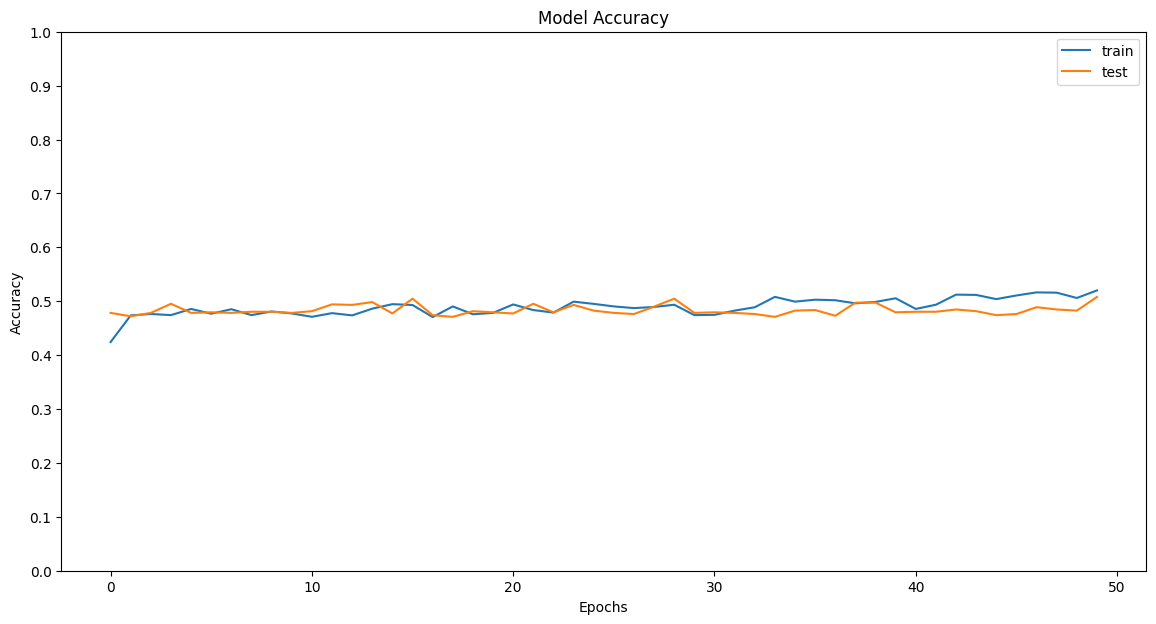

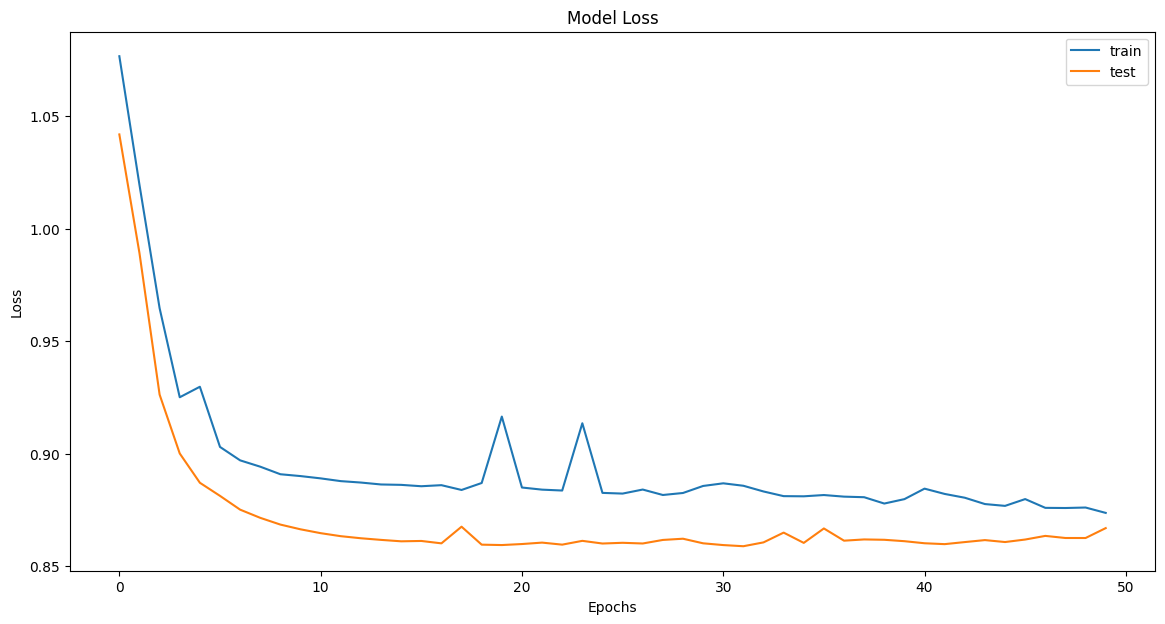

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 50.79%


For threshold set to 0.40, correctness is: 50.79%
For threshold set to 0.45, correctness is: 50.79%
For threshold set to 0.50, correctness is: 48.24%
For threshold set to 0.55, correctness is: 49.64%
For threshold set to 0.60, correctness is: 44.05%
For threshold set to 0.65, correctness is: 35.00%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



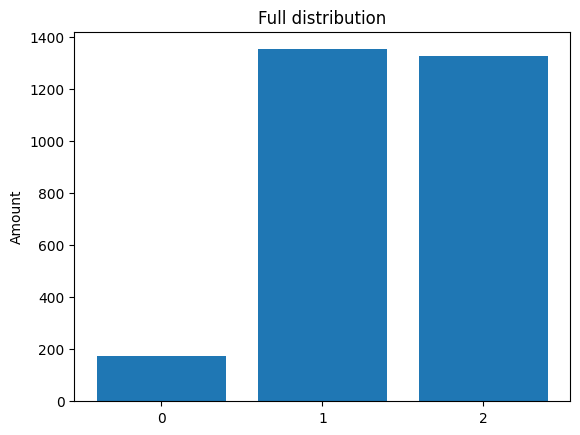

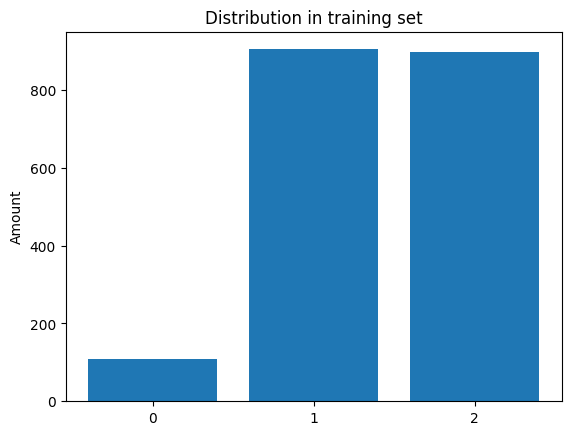

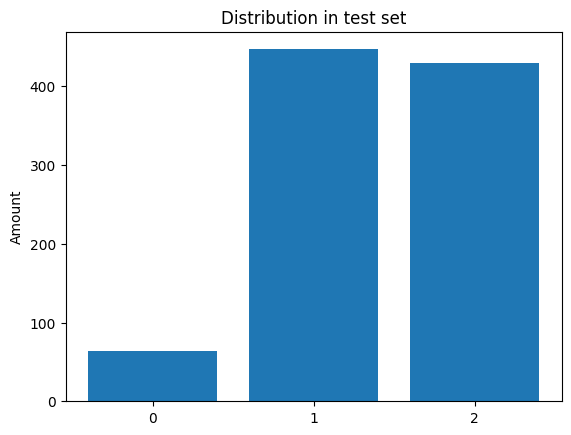

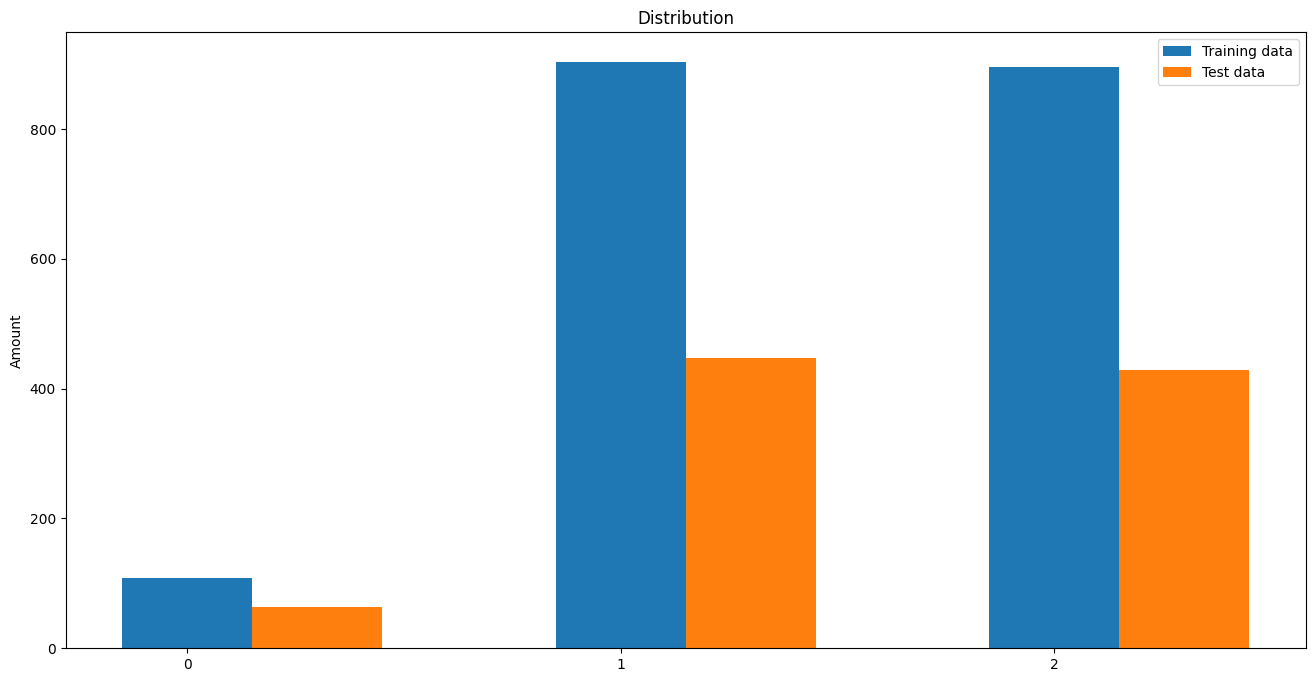


Example sequence from training set: [1 1 1 1 2 2 2 2 1 1 2 1 1 2 1] and its label: 2

Example sequence from training set: [2 2 2 2 2 2 2 1 2 2 1 1 2 2 1] and its label: 0


Random forest classifier accuracy: 46.28%
Random forest classifier accuracy: 44.89%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2544 - loss: 1.1122 - val_accuracy: 0.4755 - val_loss: 1.0149
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4846 - loss: 0.9834 - val_accuracy: 0.4755 - val_loss: 0.9469
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4745 - loss: 0.9348 - val_accuracy: 0.4755 - val_loss: 0.9283
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4815 - loss: 0.9090 - val_accuracy: 0.4755 - val_loss: 0.9171
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4761 - loss: 0.9067 - val_accuracy: 0.4755 - val_loss: 0.9095
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4638 - loss: 0.9027 - val_accuracy: 0.4755 - 

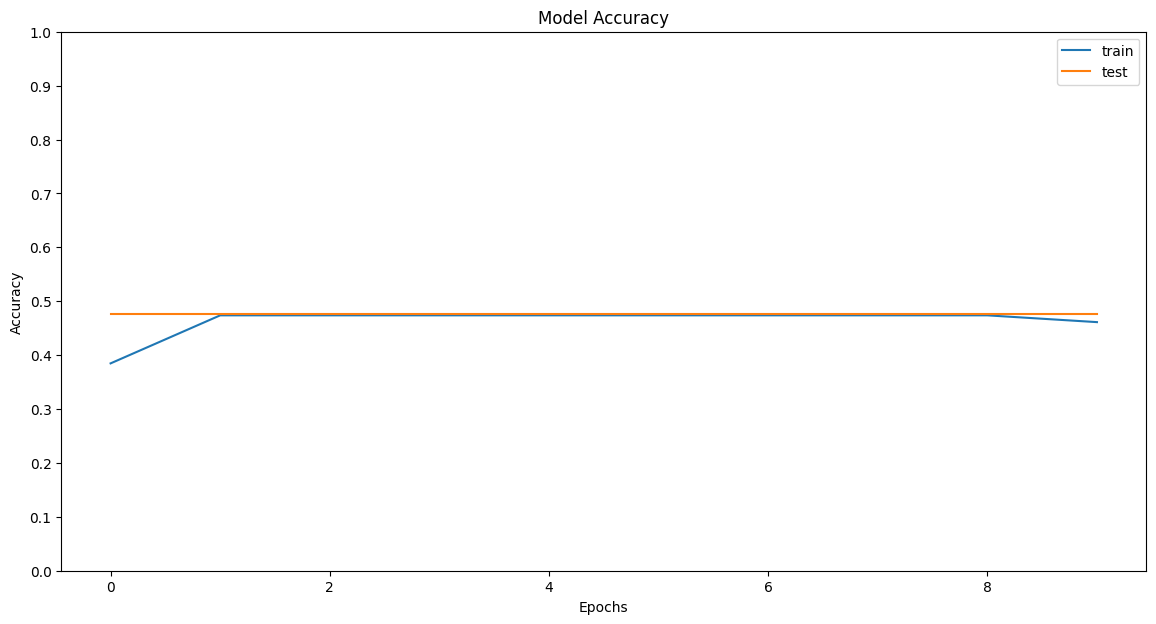

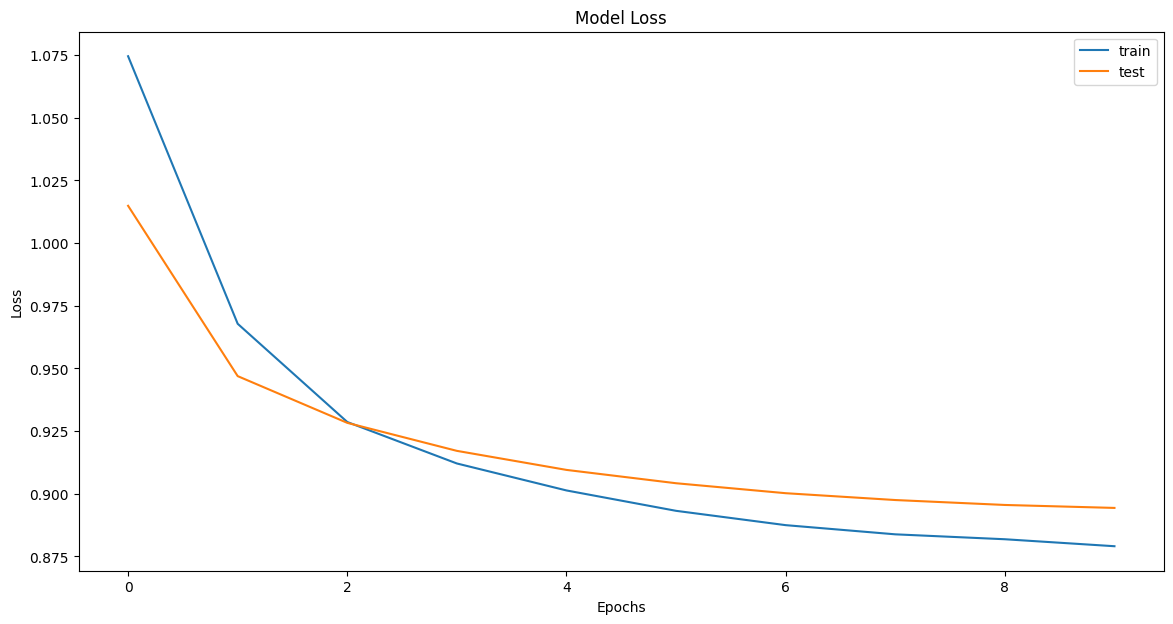

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.55%


For threshold set to 0.40, correctness is: 47.55%
For threshold set to 0.45, correctness is: 47.55%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3920 - loss: 1.0725 - val_accuracy: 0.4564 - val_loss: 0.9874
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4782 - loss: 0.9645 - val_accuracy: 0.4564 - val_loss: 0.9390
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4434 - loss: 0.9311 - val_accuracy: 0.4564 - val_loss: 0.9237
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.9016 - val_accuracy: 0.4564 - val_loss: 0.9136
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

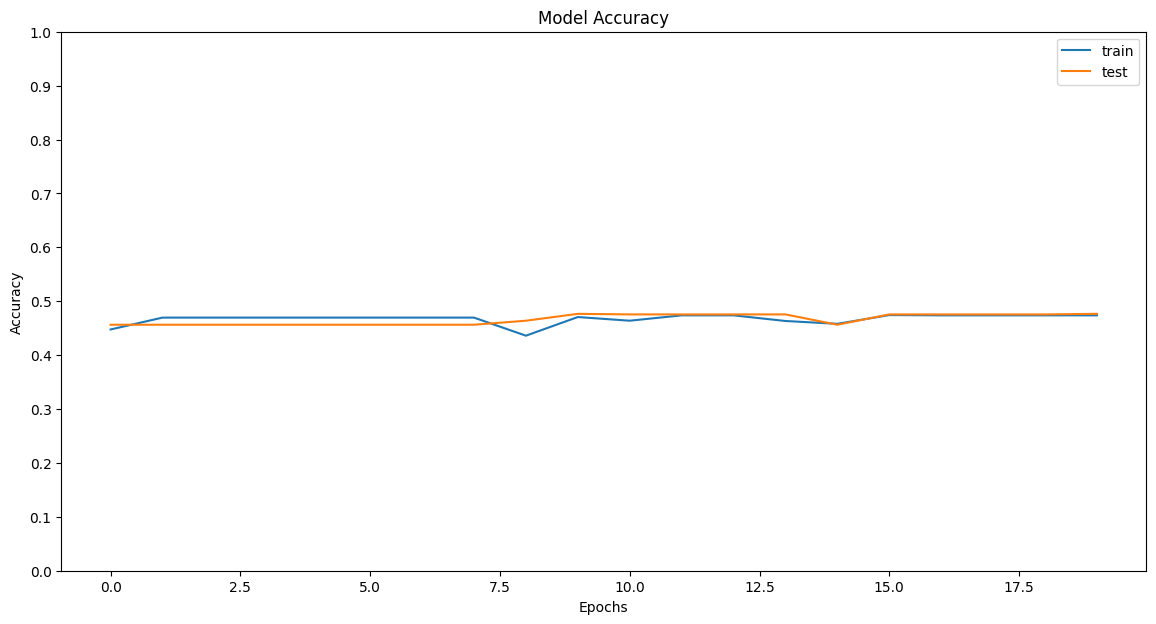

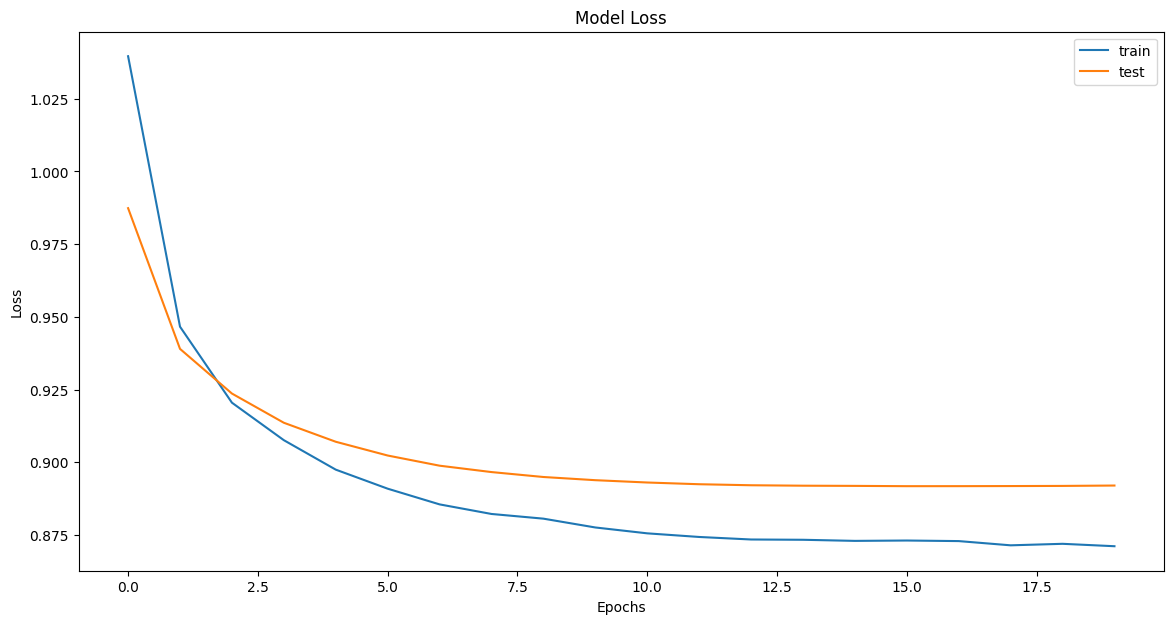

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.66%


For threshold set to 0.40, correctness is: 47.66%
For threshold set to 0.45, correctness is: 47.66%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4688 - loss: 1.0352 - val_accuracy: 0.4585 - val_loss: 0.9624
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4826 - loss: 0.9430 - val_accuracy: 0.4426 - val_loss: 0.9338
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4601 - loss: 0.9237 - val_accuracy: 0.4670 - val_loss: 0.9207
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4782 - loss: 0.9033 - val_accuracy: 0.4319 - val_loss: 0.9130
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

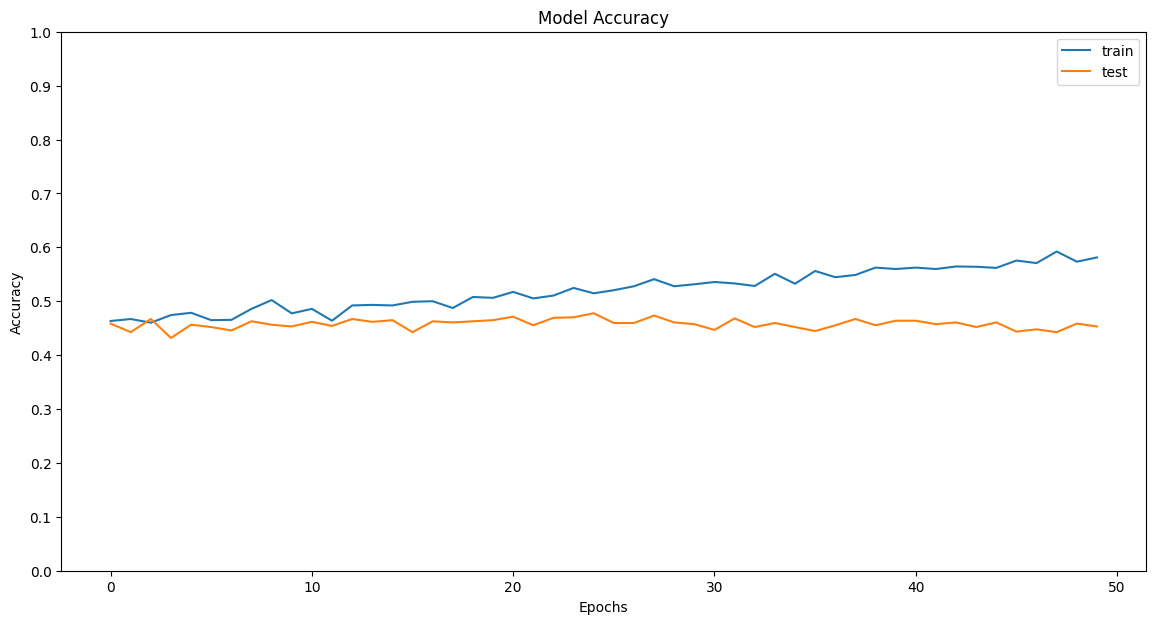

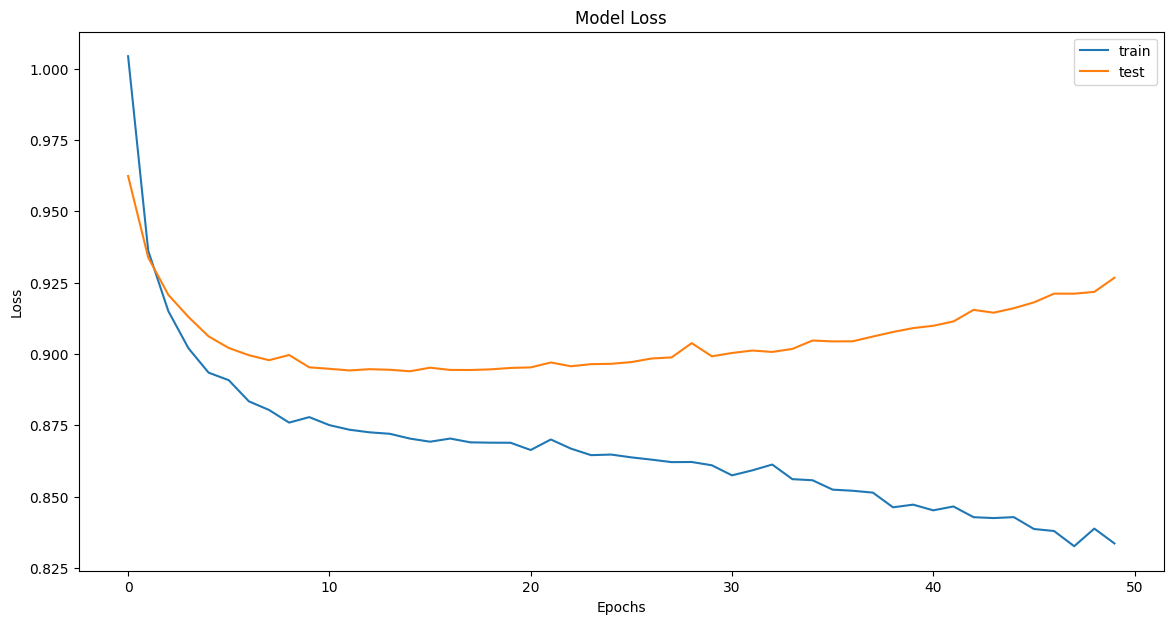

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 45.32%


For threshold set to 0.40, correctness is: 45.32%
For threshold set to 0.45, correctness is: 45.32%
For threshold set to 0.50, correctness is: 45.02%
For threshold set to 0.55, correctness is: 45.32%
For threshold set to 0.60, correctness is: 46.99%
For threshold set to 0.65, correctness is: 44.76%
For threshold set to 0.70, correctness is: 40.00%
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



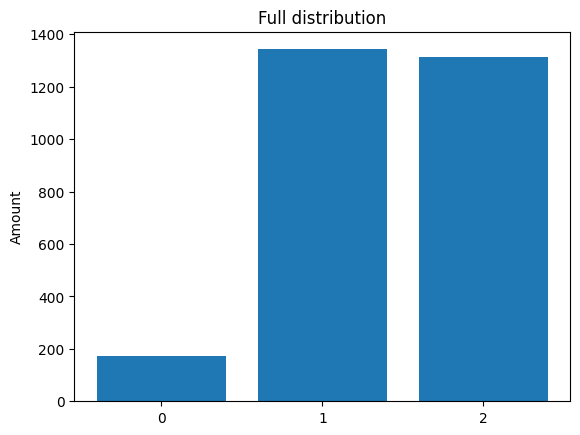

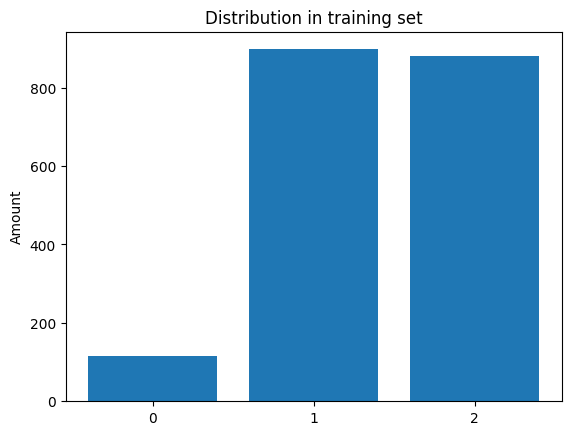

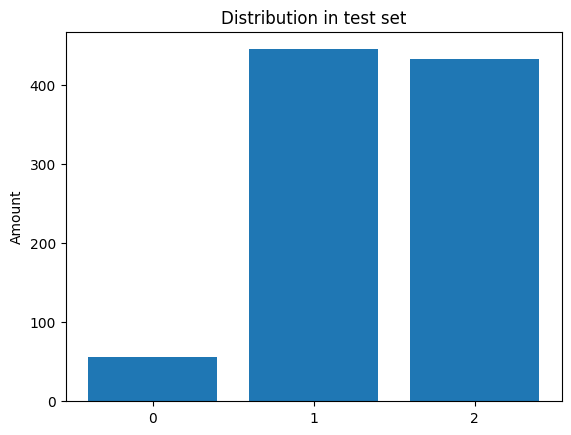

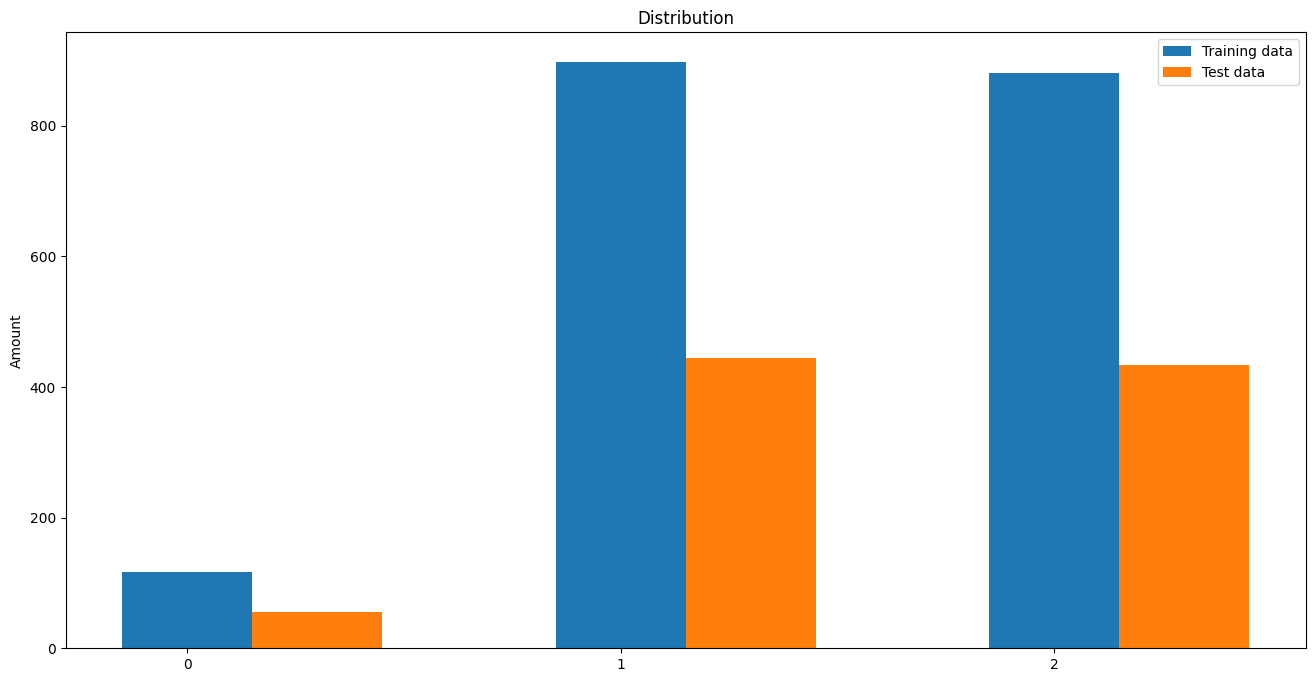


Example sequence from training set: [1 1 2 1 2 2 1 1 0 2 2 2 1 2 1 1 2 2 1 2] and its label: 2

Example sequence from training set: [0 1 2 2 1 2 1 2 1 1 1 2 2 1 1 1 2 1 1 1] and its label: 1


Random forest classifier accuracy: 48.29%
Random forest classifier accuracy: 46.15%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4789 - loss: 1.0183 - val_accuracy: 0.4764 - val_loss: 0.9282
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4756 - loss: 0.9324 - val_accuracy: 0.4764 - val_loss: 0.9129
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4772 - loss: 0.9152 - val_accuracy: 0.4764 - val_loss: 0.9024
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4649 - loss: 0.9080 - val_accuracy: 0.4764 - val_loss: 0.8946
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4779 - loss: 0.8937 - val_accuracy: 0.4764 - val_loss: 0.8893
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4883 - loss: 0.8942 - val

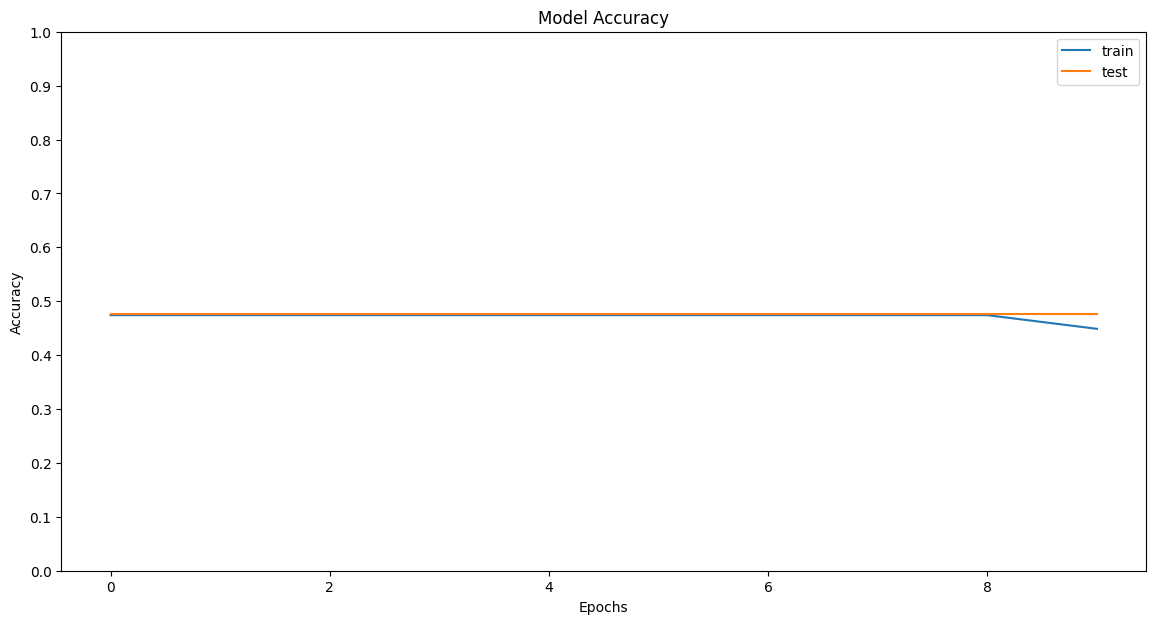

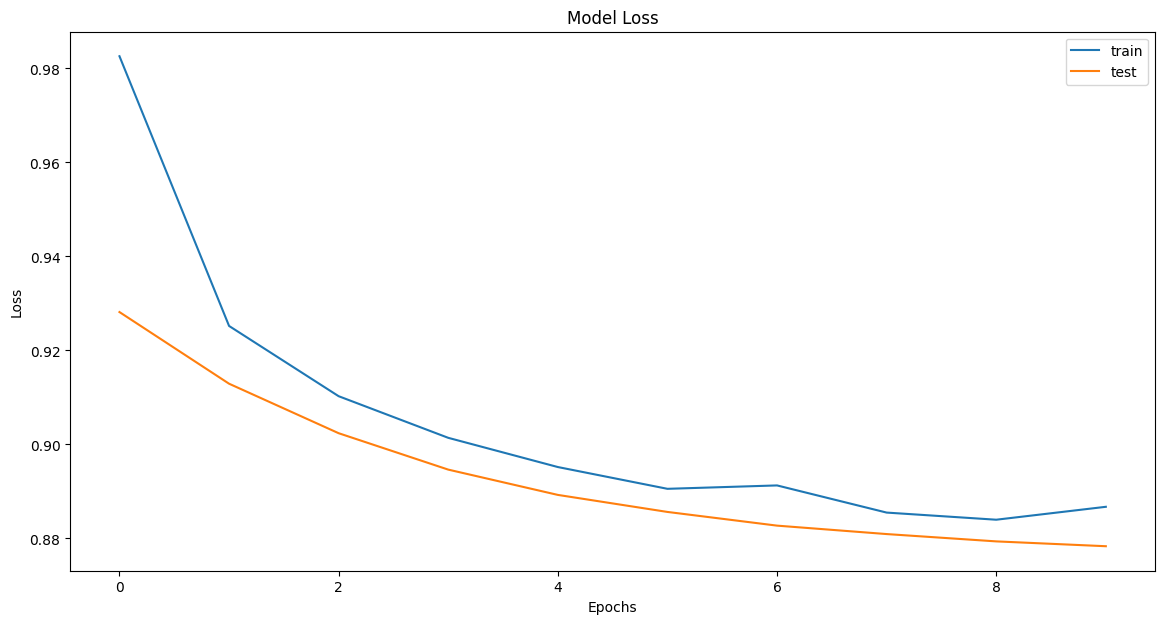

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.64%


For threshold set to 0.40, correctness is: 47.64%
For threshold set to 0.45, correctness is: 47.64%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4855 - loss: 1.0187 - val_accuracy: 0.4764 - val_loss: 0.9261
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4720 - loss: 0.9161 - val_accuracy: 0.4764 - val_loss: 0.8923
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4648 - loss: 0.8952 - val_accuracy: 0.4764 - val_loss: 0.8862
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 0.8860 - val_accuracy: 0.4764 - val_loss: 0.8829
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

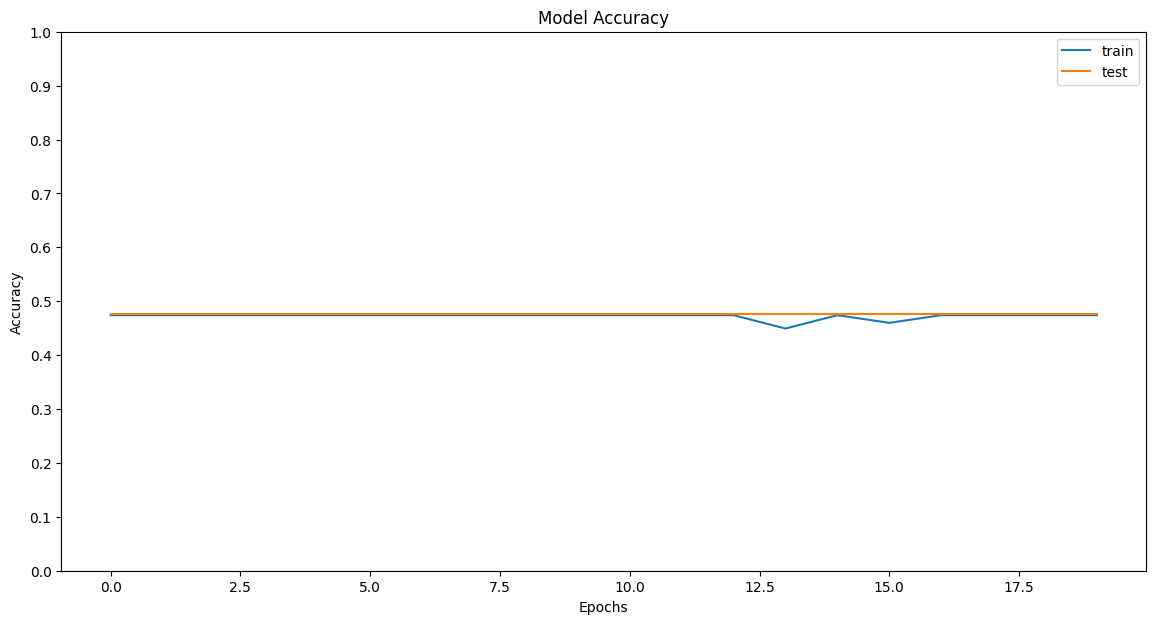

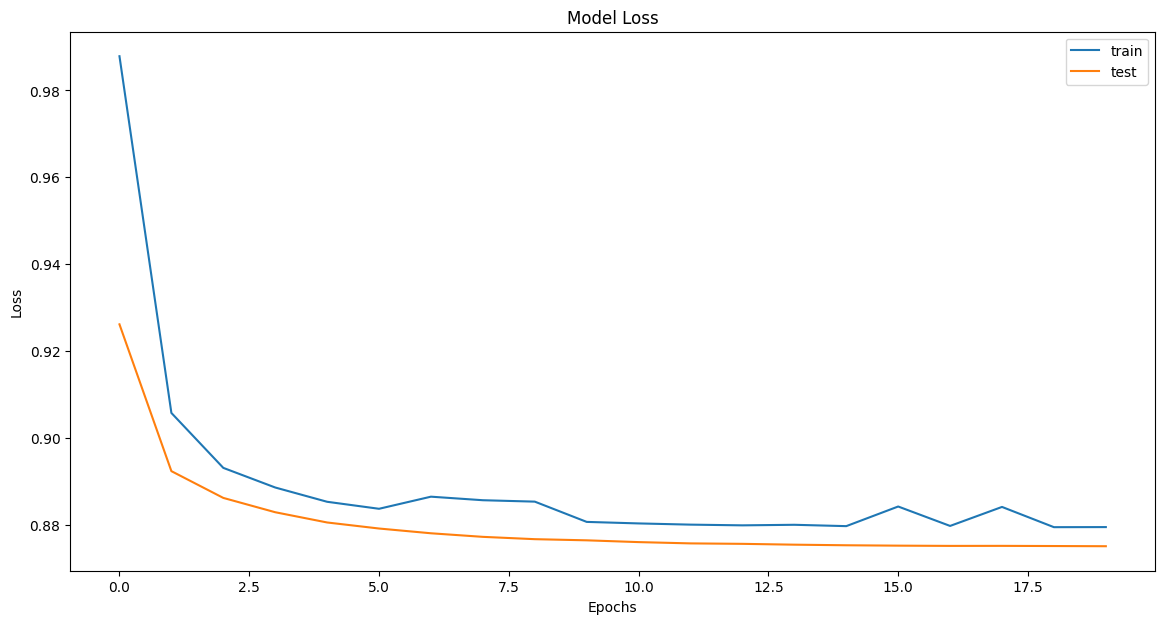

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.64%


For threshold set to 0.40, correctness is: 47.64%
For threshold set to 0.45, correctness is: 47.64%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4556 - loss: 1.0091 - val_accuracy: 0.4743 - val_loss: 0.9265
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4659 - loss: 0.9212 - val_accuracy: 0.4636 - val_loss: 0.8963
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4487 - loss: 0.9025 - val_accuracy: 0.4636 - val_loss: 0.8886
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4560 - loss: 0.8986 - val_accuracy: 0.4636 - val_loss: 0.8843
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

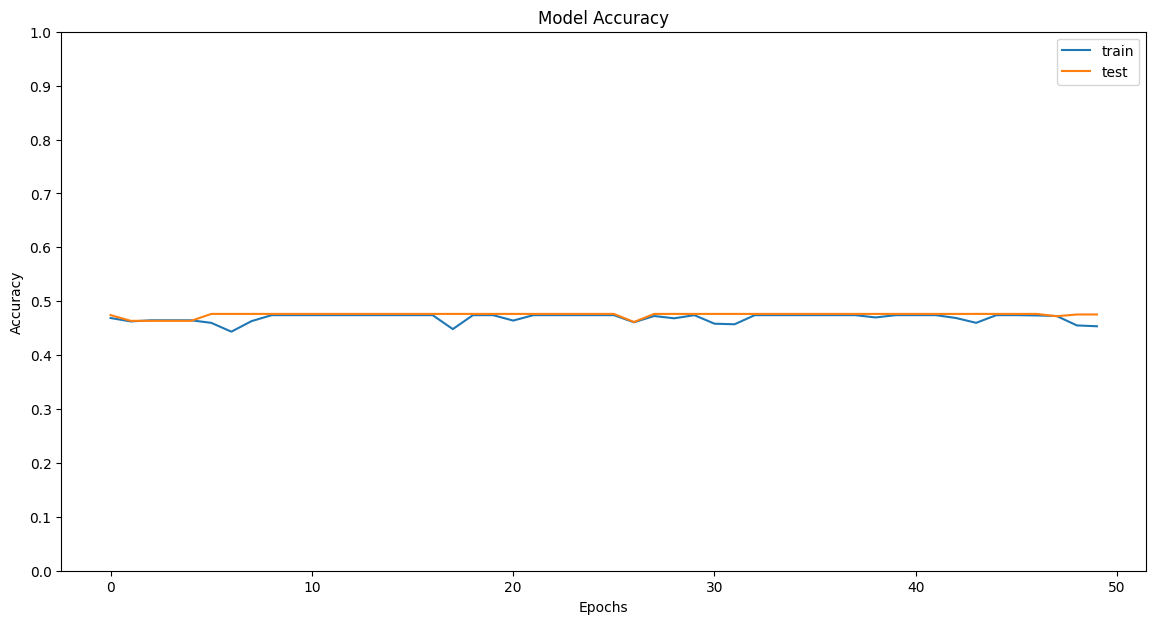

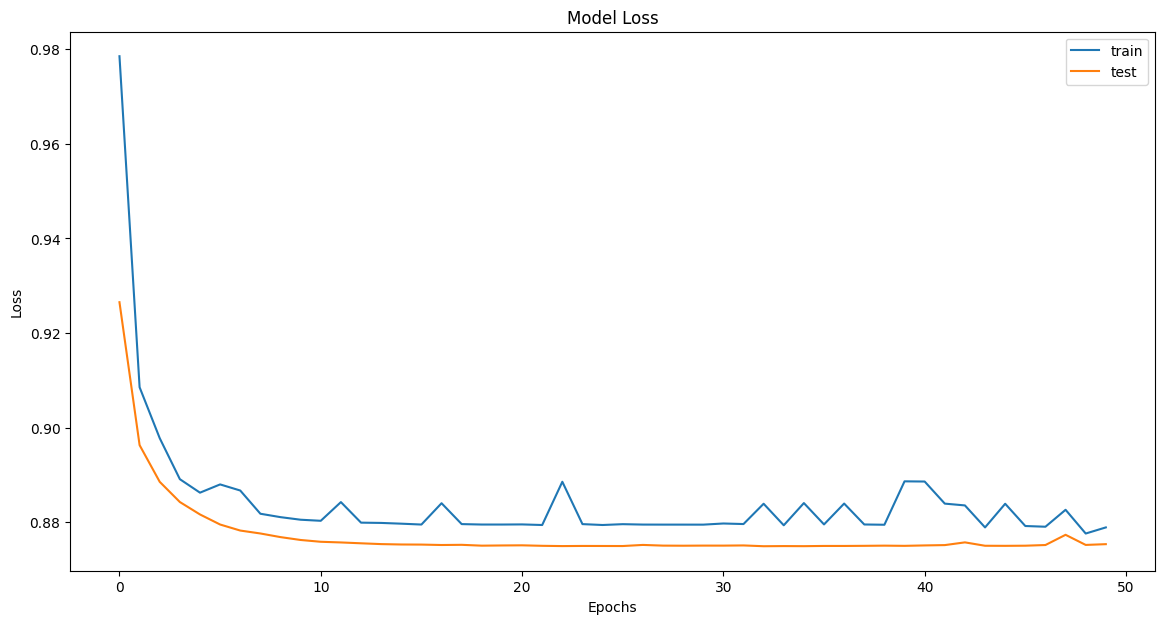

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.54%


For threshold set to 0.40, correctness is: 47.54%
For threshold set to 0.45, correctness is: 47.63%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



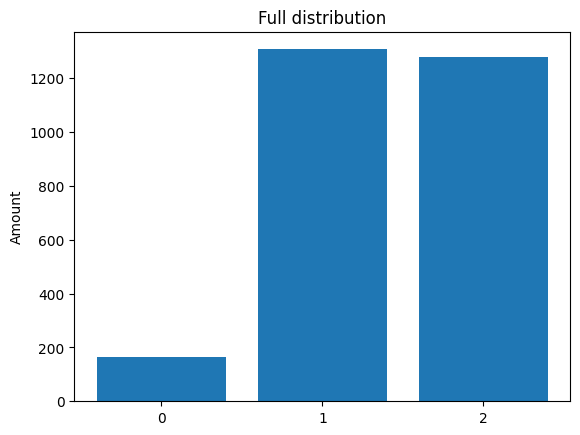

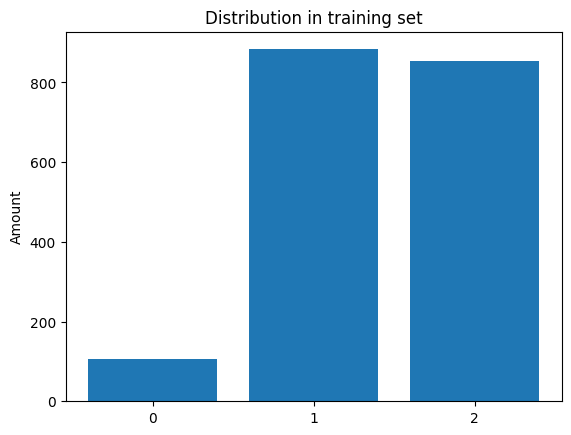

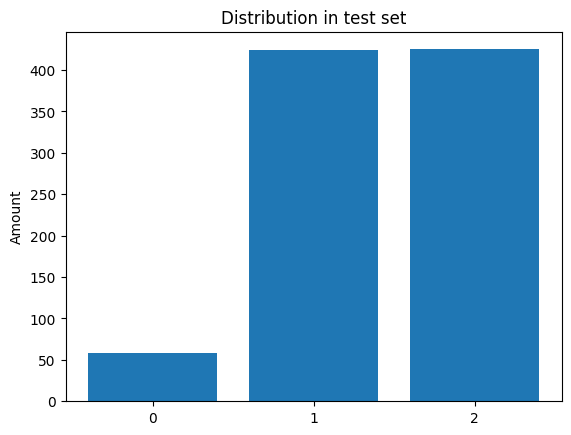

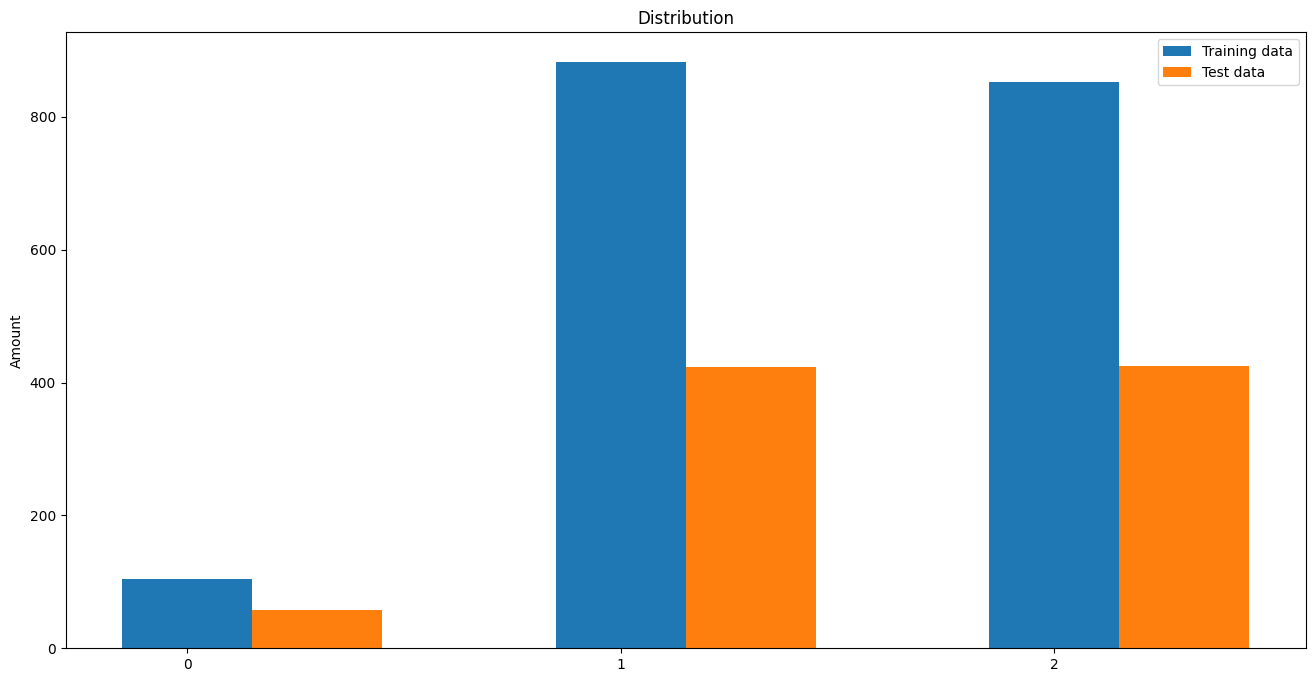


Example sequence from training set: [1 1 2 1 1 2 1 2 2 2 2 0 1 2 2 0 2 1 1 1 1 2 0 0 2 1 1 2 1 1 1 0 2 0 2 1 0
 2 2 2] and its label: 0

Example sequence from training set: [2 1 1 2 2 1 1 2 0 0 2 1 1 2 2 1 2 2 1 1 2 1 2 1 2 1 1 2 2 0 1 2 2 1 1 2 2
 1 1 2] and its label: 1


Random forest classifier accuracy: 46.86%
Random forest classifier accuracy: 45.87%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3047 - loss: 1.1050 - val_accuracy: 0.4686 - val_loss: 1.0115
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4394 - loss: 1.0072 - val_accuracy: 0.4686 - val_loss: 0.9786
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4840 - loss: 0.9597 - val_accuracy: 0.4686 - val_loss: 0.9552
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4742 - loss: 0.9415 - val_accuracy: 0.4686 - val_loss: 0.9387
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4572 - loss: 0.9334 - val_accuracy: 0.4686 - val_loss: 0.9264
Epoch 6

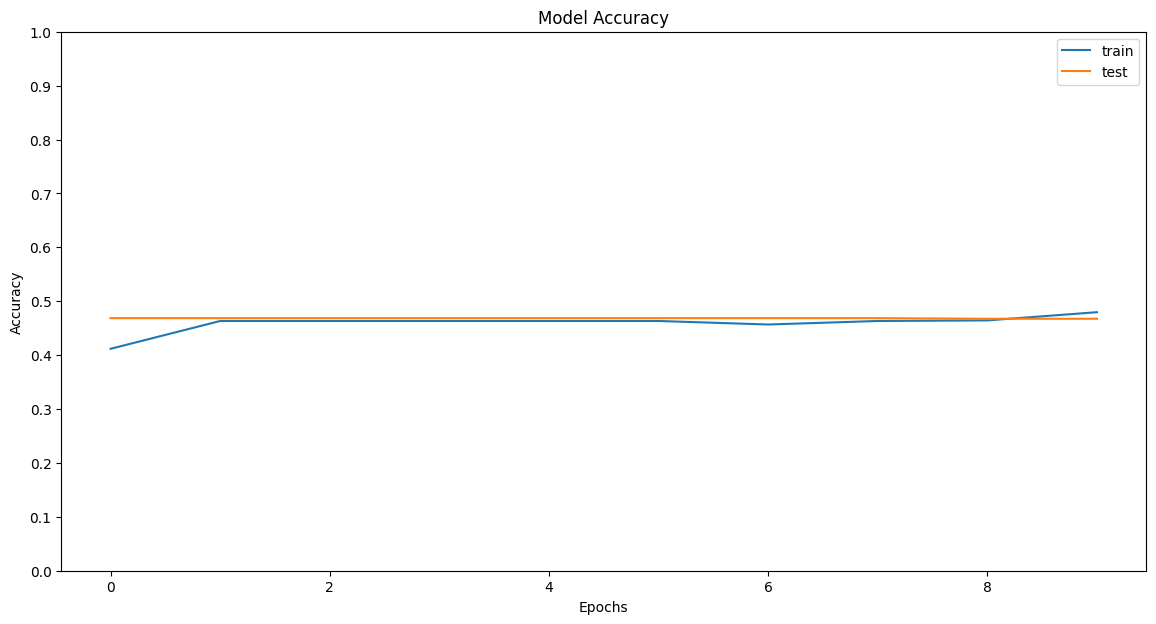

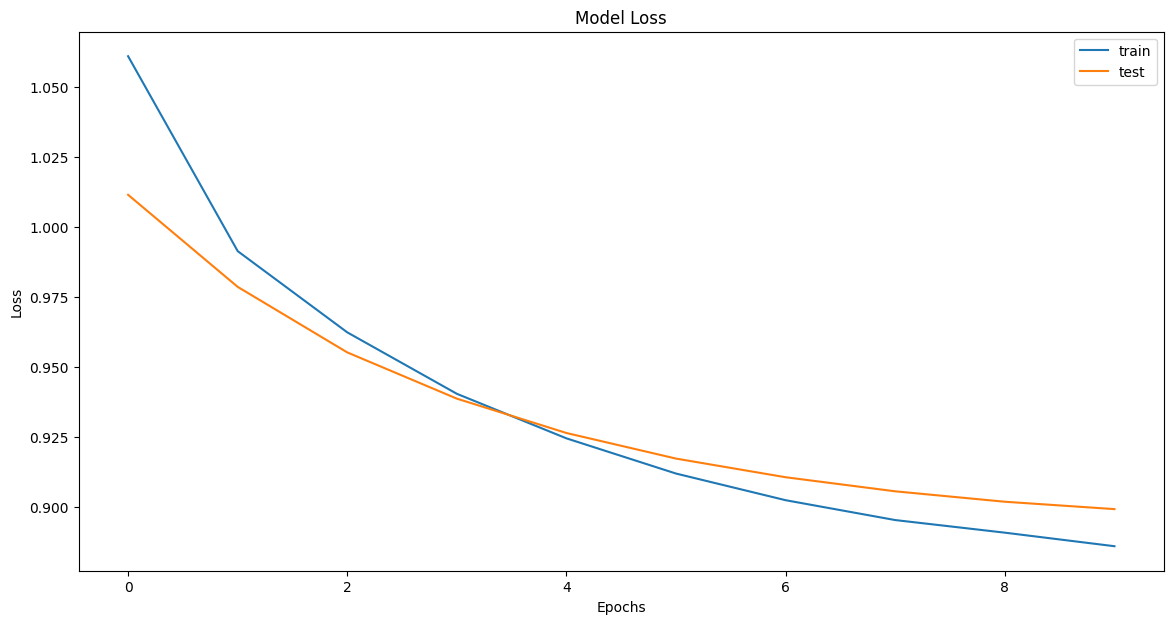

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 46.75%


For threshold set to 0.40, correctness is: 46.75%
For threshold set to 0.45, correctness is: 46.75%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4785 - loss: 0.9927 - val_accuracy: 0.4675 - val_loss: 0.9106
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4701 - loss: 0.8883 - val_accuracy: 0.4675 - val_loss: 0.8993
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4895 - loss: 0.8828 - val_accuracy: 0.4675 - val_loss: 0.8965
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4747 - loss: 0.8695 - val_accuracy: 0.4675 - val_loss: 0.8947
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

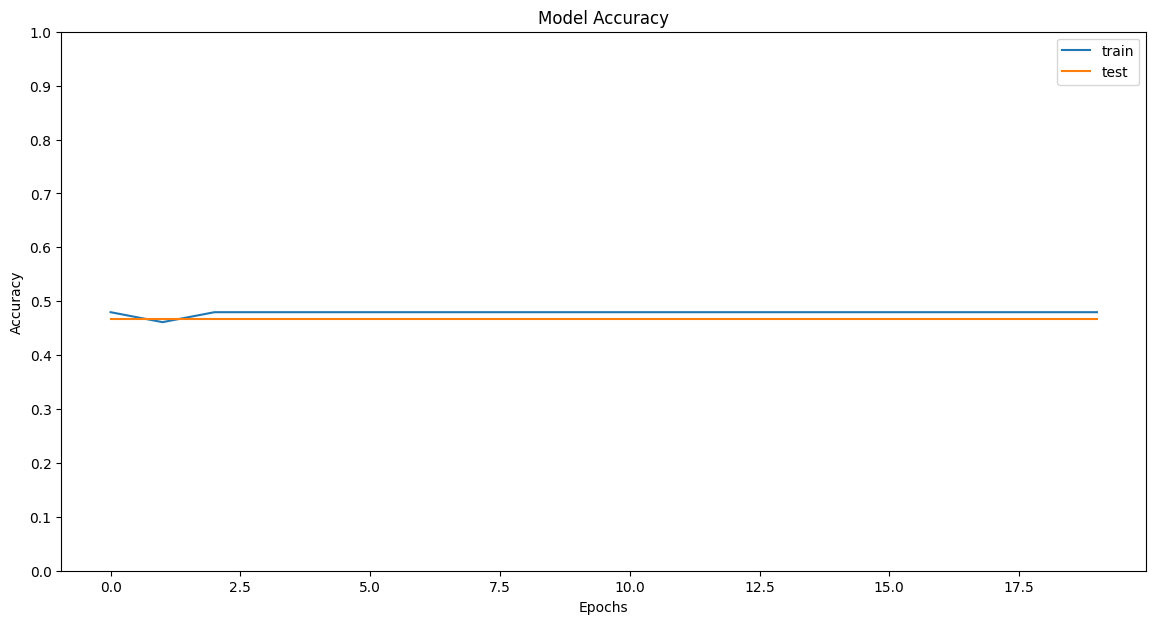

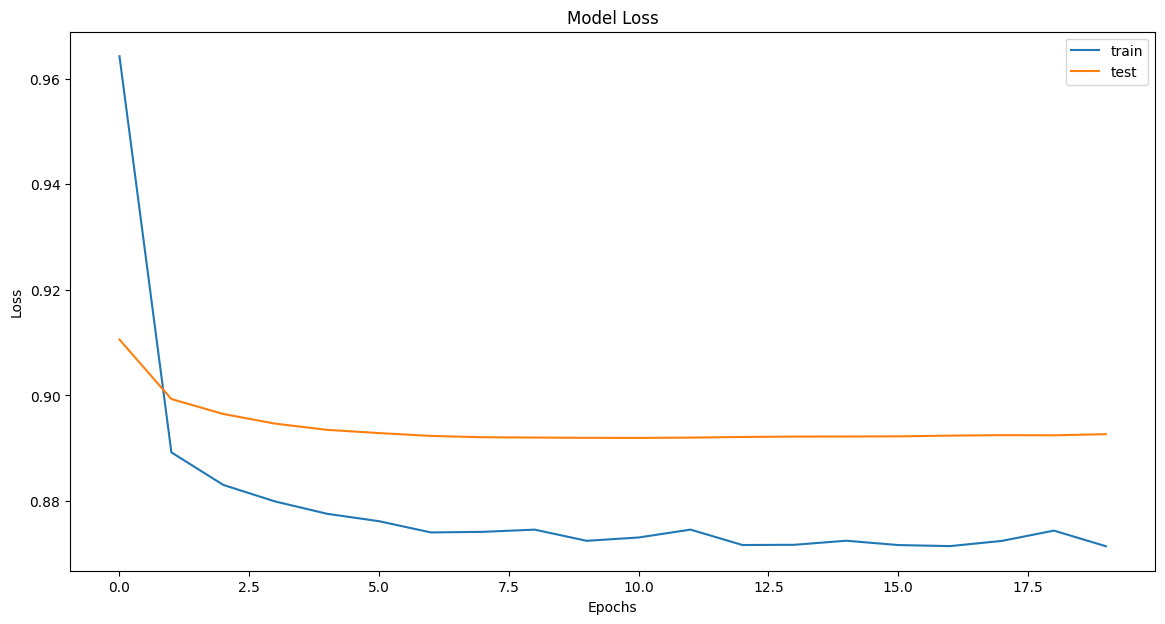

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 46.75%


For threshold set to 0.40, correctness is: 46.75%
For threshold set to 0.45, correctness is: 46.75%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4905 - loss: 1.0587 - val_accuracy: 0.4686 - val_loss: 0.9979
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4677 - loss: 0.9847 - val_accuracy: 0.4686 - val_loss: 0.9663
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4994 - loss: 0.9478 - val_accuracy: 0.4686 - val_loss: 0.9447
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4662 - loss: 0.9280 - val_accuracy: 0.4686 - val_loss: 0.9287
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

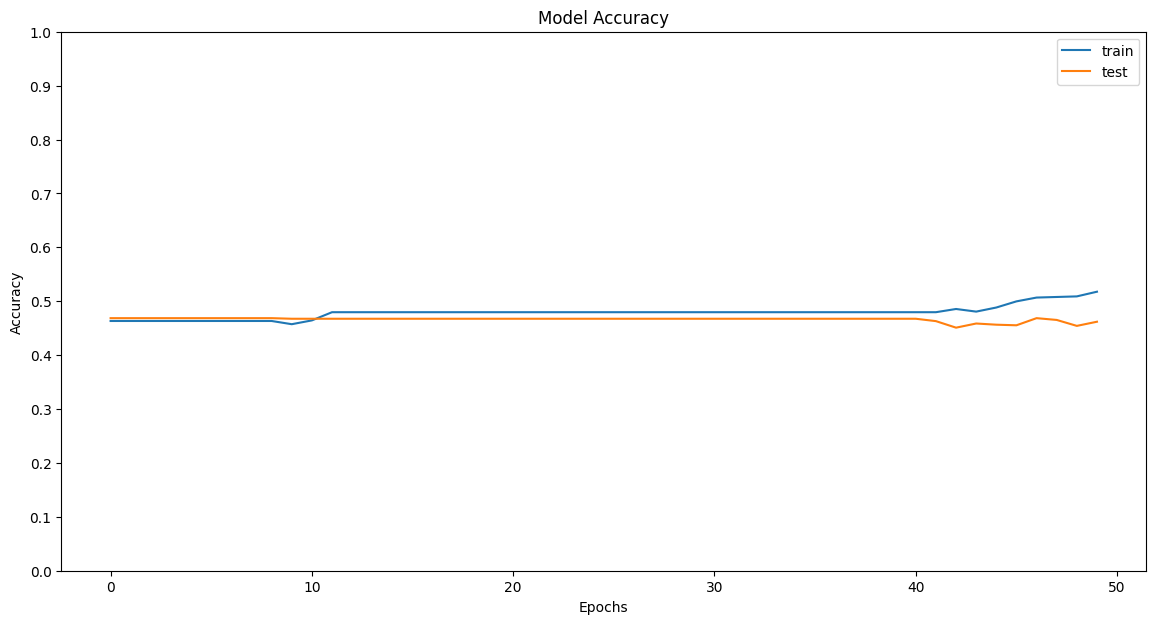

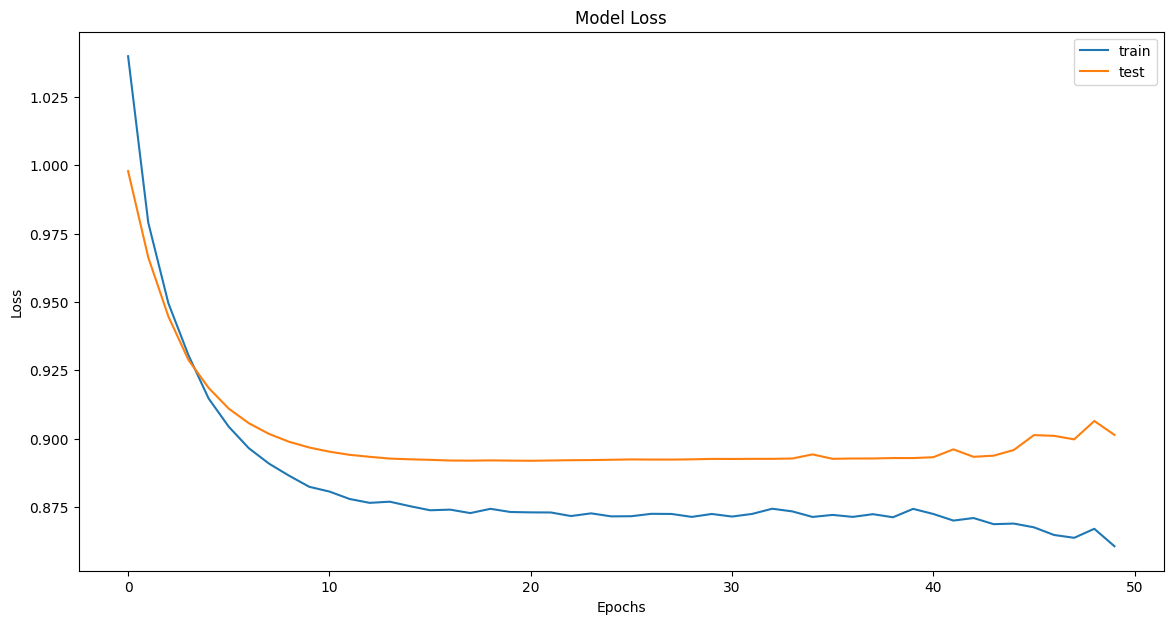

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 46.20%


For threshold set to 0.40, correctness is: 46.20%
For threshold set to 0.45, correctness is: 46.20%
For threshold set to 0.50, correctness is: 48.65%
For threshold set to 0.55, correctness is: 46.43%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 10, Epoch: 50, Accuracy: 50.79%
Chunk size: 2, Epoch: 10, Accuracy: 48.28%
Chunk size: 5, Epoch: 50, Accuracy: 48.22%

Data from file: plgbet.csv


Example sequence: ['red', 'red', 'black', 'black', 'red', 'black', 'red', 'red', 'black', 'red', 'red', 'red']

black: Counter({1: 387, 2: 164, 3: 90, 4: 40, 5: 19, 7: 6, 6: 5, 8: 2, 9: 1})
red: Counter({1: 366, 2: 180, 3: 99, 4: 29, 5: 13, 6: 9, 7: 4, 10: 2, 8: 1})
green: Counter({1: 171, 2: 6})




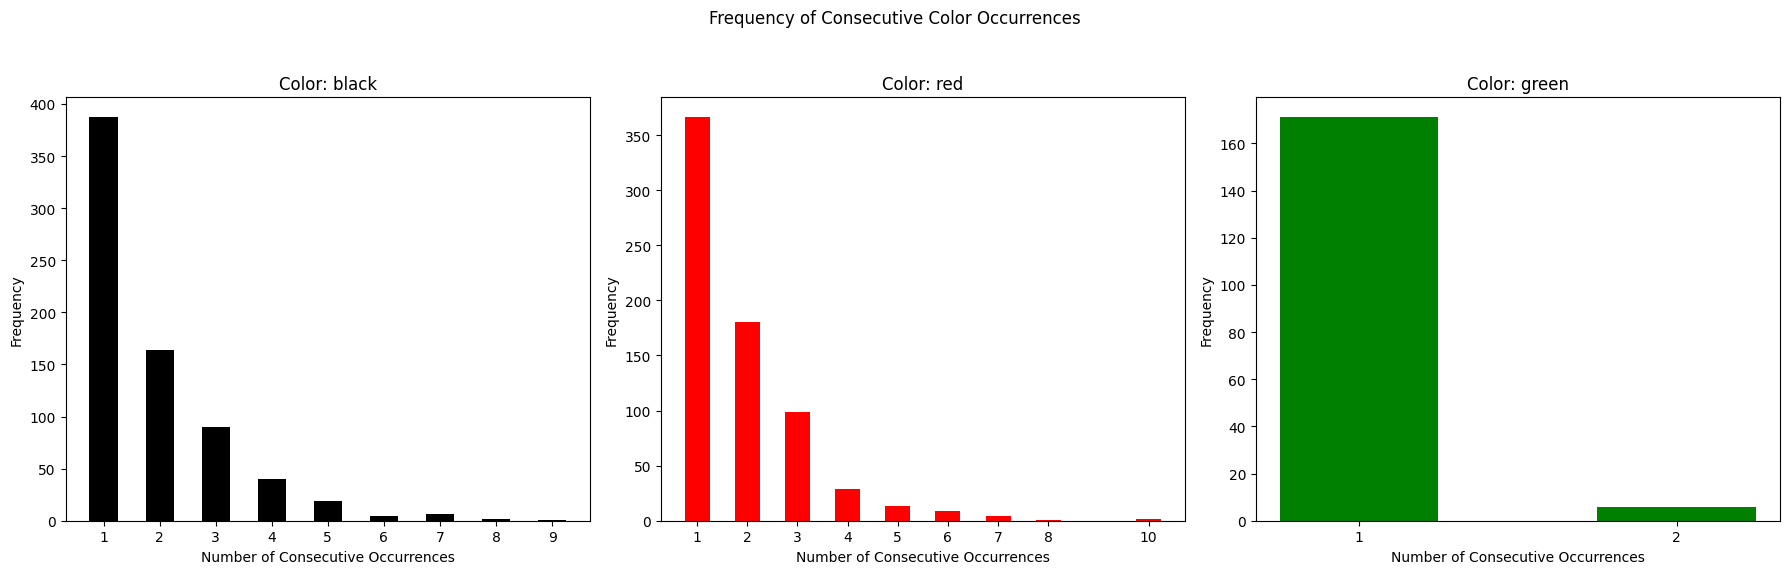


(2,)



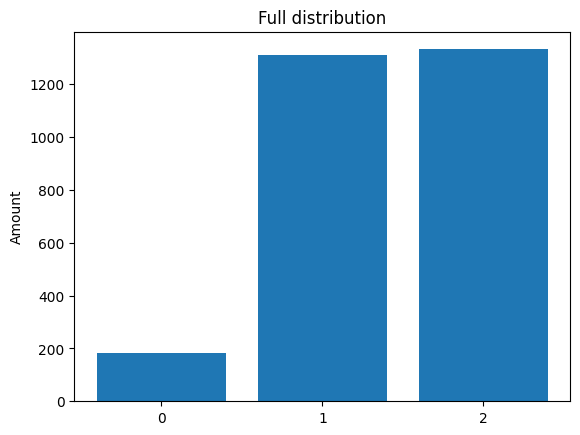

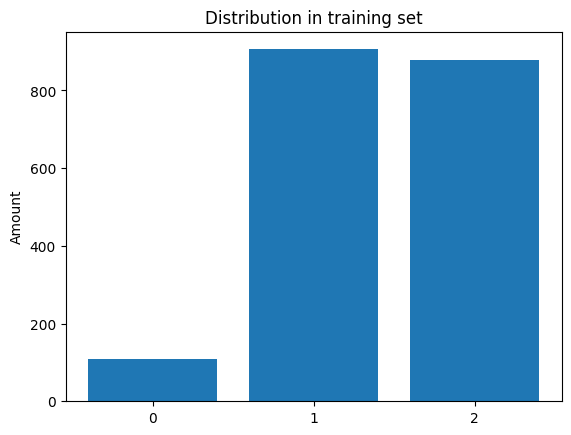

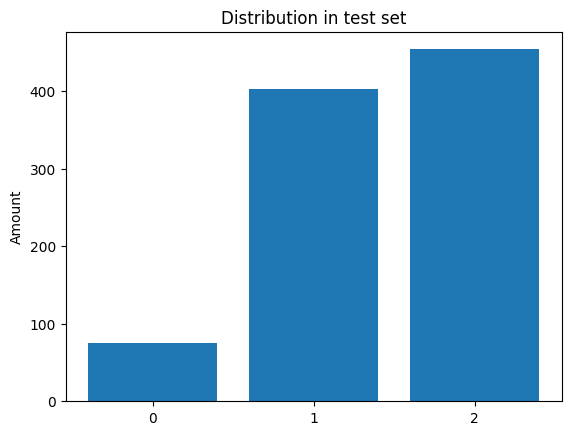

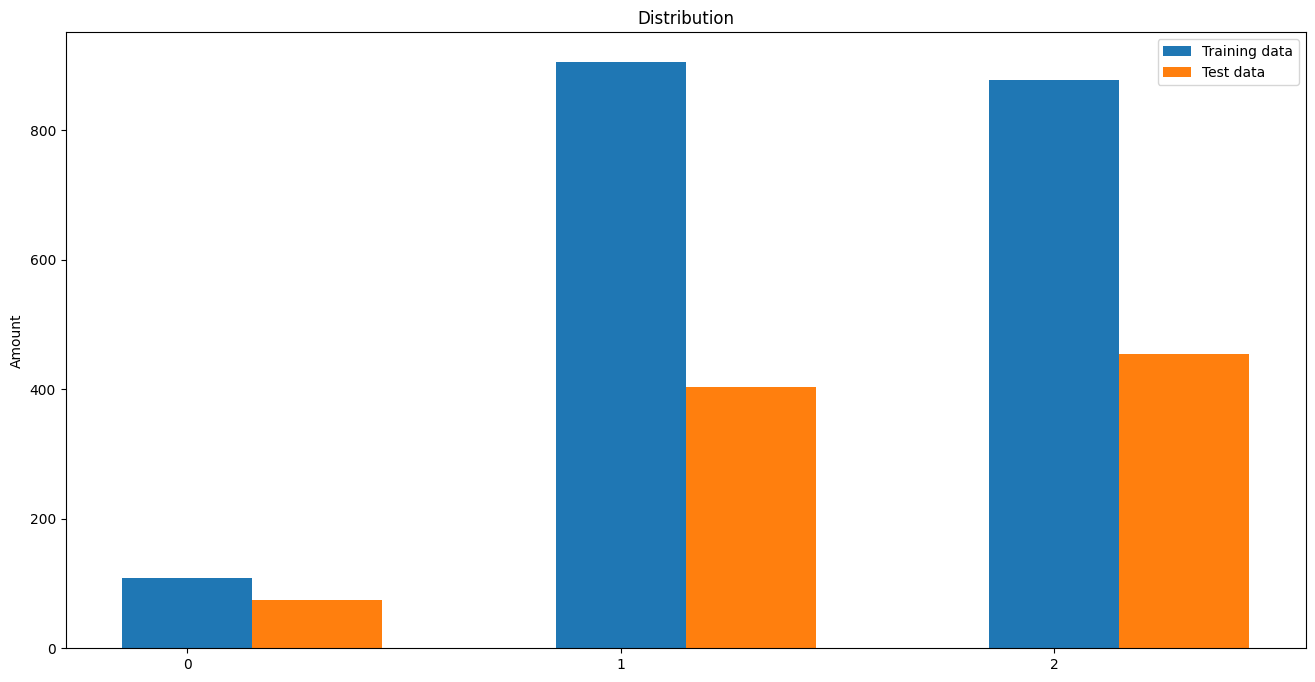


Example sequence from training set: [1 1] and its label: 1

Example sequence from training set: [1 2] and its label: 2


Random forest classifier accuracy: 42.17%
Random forest classifier accuracy: 42.92%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4775 - loss: 1.0896 - val_accuracy: 0.4324 - val_loss: 1.0071
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4834 - loss: 0.9760 - val_accuracy: 0.4324 - val_loss: 0.9759
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4854 - loss: 0.9455 - val_accuracy: 0.4324 - val_loss: 0.9588
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.9319 - val_accuracy: 0.4324 - val_loss: 0.9482
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4752 - loss: 0.9141 - val_accuracy: 0.4324 - val_loss: 0.9401
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4894 - loss: 0.9005 - val_accuracy: 0.4324 - val_loss: 0.9357
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━

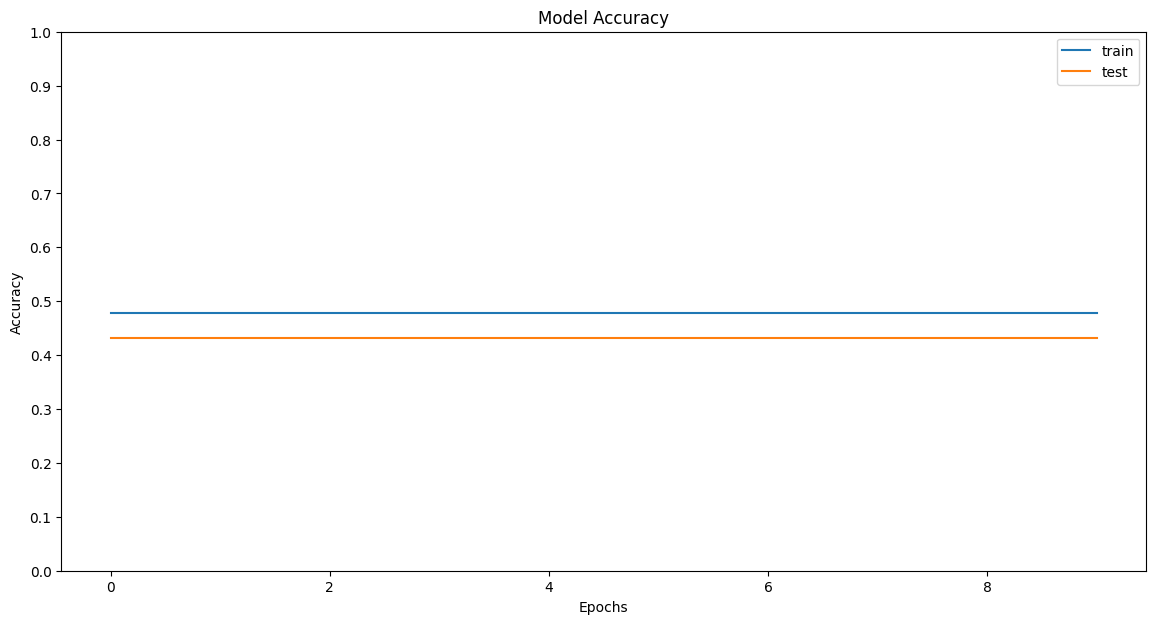

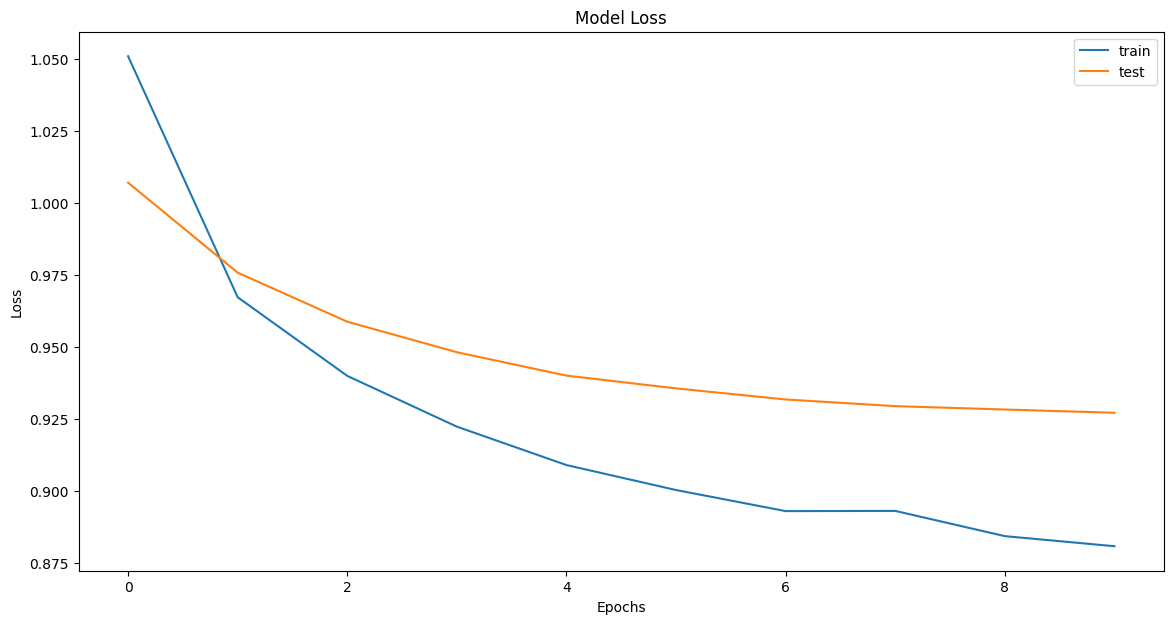

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 43.24%


For threshold set to 0.40, correctness is: 43.24%
For threshold set to 0.45, correctness is: 43.24%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4921 - loss: 1.0051 - val_accuracy: 0.4324 - val_loss: 0.9512
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4827 - loss: 0.9060 - val_accuracy: 0.4324 - val_loss: 0.9360
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4839 - loss: 0.9040 - val_accuracy: 0.4324 - val_loss: 0.9317
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4784 - loss: 0.8929 - val_accuracy: 0.4324 - val_loss: 0.9294
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

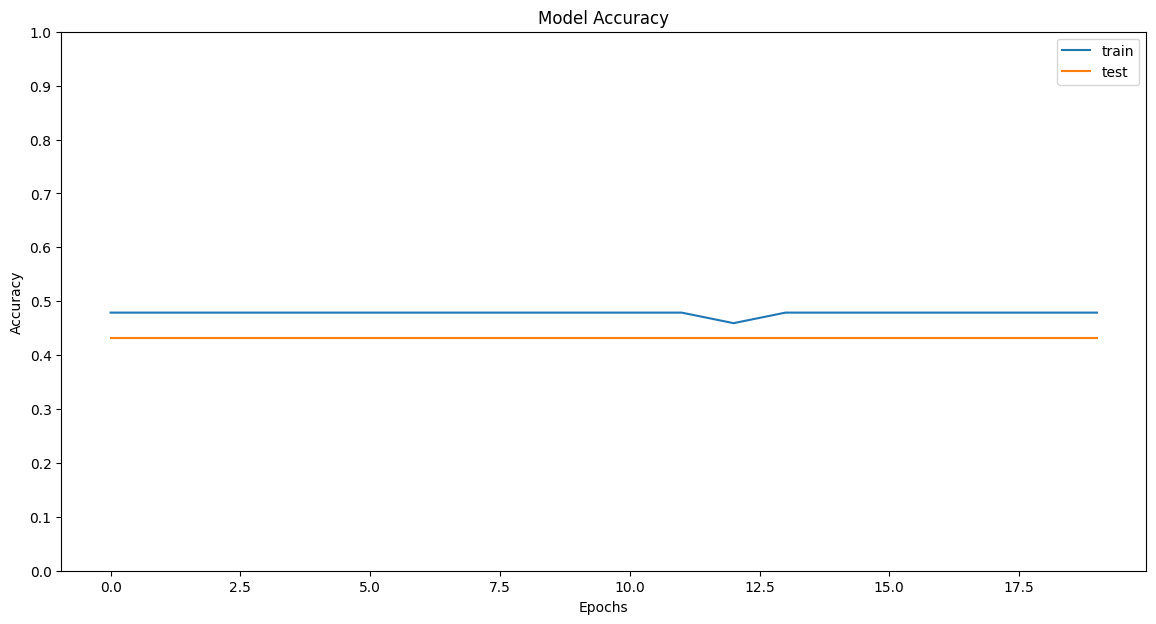

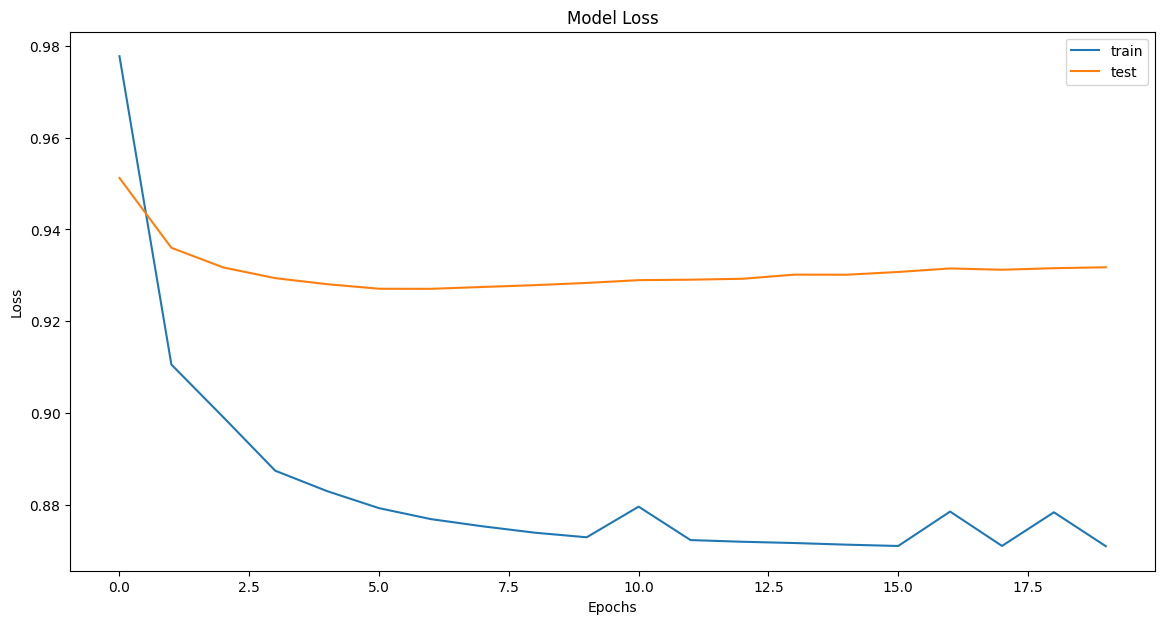

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 43.24%


For threshold set to 0.40, correctness is: 43.24%
For threshold set to 0.45, correctness is: 43.24%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1669 - loss: 1.1250 - val_accuracy: 0.4324 - val_loss: 0.9753
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 0.9195 - val_accuracy: 0.4324 - val_loss: 0.9357
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4741 - loss: 0.9153 - val_accuracy: 0.4324 - val_loss: 0.9308
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4795 - loss: 0.9003 - val_accuracy: 0.4324 - val_loss: 0.9287
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

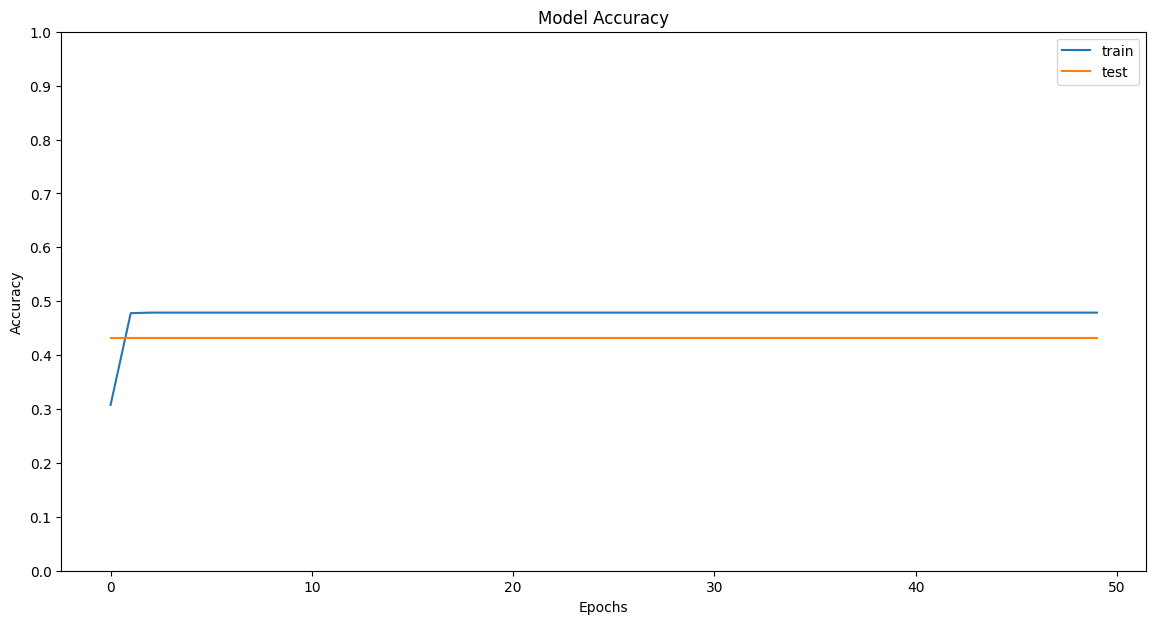

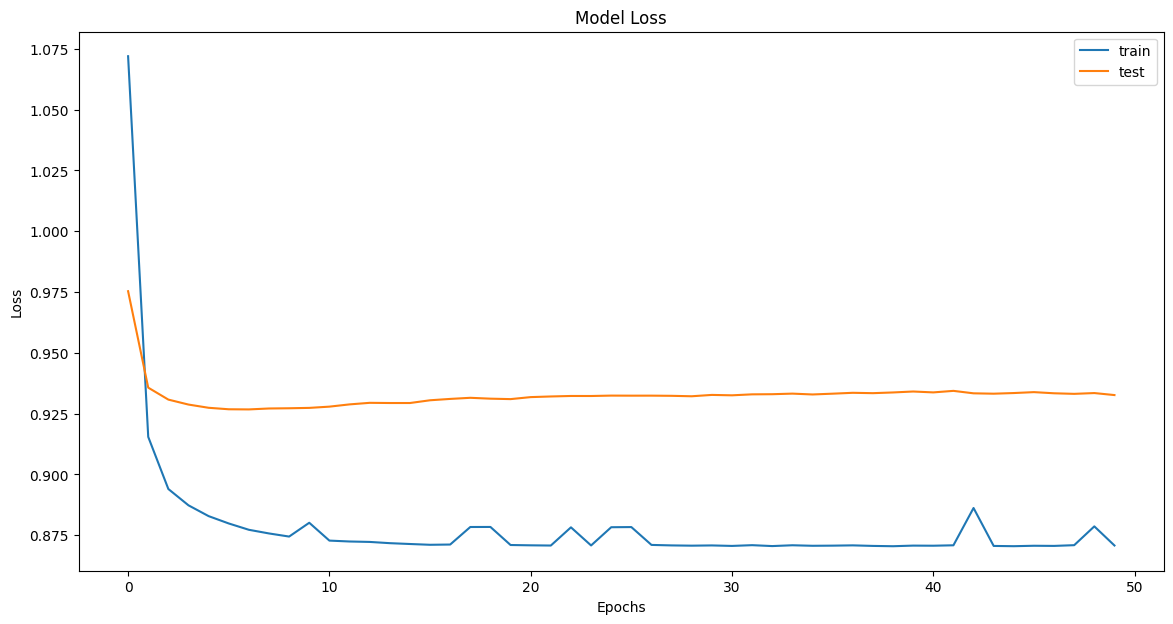

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 43.24%


For threshold set to 0.40, correctness is: 43.24%
For threshold set to 0.45, correctness is: 43.24%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



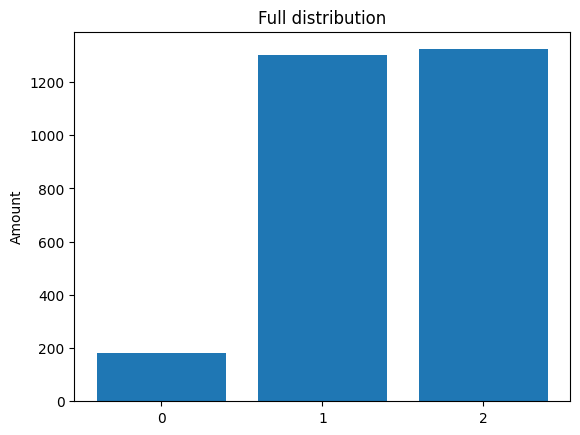

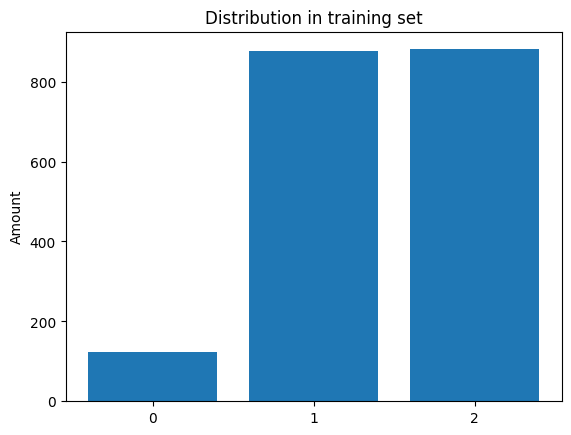

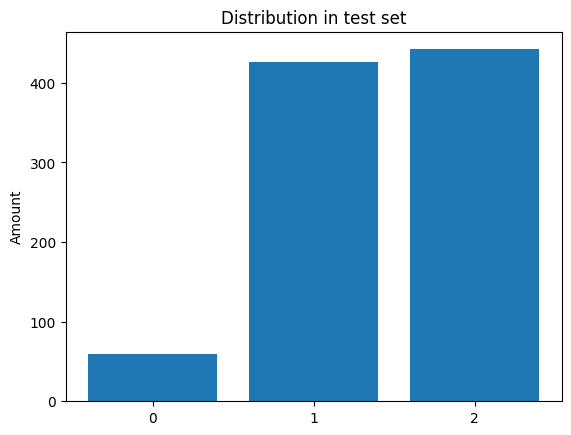

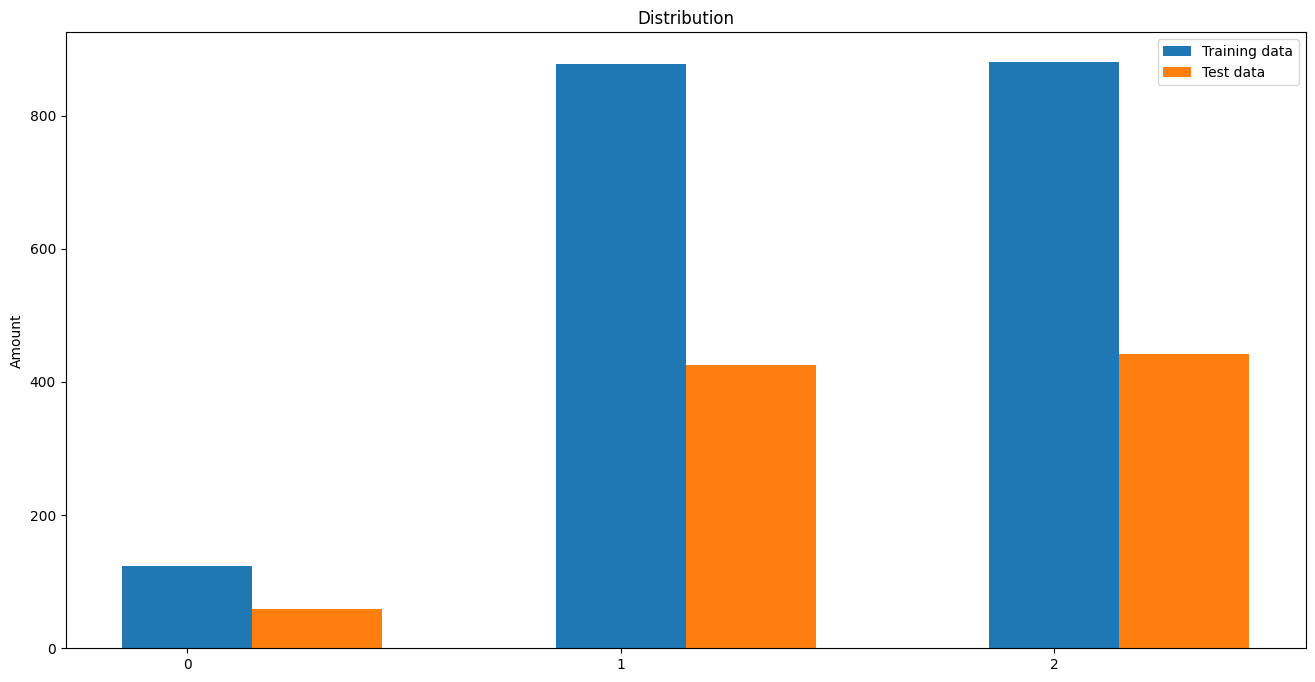


Example sequence from training set: [2 2 2 1 2] and its label: 0

Example sequence from training set: [2 2 1 2 1] and its label: 1


Random forest classifier accuracy: 45.85%
Random forest classifier accuracy: 44.66%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2761 - loss: 1.1038 - val_accuracy: 0.4746 - val_loss: 0.9694
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4553 - loss: 0.9641 - val_accuracy: 0.4768 - val_loss: 0.9342
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4648 - loss: 0.9401 - val_accuracy: 0.4768 - val_loss: 0.9205
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4734 - loss: 0.9108 - val_accuracy: 0.4768 - val_loss: 0.9108
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4605 - loss: 0.9054 - val_accuracy: 0.4768 - val_loss: 0.9044
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4840 - loss: 0.8935 - val_accuracy: 0.4768 - val_loss: 0.8998
Epoch 7/10
59/59 ━━━━━━

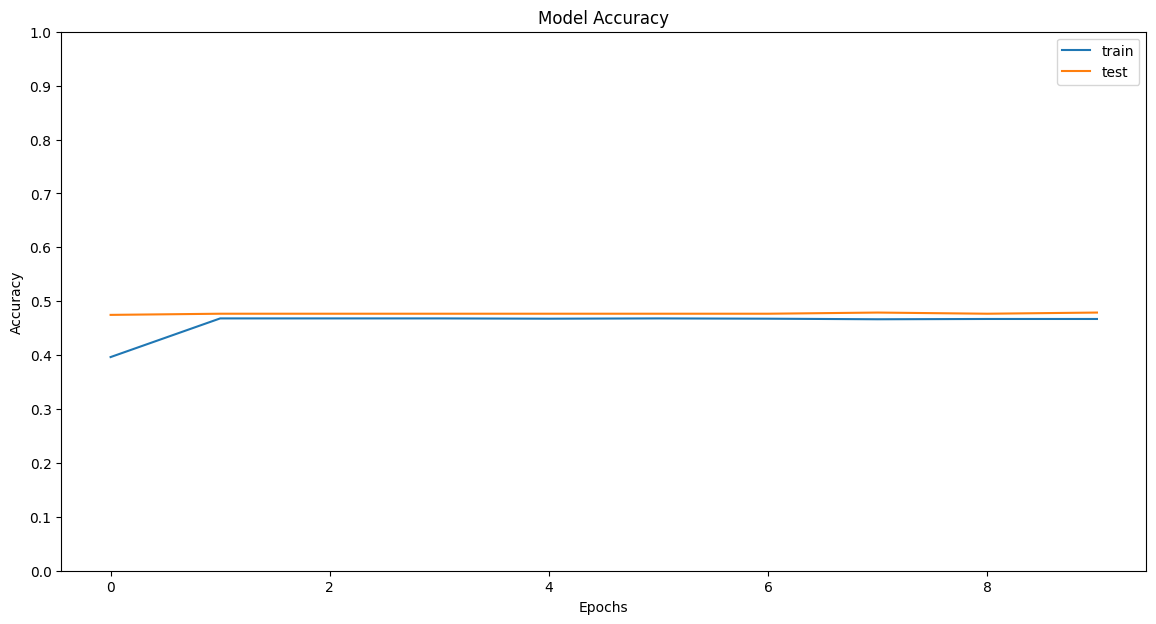

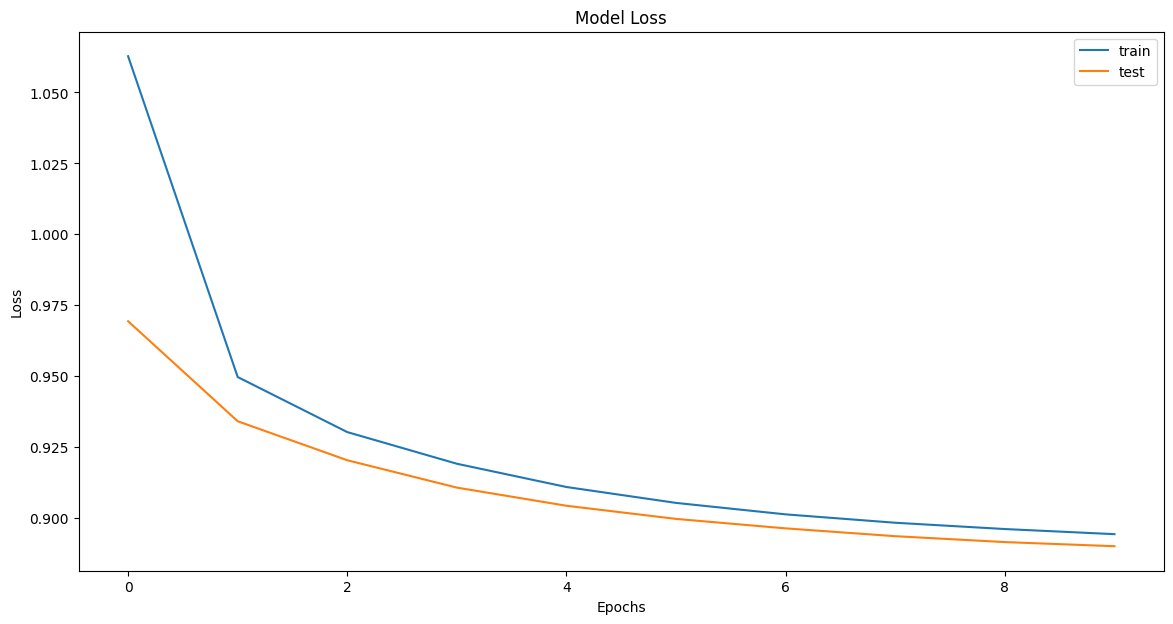

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.90%


For threshold set to 0.40, correctness is: 47.90%
For threshold set to 0.45, correctness is: 47.90%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4850 - loss: 1.0610 - val_accuracy: 0.4595 - val_loss: 0.9796
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4591 - loss: 0.9655 - val_accuracy: 0.4595 - val_loss: 0.9293
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 0.9169 - val_accuracy: 0.4595 - val_loss: 0.9130
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4697 - loss: 0.9264 - val_accuracy: 0.4595 - val_loss: 0.9049
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

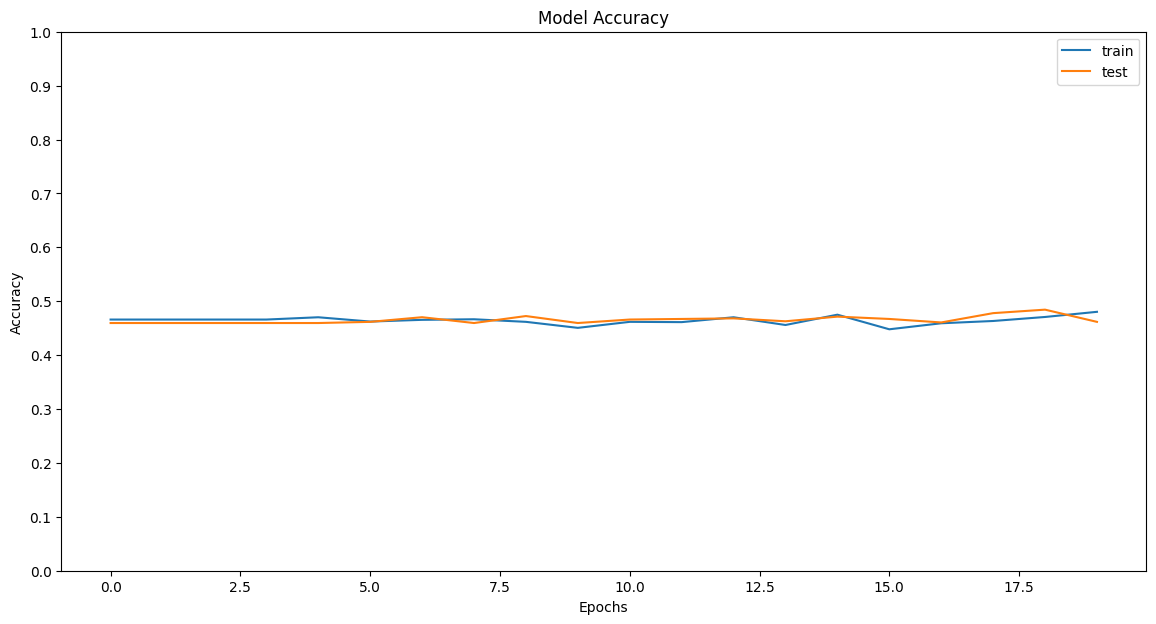

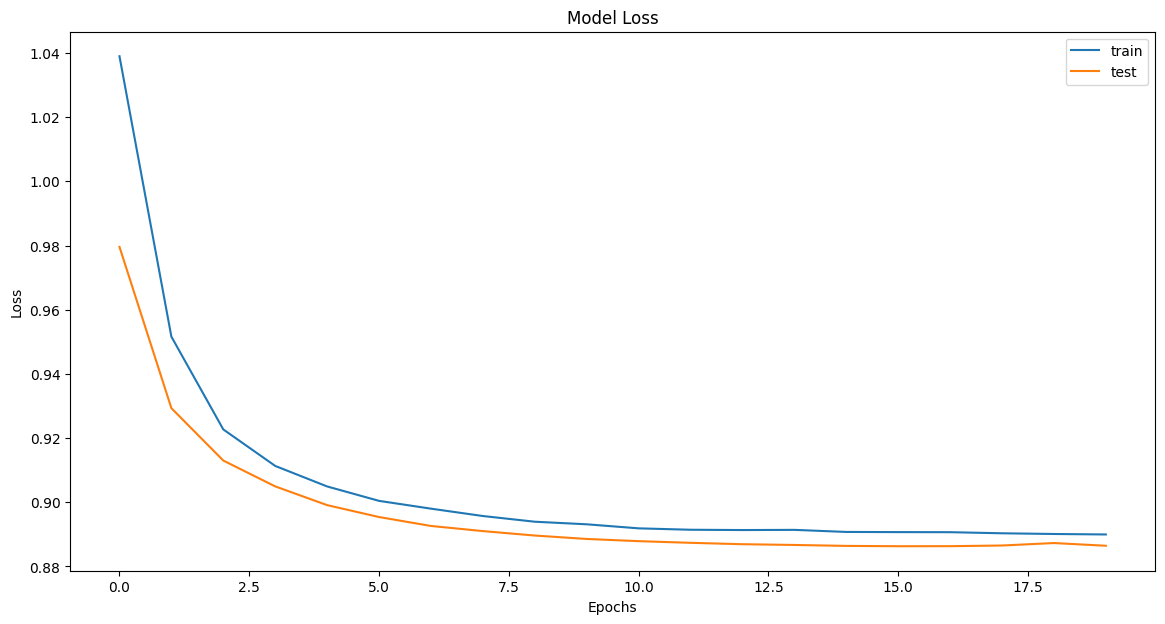

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 46.17%


For threshold set to 0.40, correctness is: 46.17%
For threshold set to 0.45, correctness is: 46.17%
For threshold set to 0.50, correctness is: 0.00%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4762 - loss: 1.0705 - val_accuracy: 0.4595 - val_loss: 1.0173
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4664 - loss: 0.9955 - val_accuracy: 0.4595 - val_loss: 0.9365
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4529 - loss: 0.9309 - val_accuracy: 0.4595 - val_loss: 0.9183
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4592 - loss: 0.9172 - val_accuracy: 0.4595 - val_loss: 0.9090
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

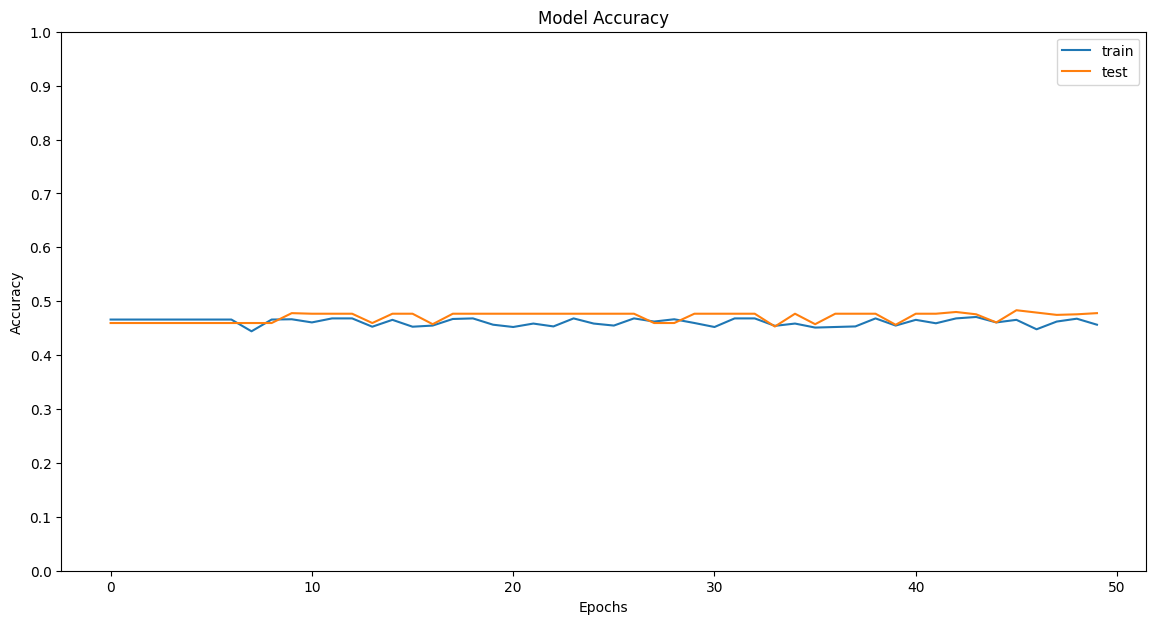

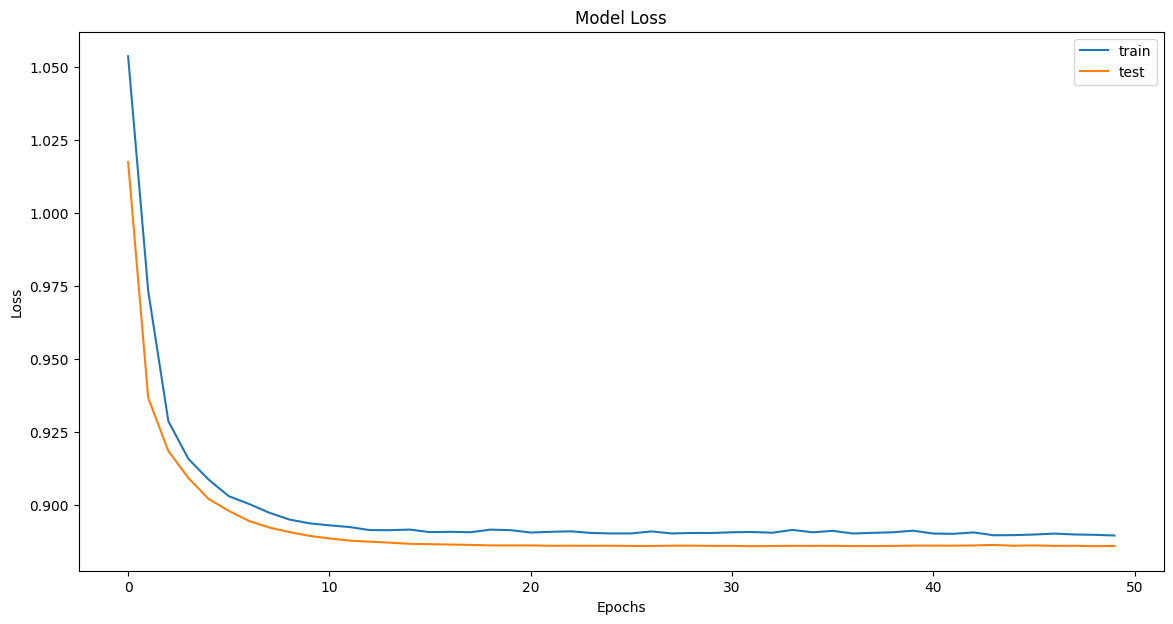

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 47.79%


For threshold set to 0.40, correctness is: 47.79%
For threshold set to 0.45, correctness is: 47.79%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



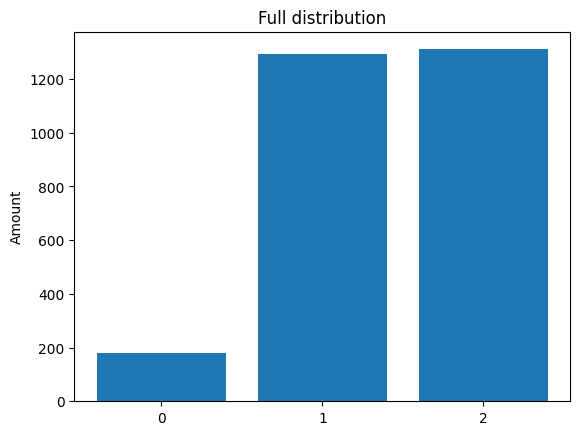

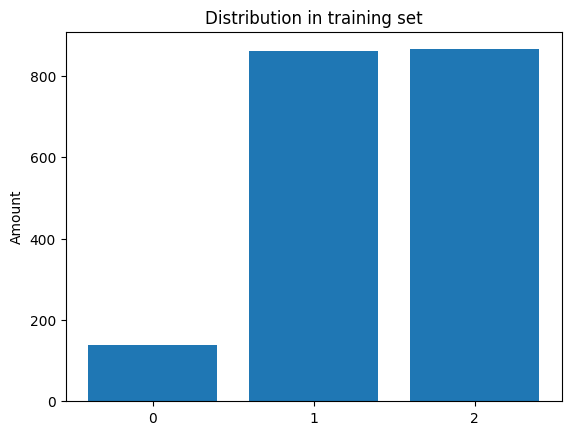

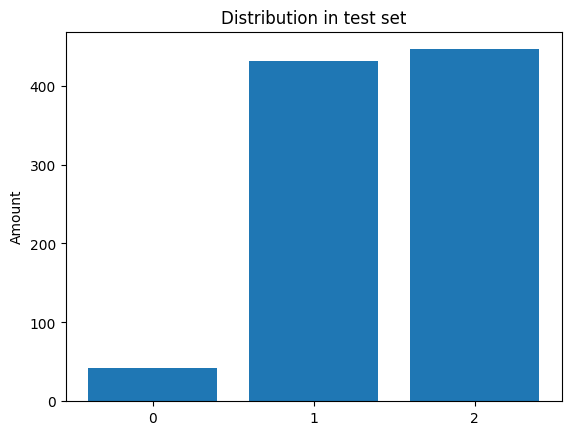

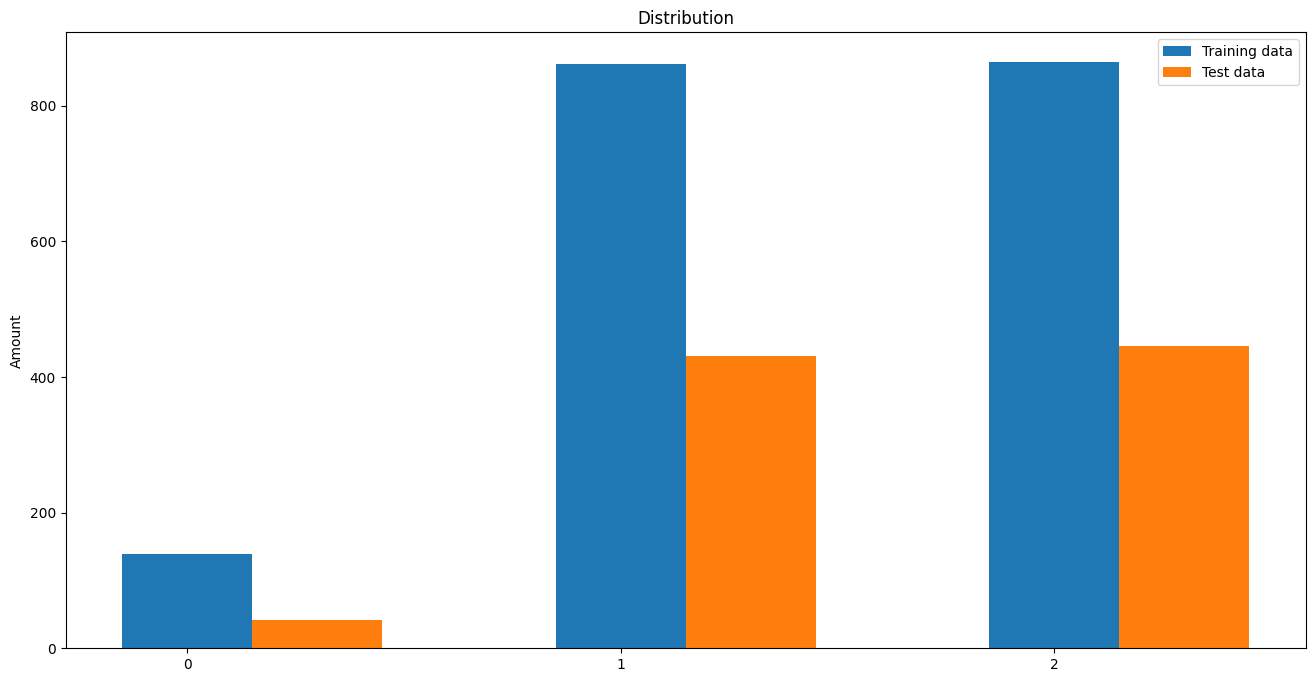


Example sequence from training set: [1 2 1 1 1 1 2 2 2 1] and its label: 2

Example sequence from training set: [1 2 2 1 2 1 2 1 2 2] and its label: 1


Random forest classifier accuracy: 46.57%
Random forest classifier accuracy: 42.33%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4354 - loss: 1.0593 - val_accuracy: 0.4690 - val_loss: 0.9811
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4792 - loss: 0.9771 - val_accuracy: 0.4690 - val_loss: 0.9134
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4679 - loss: 0.9369 - val_accuracy: 0.4690 - val_loss: 0.8783
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4487 - loss: 0.9167 - val_accuracy: 0.4690 - val_loss: 0.8685
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4454 - loss: 0.9152 - val_accuracy: 0.4690 - val_loss: 0.8638
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4831 - loss: 0.9078 - val_accuracy: 0.4690 - val_loss: 0.8615
Epo

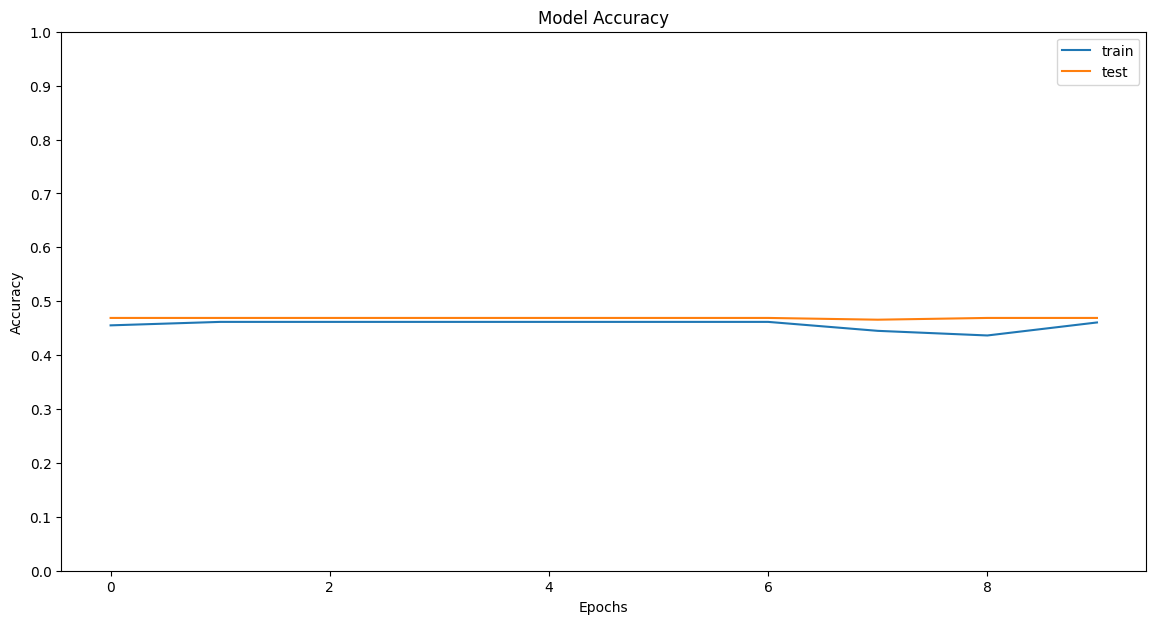

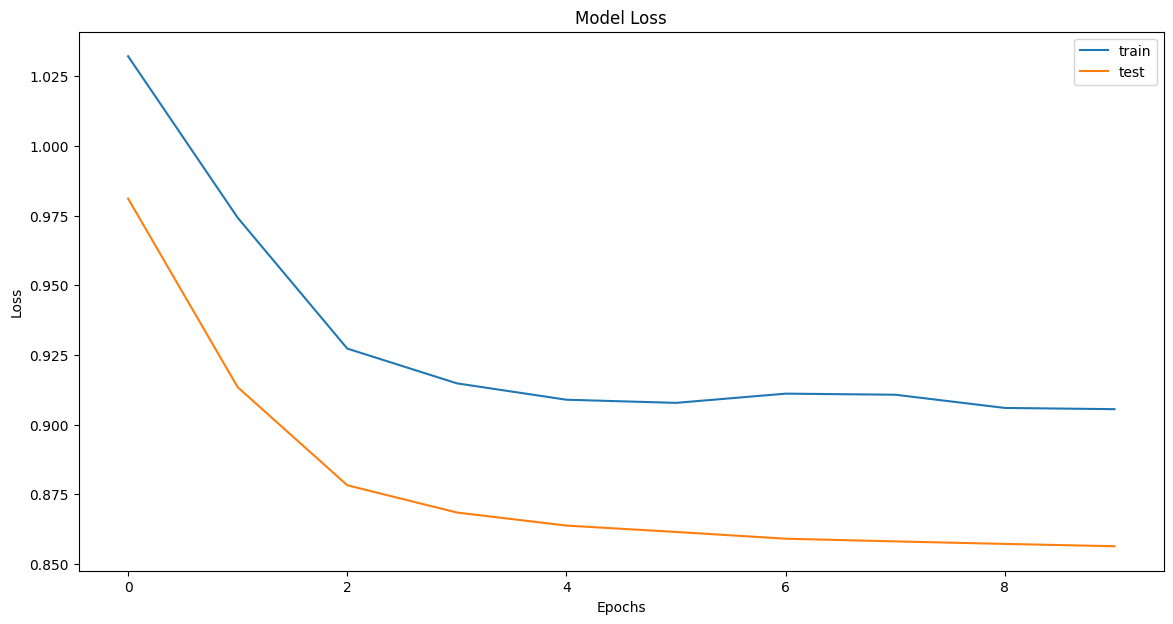

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 46.90%


For threshold set to 0.40, correctness is: 46.90%
For threshold set to 0.45, correctness is: 46.90%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4818 - loss: 1.0006 - val_accuracy: 0.4733 - val_loss: 0.9216
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4625 - loss: 0.9500 - val_accuracy: 0.4690 - val_loss: 0.9035
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4846 - loss: 0.9321 - val_accuracy: 0.4788 - val_loss: 0.8906
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4655 - loss: 0.9096 - val_accuracy: 0.4712 - val_loss: 0.8823
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

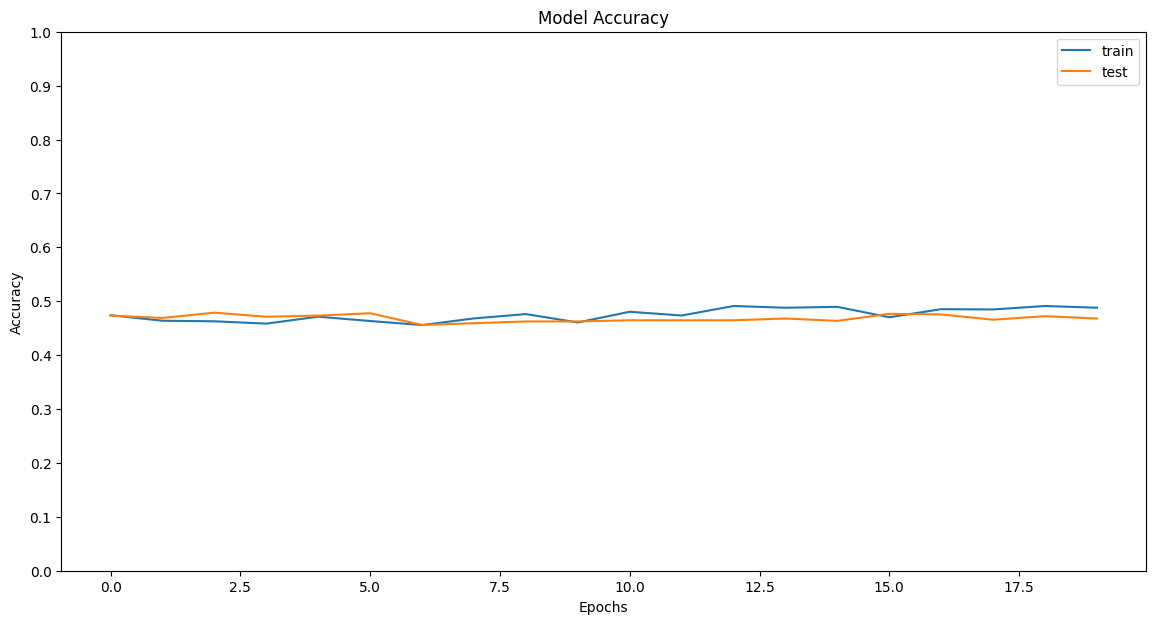

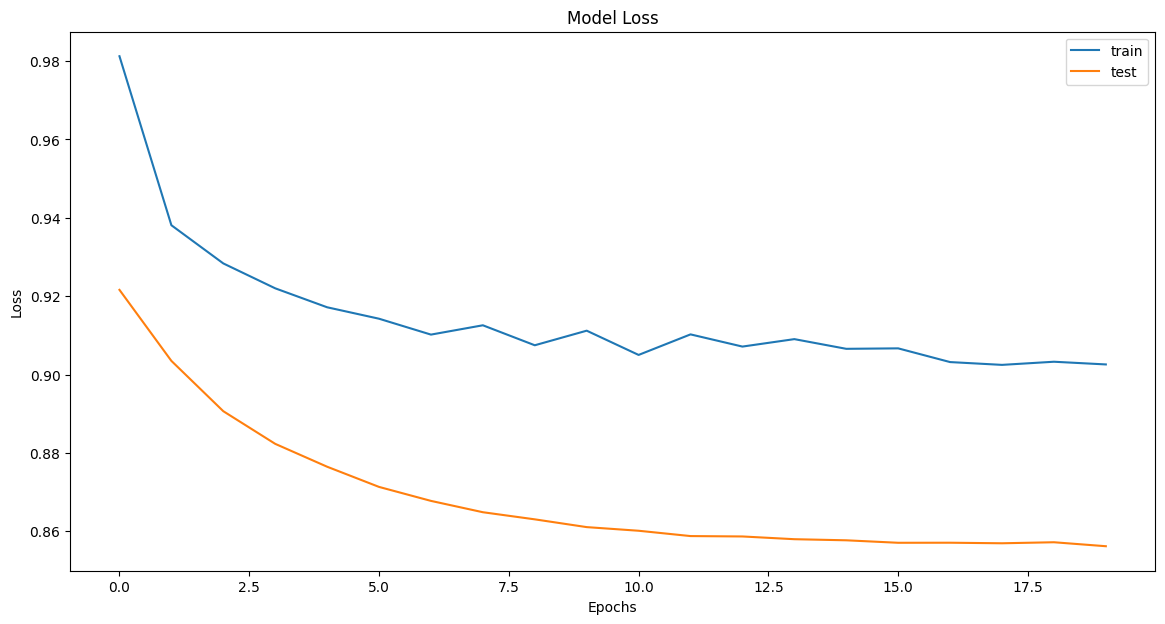

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 46.79%


For threshold set to 0.40, correctness is: 46.79%
For threshold set to 0.45, correctness is: 46.79%
For threshold set to 0.50, correctness is: 33.33%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4504 - loss: 1.0072 - val_accuracy: 0.4690 - val_loss: 0.9300
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4510 - loss: 0.9543 - val_accuracy: 0.4690 - val_loss: 0.9000
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.9276 - val_accuracy: 0.4690 - val_loss: 0.8836
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4597 - loss: 0.9261 - val_accuracy: 0.4690 - val_loss: 0.8744
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

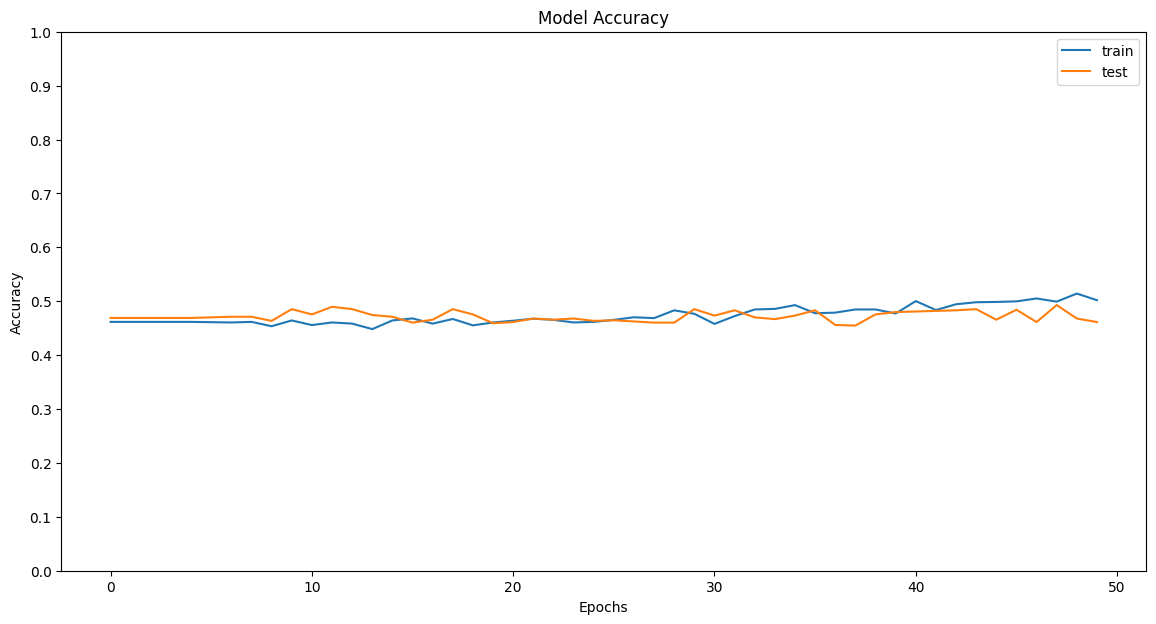

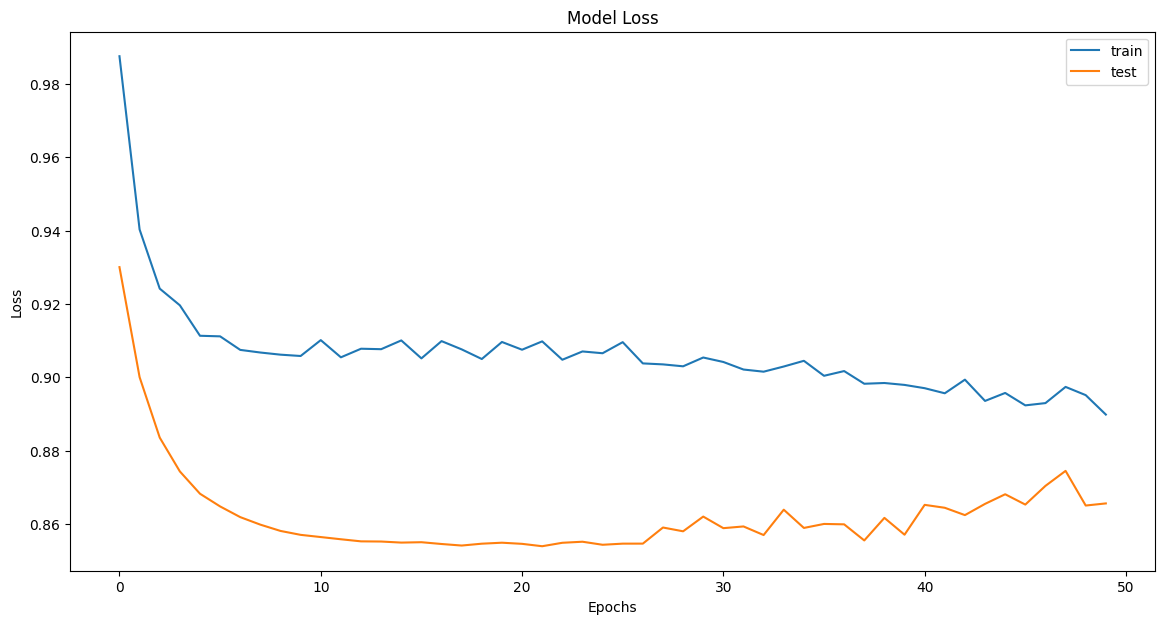

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 46.14%


For threshold set to 0.40, correctness is: 46.14%
For threshold set to 0.45, correctness is: 46.14%
For threshold set to 0.50, correctness is: 47.07%
For threshold set to 0.55, correctness is: 33.33%
For threshold set to 0.60, correctness is: 0.00%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



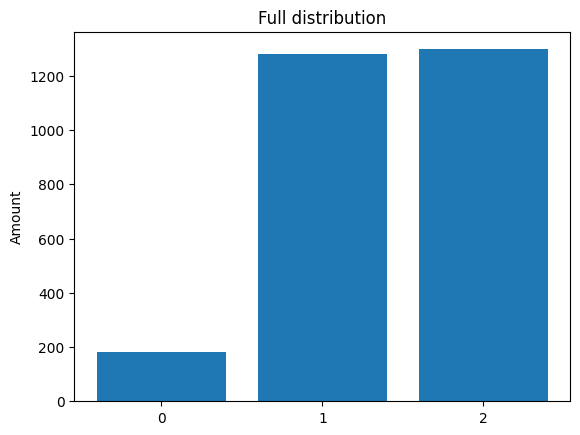

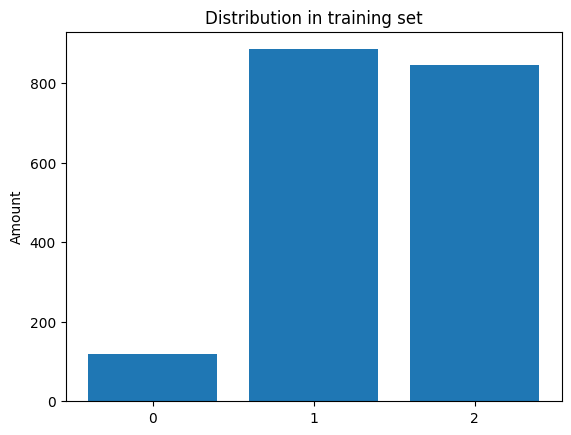

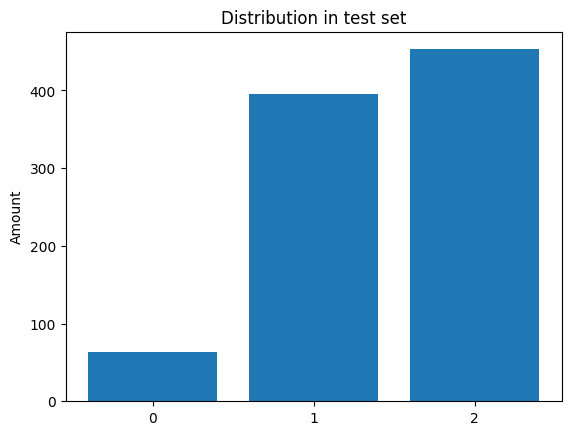

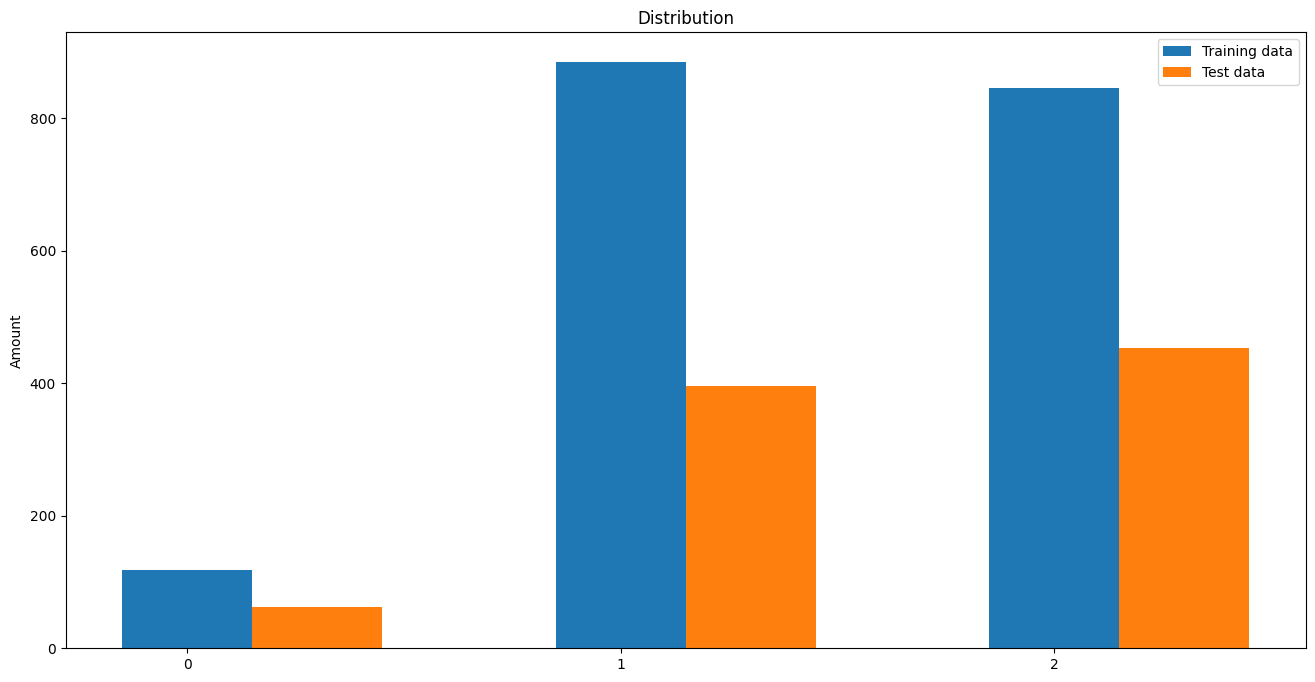


Example sequence from training set: [1 2 1 1 2 1 1 2 2 2 2 0 1 1 1] and its label: 1

Example sequence from training set: [1 1 2 1 2 2 1 0 2 2 1 1 1 1 2] and its label: 2


Random forest classifier accuracy: 44.24%
Random forest classifier accuracy: 42.70%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4558 - loss: 1.0631 - val_accuracy: 0.4336 - val_loss: 0.9552
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4751 - loss: 0.9111 - val_accuracy: 0.4336 - val_loss: 0.9064
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4707 - loss: 0.8943 - val_accuracy: 0.4336 - val_loss: 0.9035
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4892 - loss: 0.8878 - val_accuracy: 0.4336 - val_loss: 0.9010
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4575 - loss: 0.8932 - val_accuracy: 0.4336 - val_loss: 0.9004
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4813 - loss: 0.8835 - val_accuracy: 0.4336 - 

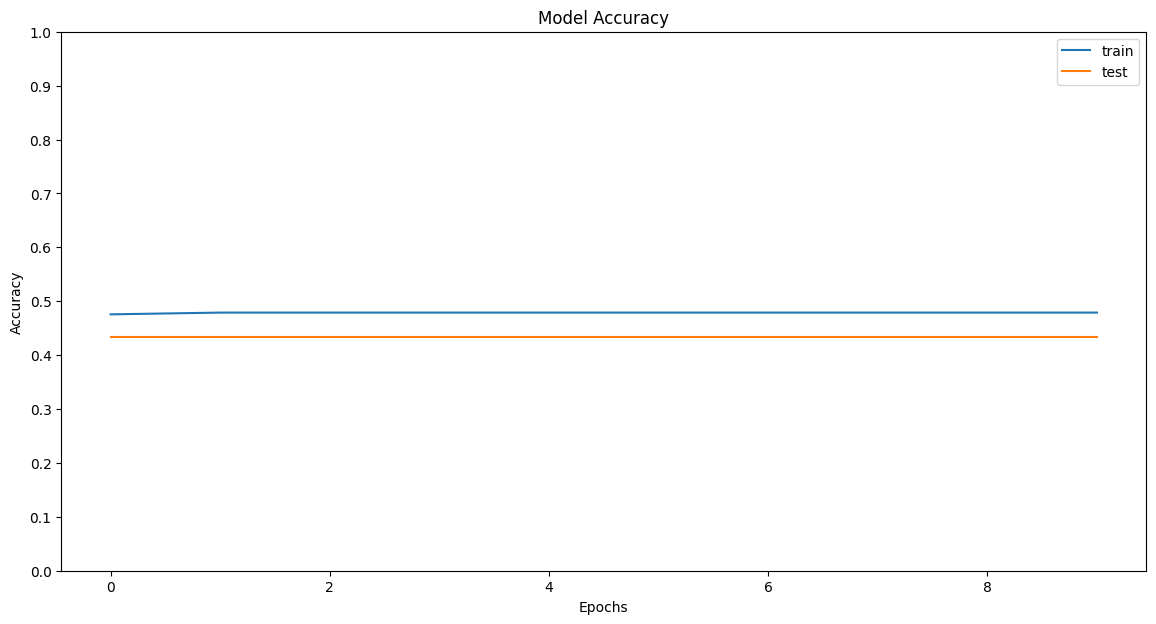

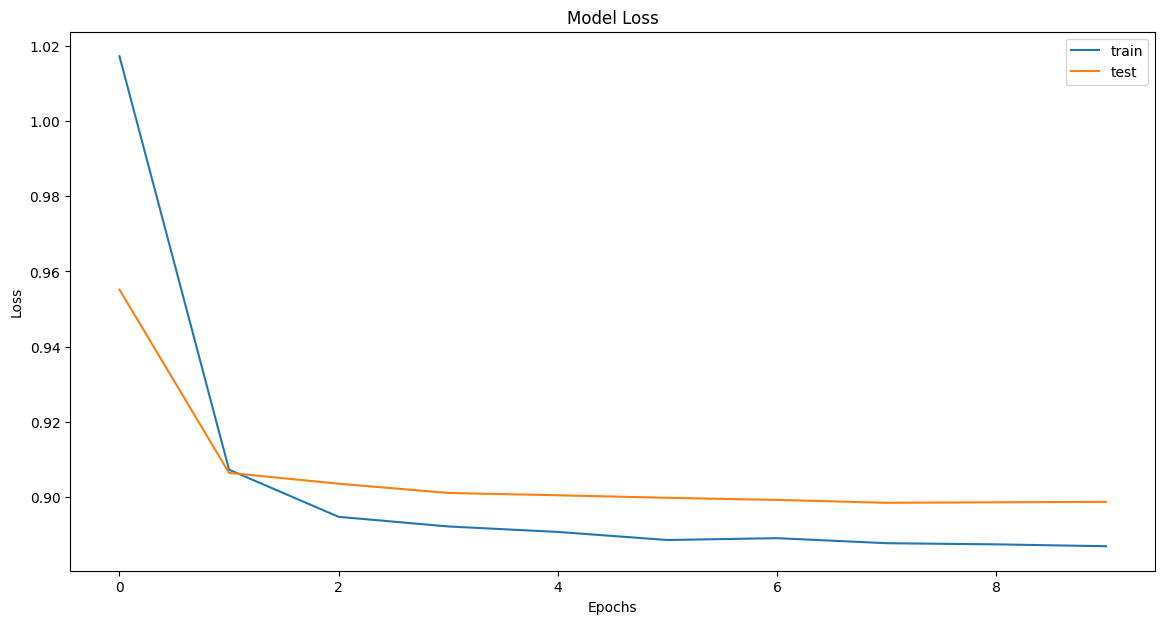

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 43.36%


For threshold set to 0.40, correctness is: 43.36%
For threshold set to 0.45, correctness is: 43.36%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4805 - loss: 1.0426 - val_accuracy: 0.4336 - val_loss: 0.9905
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4693 - loss: 0.9598 - val_accuracy: 0.4336 - val_loss: 0.9501
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4796 - loss: 0.9193 - val_accuracy: 0.4336 - val_loss: 0.9173
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4608 - loss: 0.9282 - val_accuracy: 0.4336 - val_loss: 0.9090
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

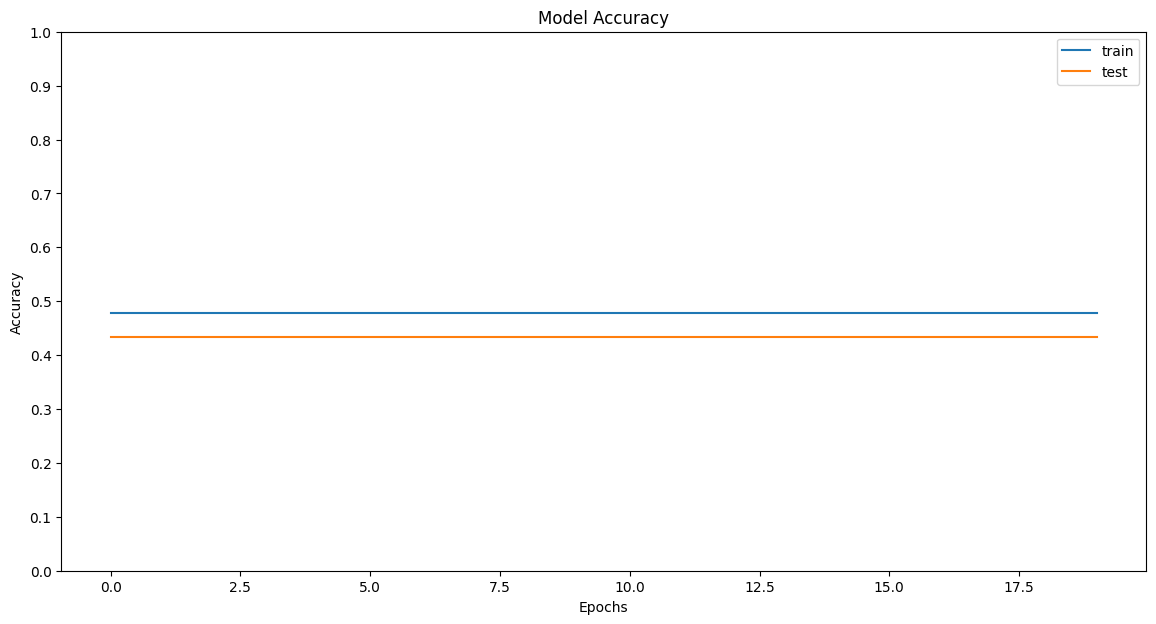

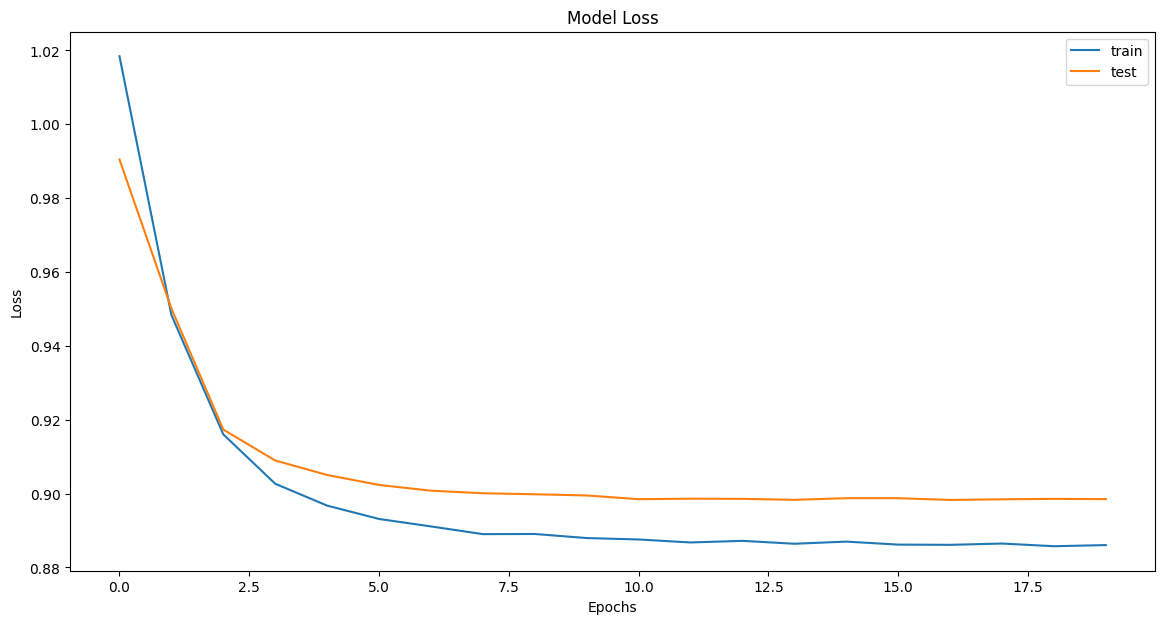

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Modal accuracy on test set: 43.36%


For threshold set to 0.40, correctness is: 43.36%
For threshold set to 0.45, correctness is: 43.36%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4619 - loss: 1.0222 - val_accuracy: 0.4336 - val_loss: 0.9771
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4868 - loss: 0.9595 - val_accuracy: 0.4336 - val_loss: 0.9538
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 0.9336 - val_accuracy: 0.4303 - val_loss: 0.9375
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4825 - loss: 0.9203 - val_accuracy: 0.4270 - val_loss: 0.9268
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

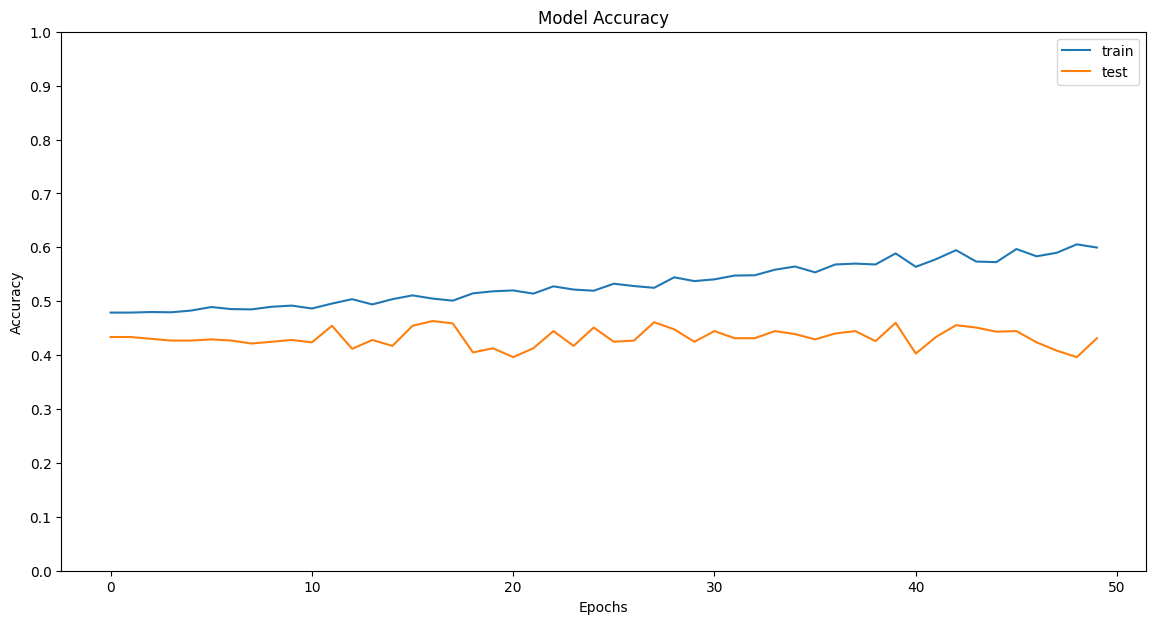

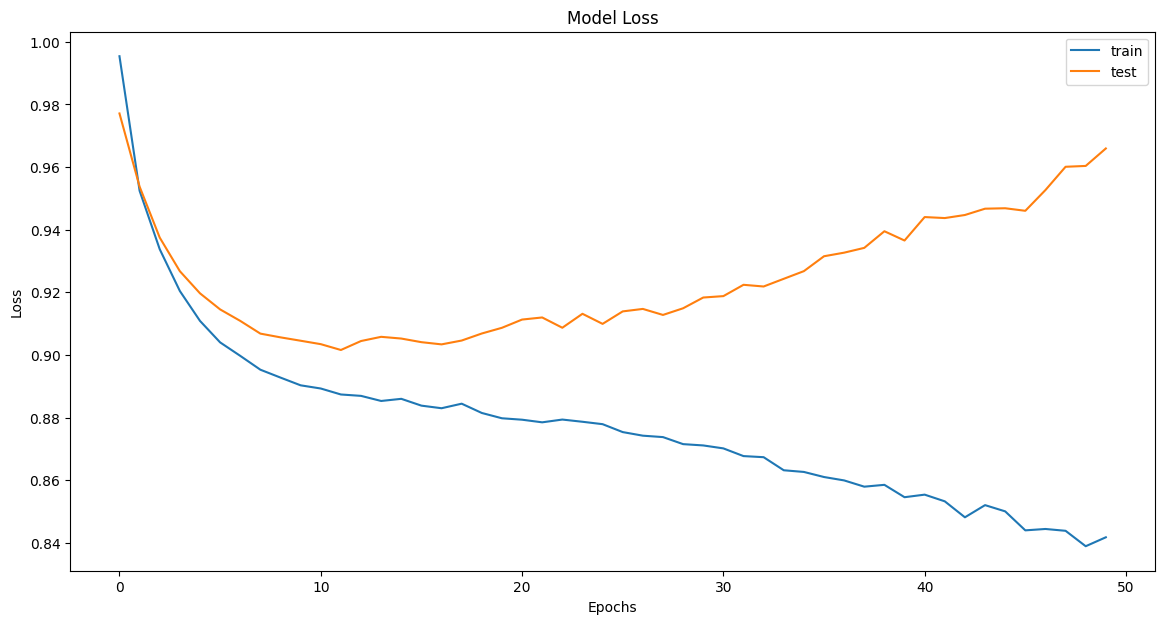

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 43.14%


For threshold set to 0.40, correctness is: 43.14%
For threshold set to 0.45, correctness is: 43.14%
For threshold set to 0.50, correctness is: 42.62%
For threshold set to 0.55, correctness is: 42.64%
For threshold set to 0.60, correctness is: 40.52%
For threshold set to 0.65, correctness is: 26.53%
For threshold set to 0.70, correctness is: 21.43%
For threshold set to 0.75, correctness is: 20.00%
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



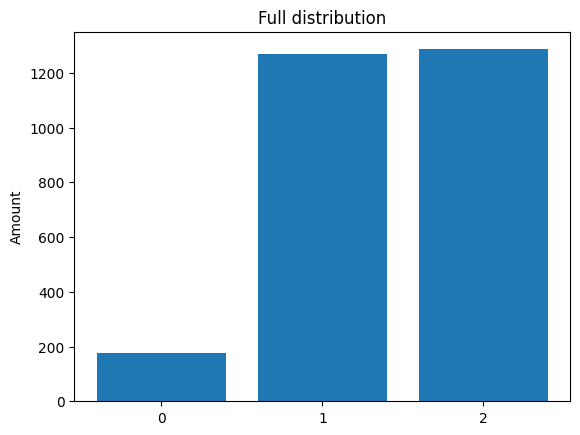

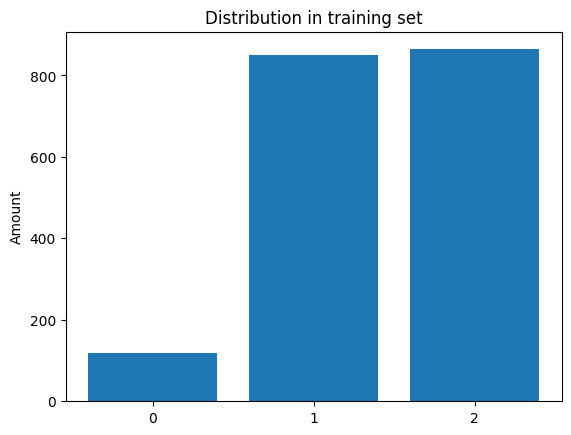

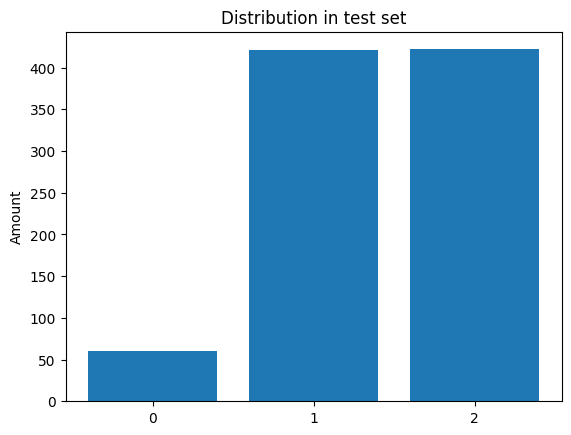

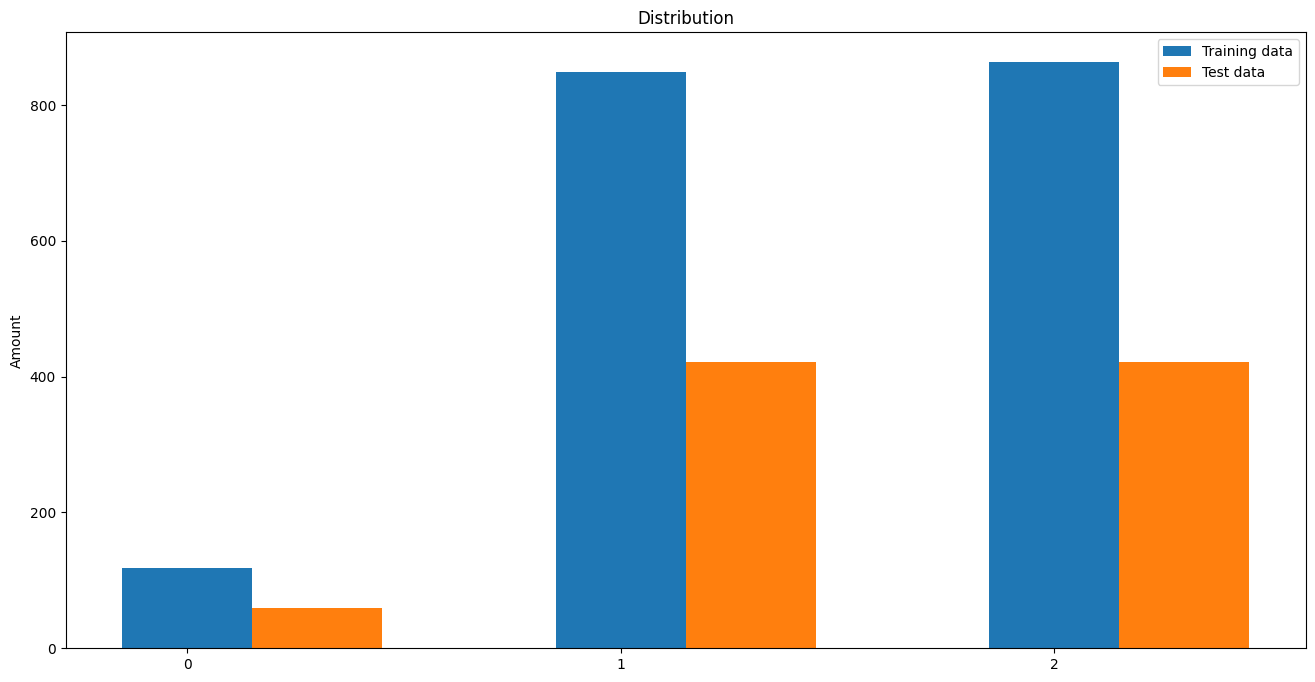


Example sequence from training set: [1 1 2 1 1 1 2 1 2 2 0 1 1 2 2 2 2 1 1 1] and its label: 2

Example sequence from training set: [1 2 2 1 0 2 2 1 1 1 1 2 2 1 2 1 1 2 1 2] and its label: 1


Random forest classifier accuracy: 45.18%
Random forest classifier accuracy: 46.40%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4608 - loss: 1.0837 - val_accuracy: 0.4385 - val_loss: 1.0068
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4628 - loss: 0.9845 - val_accuracy: 0.4673 - val_loss: 0.9300
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4660 - loss: 0.9309 - val_accuracy: 0.4673 - val_loss: 0.9150
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4563 - loss: 0.9213 - val_accuracy: 0.4673 - val_loss: 0.9068
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4802 - loss: 0.9025 - val_accuracy: 0.4673 - val_loss: 0.9012
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4674 - loss: 0.9068 - val

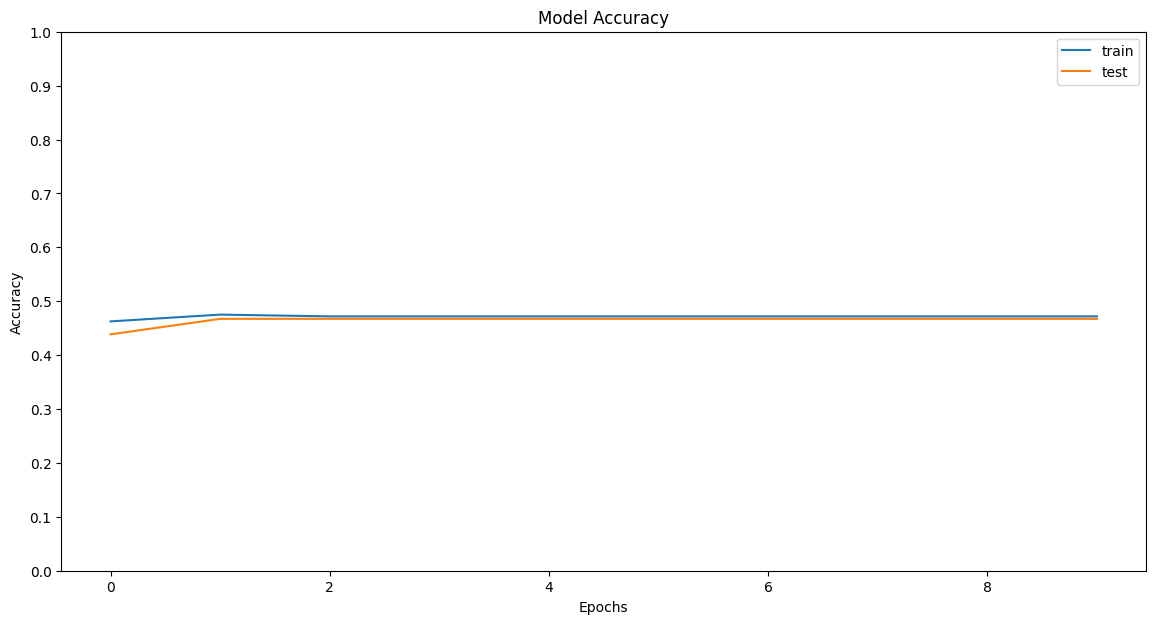

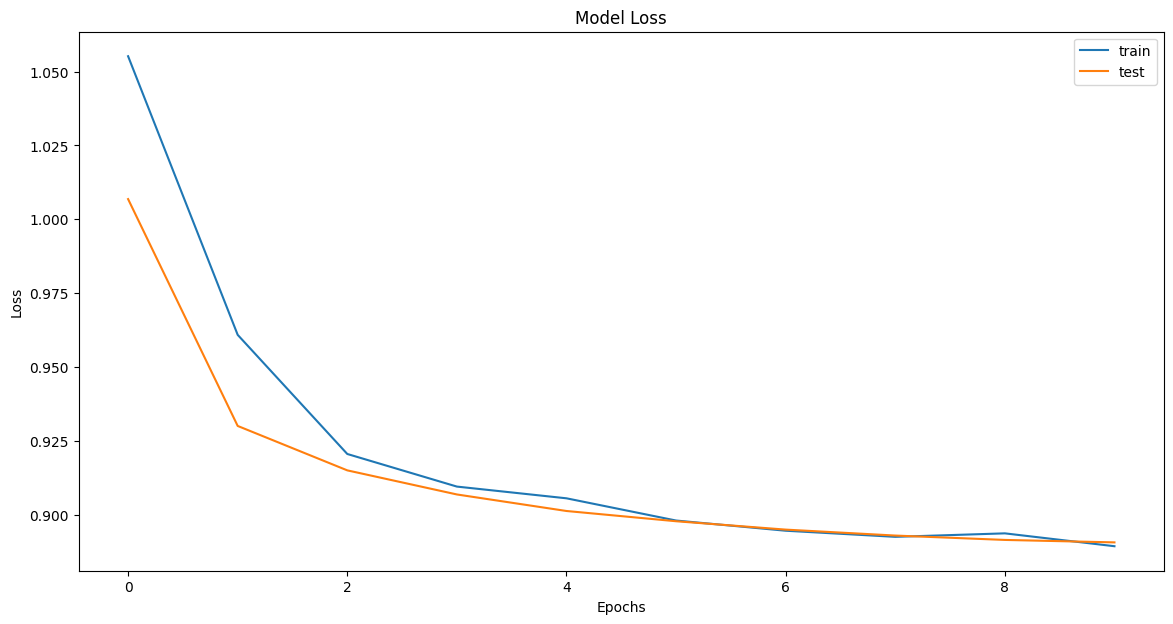

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 46.73%


For threshold set to 0.40, correctness is: 46.73%
For threshold set to 0.45, correctness is: 46.73%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4893 - loss: 1.0556 - val_accuracy: 0.4673 - val_loss: 0.9647
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4772 - loss: 0.9431 - val_accuracy: 0.4673 - val_loss: 0.9346
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4715 - loss: 0.9264 - val_accuracy: 0.4662 - val_loss: 0.9198
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4736 - loss: 0.9093 - val_accuracy: 0.4673 - val_loss: 0.9105
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

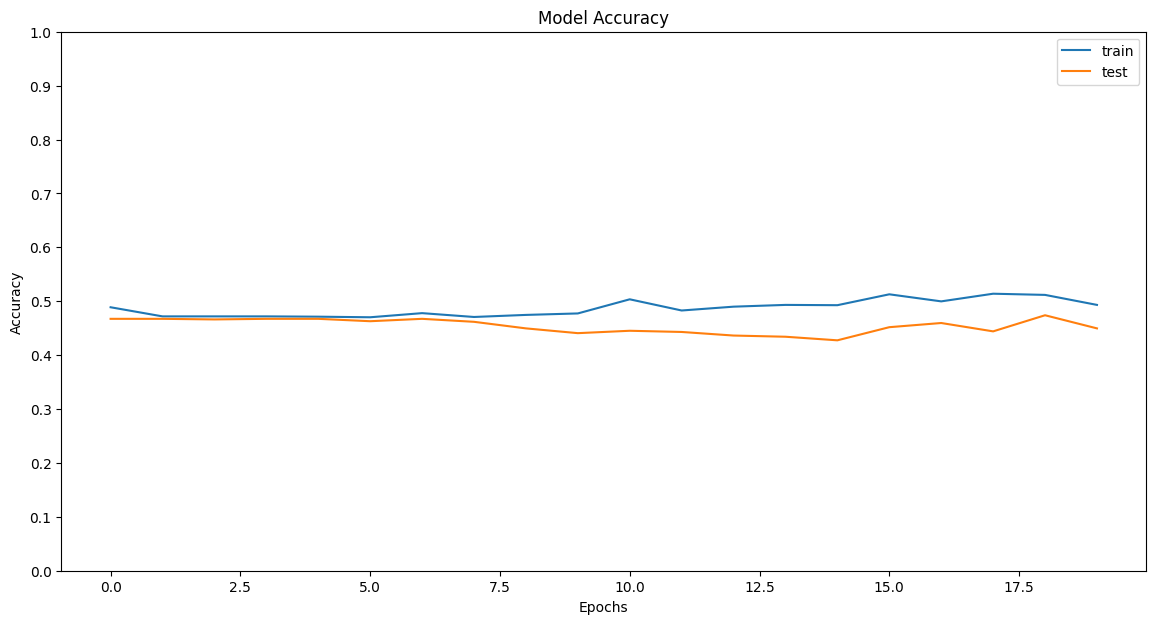

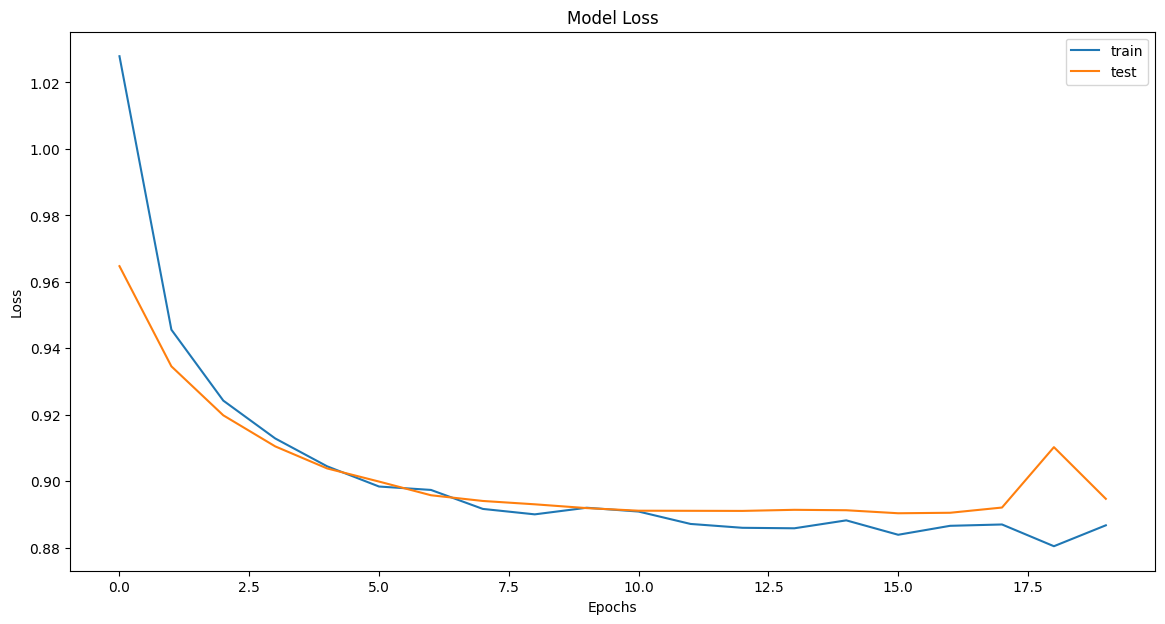

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Modal accuracy on test set: 44.96%


For threshold set to 0.40, correctness is: 44.96%
For threshold set to 0.45, correctness is: 44.96%
For threshold set to 0.50, correctness is: 43.21%
For threshold set to 0.55, correctness is: 46.67%
For threshold set to 0.60, correctness is: 66.67%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2699 - loss: 1.1170 - val_accuracy: 0.4662 - val_loss: 1.0165
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4882 - loss: 1.0044 - val_accuracy: 0.4662 - val_loss: 0.9718
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4591 - loss: 0.9667 - val_accuracy: 0.4662 - val_loss: 0.9491
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4606 - loss: 0.9460 - val_accuracy: 0.4662 - val_loss: 0.9332
Epoch 5

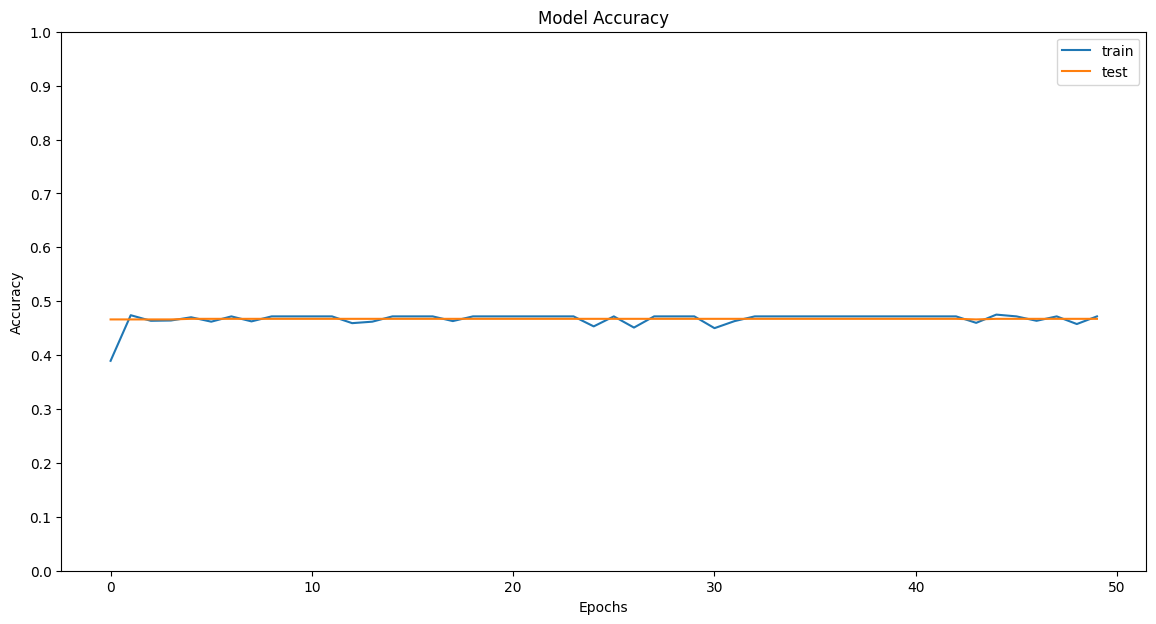

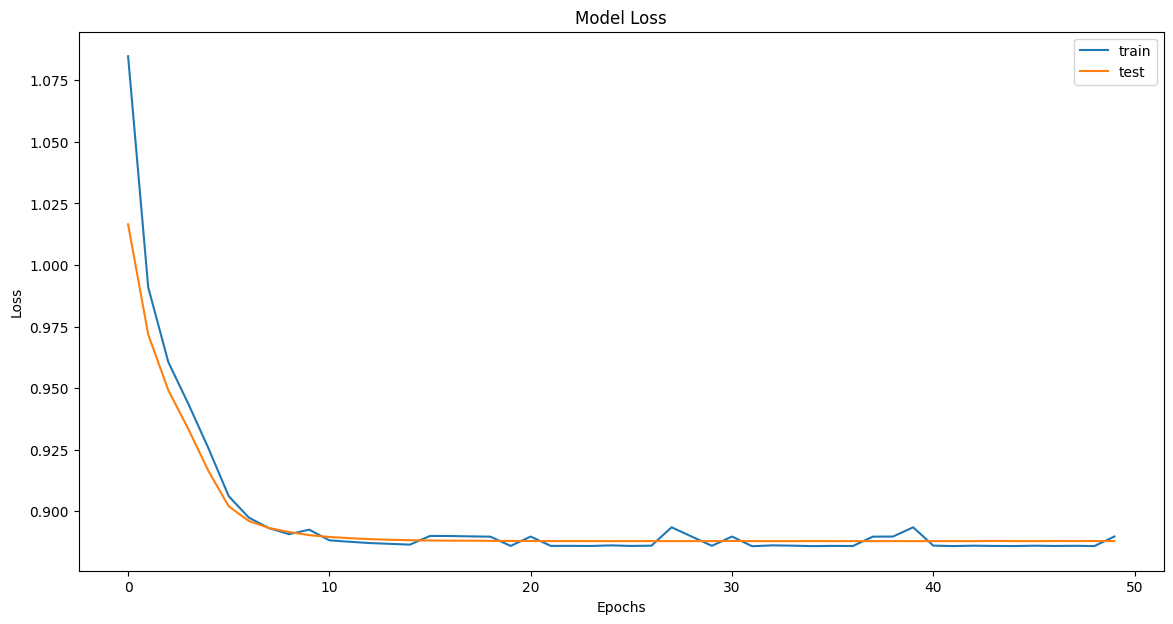

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 46.73%


For threshold set to 0.40, correctness is: 46.73%
For threshold set to 0.45, correctness is: 46.73%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



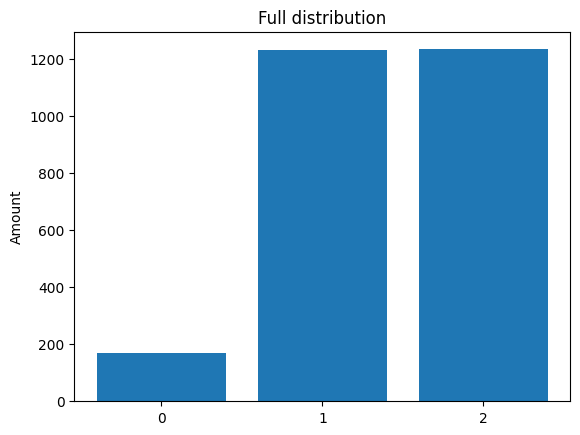

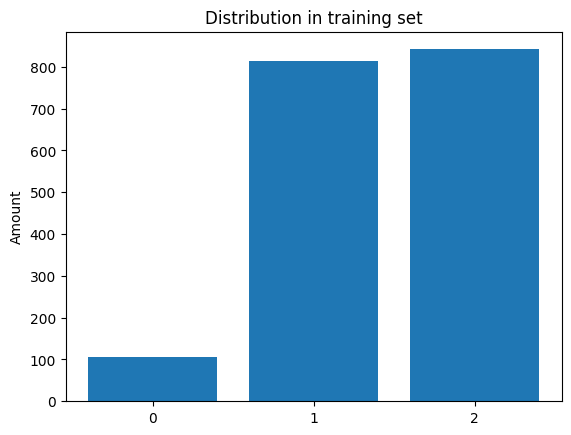

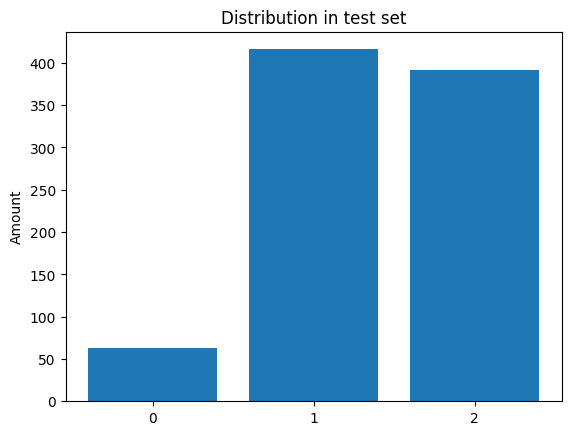

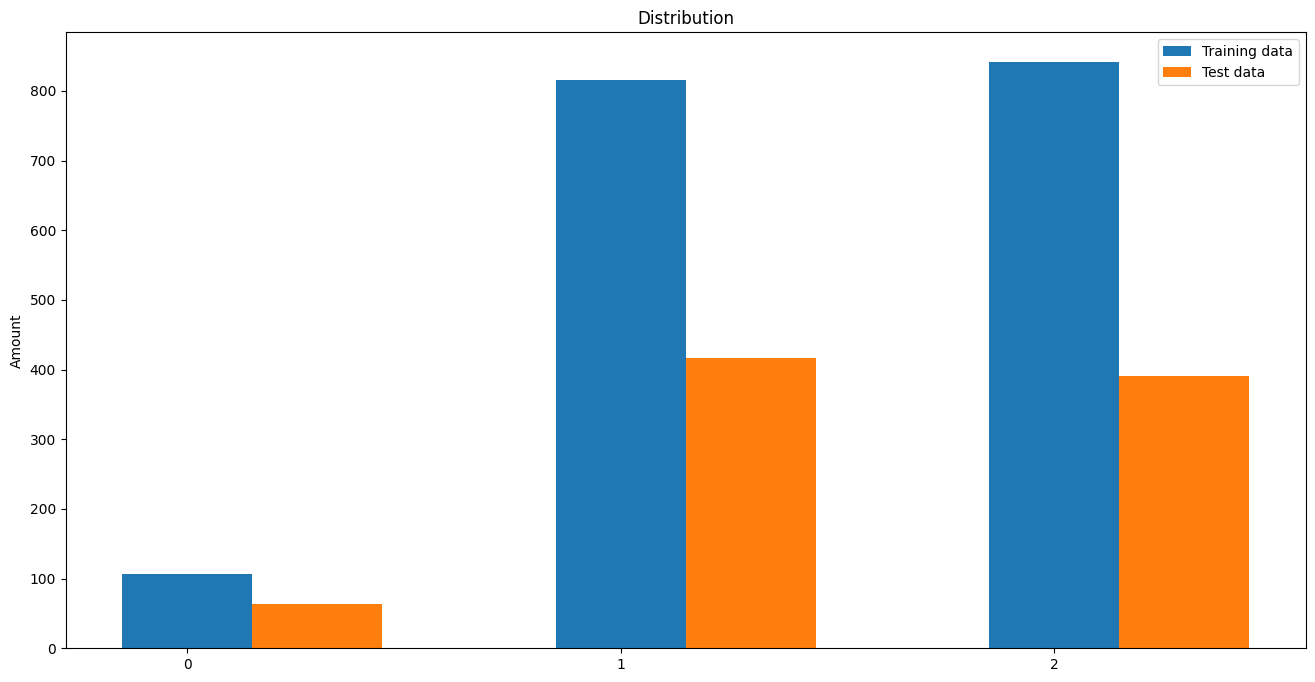


Example sequence from training set: [0 2 1 2 1 1 1 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1 1 1 2 0 2 1 1 2 1 1 0 1 1 1
 2 1 1] and its label: 1

Example sequence from training set: [0 1 1 2 1 2 2 1 1 1 2 2 1 2 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 0 2 2 1
 2 1 2] and its label: 1


Random forest classifier accuracy: 46.09%
Random forest classifier accuracy: 44.25%


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4737 - loss: 0.9720 - val_accuracy: 0.4563 - val_loss: 0.9440
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4820 - loss: 0.9311 - val_accuracy: 0.4494 - val_loss: 0.9371
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4878 - loss: 0.9141 - val_accuracy: 0.4575 - val_loss: 0.9208
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4780 - loss: 0.9112 - val_accuracy: 0.4552 - val_loss: 0.9154
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5023 - loss: 0.8876 - val_accuracy: 0.4529 - val_loss: 0.9140
Epoch 6

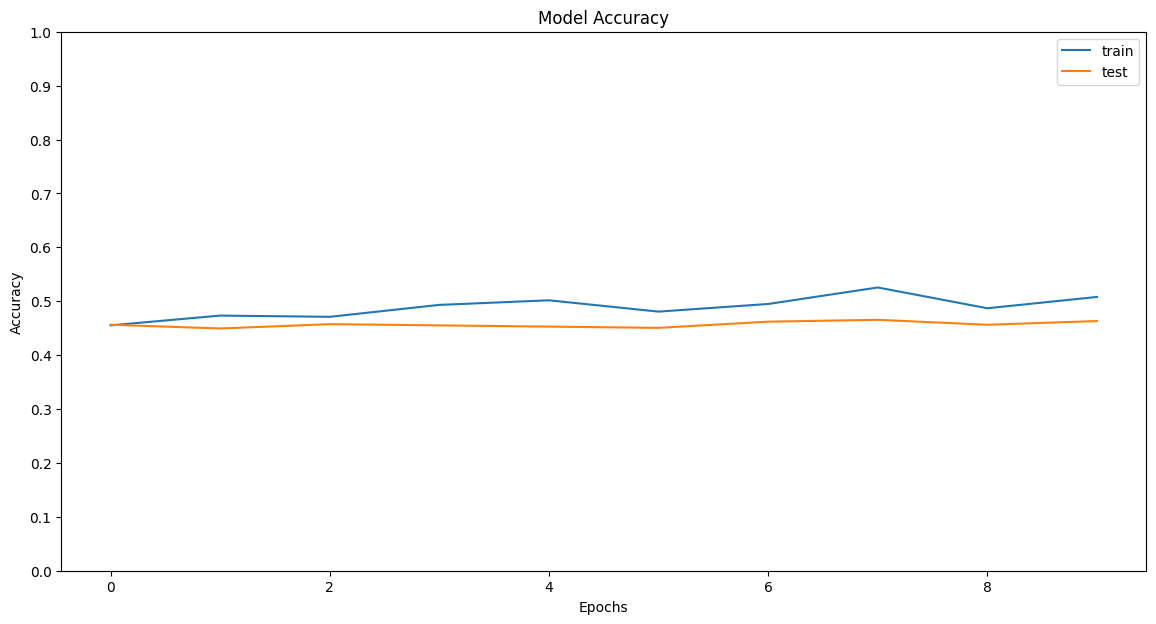

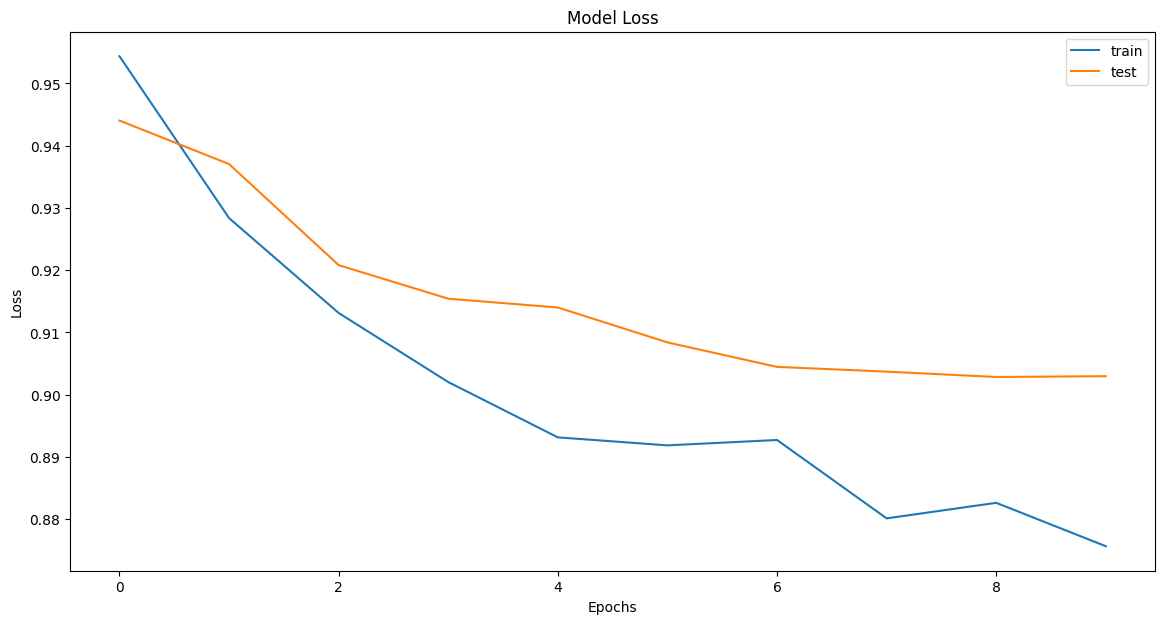

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 46.32%


For threshold set to 0.40, correctness is: 46.32%
For threshold set to 0.45, correctness is: 46.32%
For threshold set to 0.50, correctness is: 50.68%
For threshold set to 0.55, correctness is: 66.67%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4586 - loss: 1.0502 - val_accuracy: 0.4448 - val_loss: 0.9553
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4758 - loss: 0.9409 - val_accuracy: 0.4494 - val_loss: 0.9386
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4644 - loss: 0.9268 - val_accuracy: 0.4575 - val_loss: 0.9225
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4981 - loss: 0.8987 - val_accuracy: 0.4598 - val_loss: 0.9157
Epoch 5/20
56/56 ━━━━━━━━

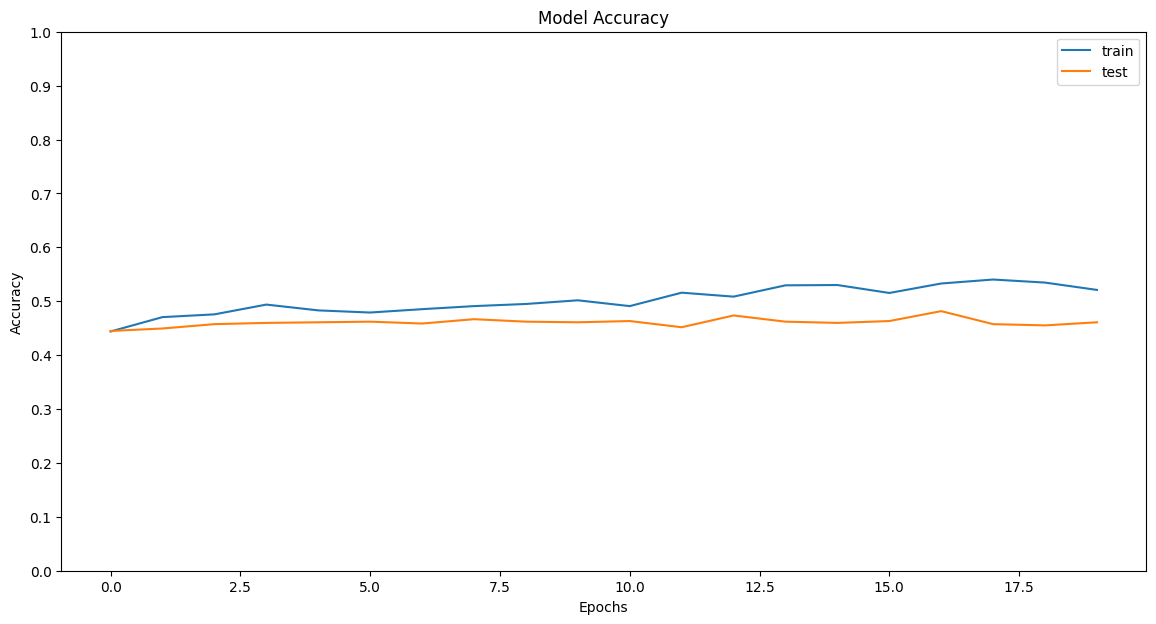

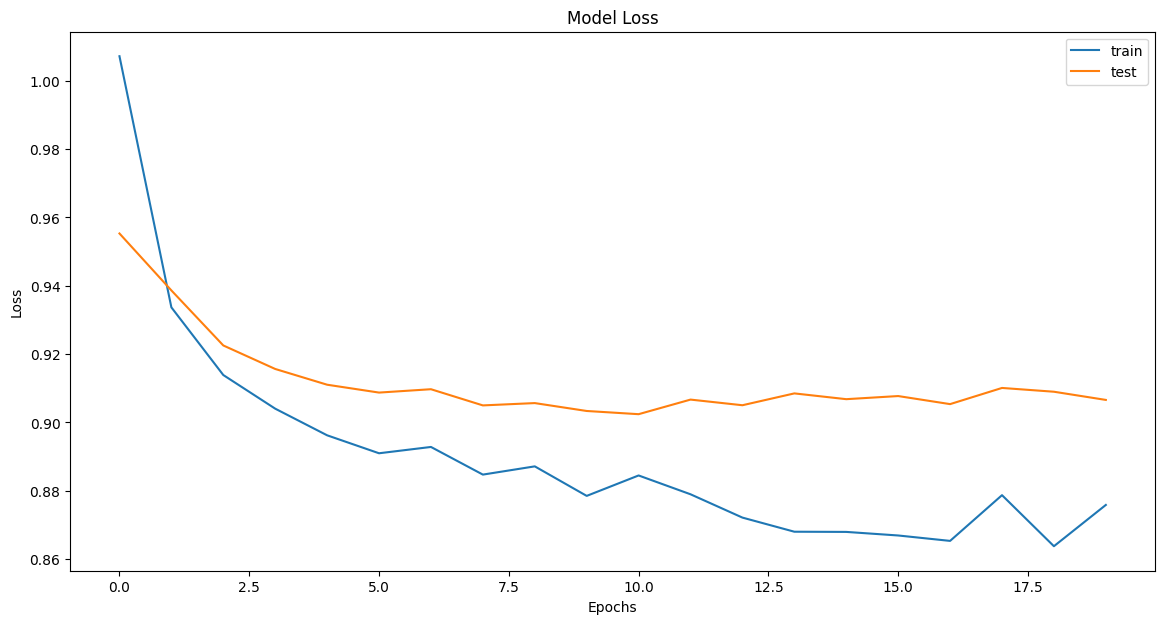

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modal accuracy on test set: 46.09%


For threshold set to 0.40, correctness is: 46.09%
For threshold set to 0.45, correctness is: 46.09%
For threshold set to 0.50, correctness is: 48.67%
For threshold set to 0.55, correctness is: 46.41%
For threshold set to 0.60, correctness is: 63.64%
For threshold set to 0.65, correctness is: 33.33%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4437 - loss: 1.0724 - val_accuracy: 0.4494 - val_loss: 0.9950
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4623 - loss: 0.9821 - val_accuracy: 0.4494 - val_loss: 0.9628
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4767 - loss: 0.9472 - val_accuracy: 0.4494 - val_loss: 0.9429
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4842 - loss: 0.9171 - val_accuracy: 0.4494 - val_lo

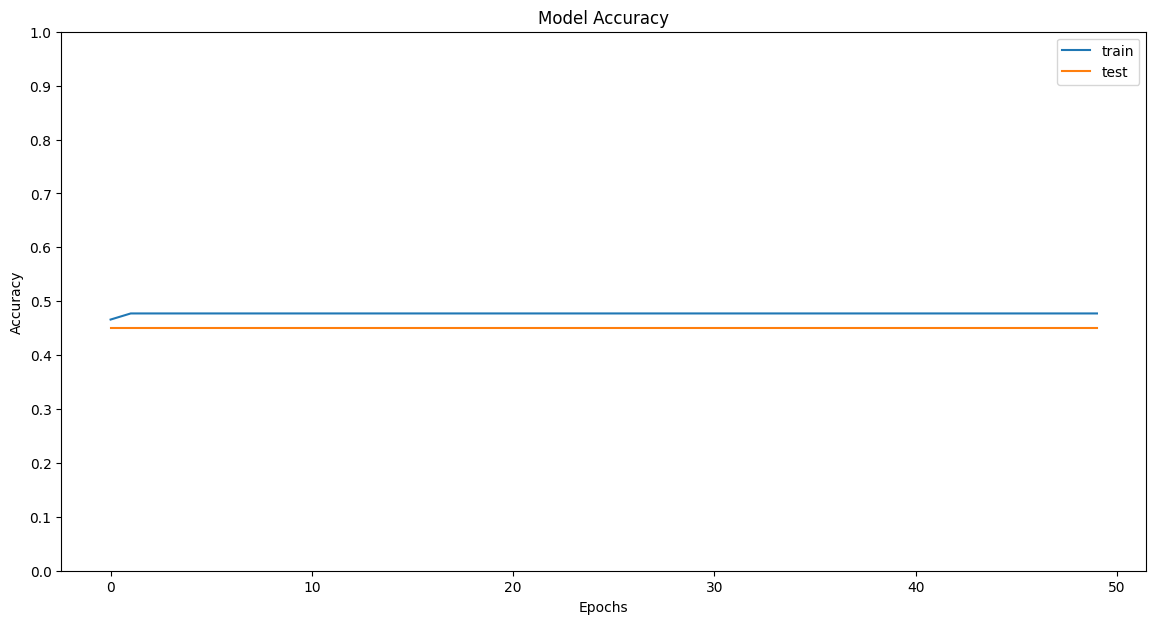

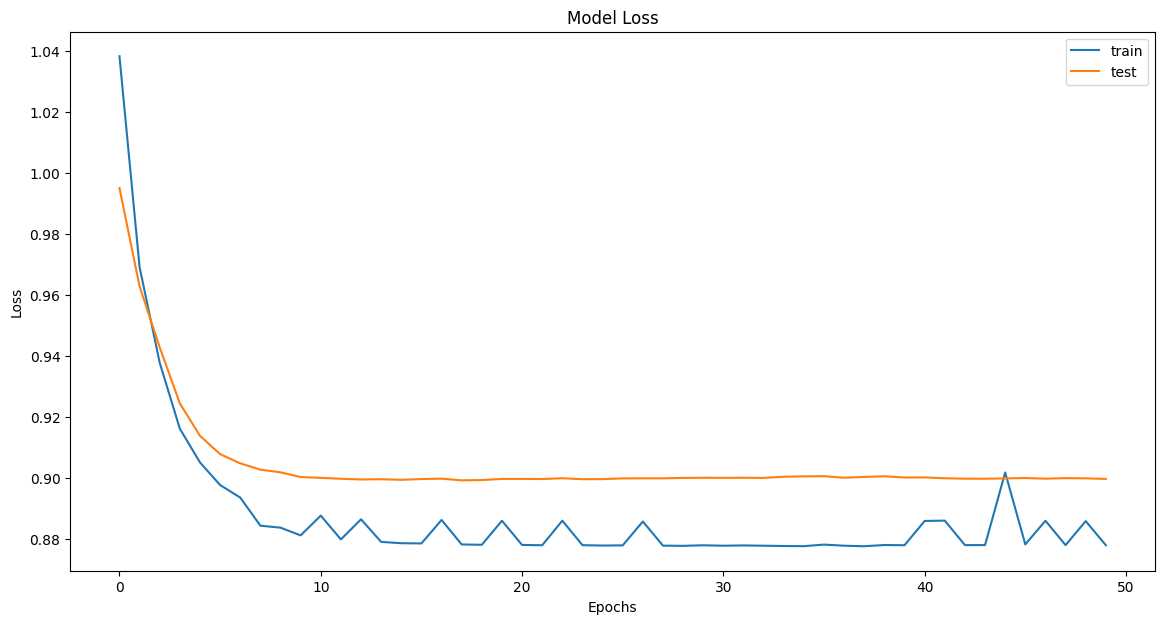

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 44.94%


For threshold set to 0.40, correctness is: 44.94%
For threshold set to 0.45, correctness is: 44.94%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 5, Epoch: 10, Accuracy: 47.90%
Chunk size: 5, Epoch: 50, Accuracy: 47.79%
Chunk size: 10, Epoch: 10, Accuracy: 46.90%
Top 3 results:
File: csgofastcom.csv, Chunk size: 10, Epoch: 50, Accuracy: 50.79%
File: plgbet.csv, Chunk size: 5, Epoch: 10, Accuracy: 47.90%
File: csgo500com.csv, Chunk size: 20, Epoch: 20, Accuracy: 47.74%


In [29]:
CHUNK_SIZES_TO_TEST = [2,5,10,15,20,40]
EPOCHS_TO_TEST = [10,20,50]

results = []
for file in os.listdir("data"):
    print(f"\n====================\nData from file: {file}\n====================\n")
    colors = read_file(f"data/{file}")
    top_accuracy = analize_dataset(colors, CHUNK_SIZES_TO_TEST, EPOCHS_TO_TEST)
    results.append((*top_accuracy, file))

results.sort(key=lambda x: x[2], reverse=True)
print("Top 3 results:")
for i in range(min(3, len(results))):
    chunk_size, epoch, accuracy, file = results[i]
    print(f"File: {file}, Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")